In [1]:
# Importing libs
import pandas as pd
import seaborn as sns
import numpy as np
import json
from jinja2 import Template

from IPython.display import display, Markdown

In [2]:
# Open dataset

data = pd.read_csv('../estaticos_market.csv', index_col=0)

# Remoção de features com 99%+ de NaN

Colunas com praticamente todas as linhas NaN não tem muito sentido

In [3]:
# Remove coluns with 99%+ NaN

removed_coluns_by_99_pctg_NaN = []
for col in data.iloc[:, 1:]:
    if data[col].isna().sum()/data[col].size > 0.99:
        removed_coluns_by_99_pctg_NaN.append(col)

new_columns = list(set(data.columns) - set(removed_coluns_by_99_pctg_NaN))

In [4]:
print(f'Num. of removed columns: {len(removed_coluns_by_99_pctg_NaN)}')
print('Colunas retiradas:')
removed_coluns_by_99_pctg_NaN

Num. of removed columns: 24
Colunas retiradas:


['vl_total_tancagem',
 'vl_total_veiculos_antt',
 'vl_total_tancagem_grupo',
 'vl_total_veiculos_antt_grupo',
 'vl_potenc_cons_oleo_gas',
 'qt_socios_st_suspensa',
 'qt_alteracao_socio_total',
 'qt_alteracao_socio_90d',
 'qt_alteracao_socio_180d',
 'qt_alteracao_socio_365d',
 'qt_socios_pj_ativos',
 'qt_socios_pj_nulos',
 'qt_socios_pj_baixados',
 'qt_socios_pj_suspensos',
 'qt_socios_pj_inaptos',
 'vl_idade_media_socios_pj',
 'vl_idade_maxima_socios_pj',
 'vl_idade_minima_socios_pj',
 'coligada_mais_nova_baixada',
 'coligada_mais_antiga_baixada',
 'idade_media_coligadas_baixadas',
 'idade_ate_18',
 'grau_instrucao_macro_analfabeto',
 'grau_instrucao_macro_desconhecido']

In [5]:
data_no_high_nan = data.loc[:, new_columns]

data_no_high_nan.shape

(462298, 157)

# Removendo colunas com alta correlação linear

Removendo colunas que já estão representadas por outras colunas com uma correlação linear > 95%.

Formarei um grafo não-ponderado e não-dirigido, onde os nodos são as colunas e as arestas representam uma correlação linear maior que 95% entre os dois nodos. Indo do nodo com mais arcos para os com menos, farei a remoção de todos os nodos ligados ao nodo em análise, mantendo assim somente os nodos que representam o maior número de outras colunas removidas possível.

In [6]:
# Take correlations, without id column
correlations = data_no_high_nan.iloc[:,1:].corr()

In [7]:
# Take pairs of columns that have correlation > thresh, without mirror pairs and assimetric
thresh = 0.95
high_correlations = np.array([p for p in zip(*np.where(correlations >= thresh)) if p[0] > p[1]])

# Check the columns that are on
corr_serie = pd.Series(high_correlations.reshape(-1))
corr_serie_counts = corr_serie.value_counts()

# For each high correlation found, remove one of the columns. The one that repeatless,
# trying to keep the most representative ones
columns = np.full((data_no_high_nan.iloc[:,1:].shape[1],), True, dtype=bool)
for p in high_correlations:
    if corr_serie_counts[p[0]] > corr_serie_counts[p[1]]:
        columns[p[1]] = False
    else:
        columns[p[0]] = False
        

kept_columns = data_no_high_nan.iloc[:,1:].columns[columns]
removed_columns = data_no_high_nan.iloc[:,1:].columns[columns == False]

print(f'Num. of kept columns: {len(kept_columns)}')
print(f'Num. of removed columns: {len(removed_columns)}')
removed_columns_by_high_correlations = removed_columns

Num. of kept columns: 122
Num. of removed columns: 34


In [8]:
data_no_high_corr = data_no_high_nan.loc[:, ['id', *kept_columns]]

data_no_high_corr.shape

(462298, 123)

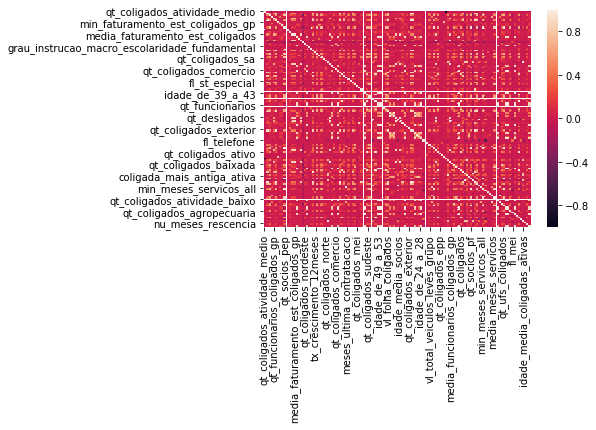

In [9]:
sns.heatmap(correlations)

In [10]:
string_template = '''
-----
# Analysis of {{ COL_NAME }}

### Type of column: {{ COL_TYPE }}

Description: {{ COL_DESCRIPTION }}

{% if FLOAT_TYPE %}

* Average value: {{ AVG }}
* Mode value: {{ MODE }}
* Q2: {{ Q2 }}
* Variance: {{ VAR }}

{% else %}

* Value counts

{% for key in VALUE_COUNTS %}
    * {{key }} : {{ VALUE_COUNTS[key] }}
{% endfor %}
{% endif %}

### NaN %: {{ NAN_PCTG }}%
#### NaN count: {{ NAN_COUNT }}
'''

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [12]:
with open('dict.json') as f:
    vars_dict = json.load(f)

tm = Template(string_template)

df = data_no_high_corr
for name in df:
    if name == 'id':
        continue

    tm = Template(string_template)
    info = dict()
    info['COL_NAME'] = name
    info['COL_TYPE'] = df[name].dtype
    info['COL_DESCRIPTION'] = vars_dict[name]
        
        
    info['NAN_PCTG'] = round(100*df[name].isna().sum()/df[name].size, 2)
    info['NAN_COUNT'] = df[name].isna().sum()
    
    if np.issubsctype(df[name].dtype, float) or np.issubsctype(df[name].dtype, int):
        info['FLOAT_TYPE'] = True
        info['AVG'] = df[name].mean()
        info['VAR'] = df[name].var()
        info['MODE'] = df[name].mode()
        info['Q2'] = round(df[name].median(), 3)
    
    else:
        info['FLOAT_TYPE'] = False
        info['VALUE_COUNTS'] = dict()
        counts = df[name].value_counts()
        for key in counts.index:
            info['VALUE_COUNTS'][key] = counts.loc[key]

    display(Markdown(tm.render(info)))


-----
# Analysis of qt_coligados_atividade_medio

### Type of column: float64

Description: integer value, quantity of connected companies with estimated activity level classsifier equal to 'Medio'



* Average value: 0.0
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.0



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of percent_func_genero_fem

### Type of column: float64

Description: numeric value, share of female employees in the company



* Average value: 44.30057688762477
* Mode value: 0    0.0
dtype: float64
* Q2: 40.0
* Variance: 1524.4656103346888



### NaN %: 83.57%
#### NaN count: 386356


-----
# Analysis of max_faturamento_est_coligados

### Type of column: float64

Description: numeric value, maximum value of estimated revenue from connected companies



* Average value: 400661760.7830352
* Mode value: 0    210000.0
dtype: float64
* Q2: 412128.0
* Variance: 2.6310071282957316e+19



### NaN %: 86.04%
#### NaN count: 397775


-----
# Analysis of qt_ramos_coligados

### Type of column: float64

Description: integer value, quantity of distinct economic branches from connected companies



* Average value: 2.8773225673257787
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 20.020796477062053



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of max_meses_servicos

### Type of column: float64

Description: numeric, maximum number of months worked by the active employees of the company



* Average value: 96.66198318931036
* Mode value: 0    93.266667
dtype: float64
* Q2: 61.767
* Variance: 78143.30671054429



### NaN %: 83.5%
#### NaN count: 386037


-----
# Analysis of faturamento_est_coligados_gp

### Type of column: float64

Description: numeric value, sum of estimated revenue from connected companies and their subsidiaries



* Average value: 1006580838.6023813
* Mode value: 0    210000.0
dtype: float64
* Q2: 865468.812
* Variance: 1.274549371707884e+20



### NaN %: 86.04%
#### NaN count: 397775


-----
# Analysis of min_faturamento_est_coligados_gp

### Type of column: float64

Description: numeric value, minimum value of estimated revennue from connected companies and their subsidiaries



* Average value: 1381248.4828021012
* Mode value: 0    210000.0
dtype: float64
* Q2: 210000.0
* Variance: 478542079804417.75



### NaN %: 86.04%
#### NaN count: 397775


-----
# Analysis of max_meses_servicos_all

### Type of column: float64

Description: numeric, maximum number of months worked by all the employees of the company (active and dismissed)



* Average value: 155.5694112913609
* Mode value: 0    5014.966667
dtype: float64
* Q2: 53.667
* Variance: 406853.8759626547



### NaN %: 77.6%
#### NaN count: 358738


-----
# Analysis of fl_optante_simei

### Type of column: object

Description: boolean, true if the company is taxed as an MEI - Individual Micro Entrepreneur (Micro Empreendedor Individual)



* Value counts


    * False : 285545

    * True : 94040



### NaN %: 17.89%
#### NaN count: 82713


-----
# Analysis of vl_total_veiculos_leves

### Type of column: float64

Description: integer, total number of light weight vehicles of the company



* Average value: 2.2443292921392257
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 91.63345381145368



### NaN %: 93.36%
#### NaN count: 431614


-----
# Analysis of qt_socios_pep

### Type of column: float64

Description: integer value, quantity of partners of the cnpj that are politicaly exposed



* Average value: 5.992436600919472
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 215.35577191733117



### NaN %: 98.54%
#### NaN count: 455555


-----
# Analysis of qt_coligados_atividade_alto

### Type of column: float64

Description: integer value, quantity of connected companies with estimated activity level classifier equal to 'ALTO'



* Average value: 0.0
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.0



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of qt_art

### Type of column: float64

Description: integer, number of constructions(buildings) authorized by an architect (ART - Anotação de Responsabilidade Técnica)



* Average value: 5.7690440060698025
* Mode value: 0    1.0
dtype: float64
* Q2: 2.0
* Variance: 647.7508703865898



### NaN %: 98.57%
#### NaN count: 455708


-----
# Analysis of media_faturamento_est_coligados

### Type of column: float64

Description: numeric value, average of estimated revenue from connected companies



* Average value: 23142644.750762366
* Mode value: 0    210000.0
dtype: float64
* Q2: 315800.348
* Variance: 1.3529368555708589e+17



### NaN %: 86.04%
#### NaN count: 397775


-----
# Analysis of media_faturamento_est_coligados_gp

### Type of column: float64

Description: numeric value, average of estimated revenue from connected companies and their subsidiaries



* Average value: 30457391.32662822
* Mode value: 0    210000.0
dtype: float64
* Q2: 420000.0
* Variance: 2.2208406688845523e+17



### NaN %: 86.04%
#### NaN count: 397775


-----
# Analysis of vl_faturamento_estimado_aux

### Type of column: float64

Description: numeric value, value of the estimated revenue



* Average value: 802091.137802753
* Mode value: 0    210000.0
dtype: float64
* Q2: 210000.0
* Variance: 960986882233849.9



### NaN %: 5.95%
#### NaN count: 27513


-----
# Analysis of vl_total_veiculos_pesados

### Type of column: float64

Description: integer, total number of heavy weight vehicles of the company



* Average value: 1.177812540737844
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 43.41569777328599



### NaN %: 93.36%
#### NaN count: 431614


-----
# Analysis of media_vl_folha_coligados_gp

### Type of column: float64

Description: numeric value, average of payroll value from connected companies and their subsidiaries



* Average value: 15804829.971929519
* Mode value: 0    61819.199219
dtype: float64
* Q2: 539200.806
* Variance: 4.647617843886288e+16



### NaN %: 92.1%
#### NaN count: 425761


-----
# Analysis of fl_matriz

### Type of column: bool

Description: boolean value, `true` if the CNPJ corresponds to the "matriz".



* Value counts


    * True : 433232

    * False : 29066



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of qt_coligados_nordeste

### Type of column: float64

Description: integer value, quantity of connected companies that are located in the northeast region of the country



* Average value: 2.2443761373889375
* Mode value: 0    0.0
dtype: float64
* Q2: 1.0
* Variance: 51.789063607960315



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of grau_instrucao_macro_escolaridade_fundamental

### Type of column: float64

Description: integer value, quantity of employees in positions with required fundamental level (complete and incomplete)



* Average value: 8.24646529562982
* Mode value: 0    1.0
dtype: float64
* Q2: 2.0
* Variance: 5884.469640046036



### NaN %: 94.61%
#### NaN count: 437402


-----
# Analysis of qt_coligados_me

### Type of column: float64

Description: integer value, quantity of connected companies that has the term ME in the end of the business name



* Average value: 0.00851799177256809
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.11500620092648235



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of qt_coligados_suspensa

### Type of column: float64

Description: integer value, quantity of connected companies that are considered suspended according to the IRS



* Average value: 0.00042819348228349466
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.00042801667812350616



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of fl_spa

### Type of column: object

Description: boolean, true if the company has it's own fuel station



* Value counts


    * False : 460091

    * True : 280



### NaN %: 0.42%
#### NaN count: 1927


-----
# Analysis of vl_folha_coligados_gp

### Type of column: float64

Description: numeric value, sum of payroll value from connected companies and their subsidiaries



* Average value: 114484765.34699419
* Mode value: 0    61819.199219
dtype: float64
* Q2: 927288.012
* Variance: 6.817616639926707e+17



### NaN %: 92.1%
#### NaN count: 425761


-----
# Analysis of tx_crescimento_12meses

### Type of column: float64

Description: integer, growth of employees in relation to the number of employees 12 months before



* Average value: 3.097606898347783
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 26758.923222571146



### NaN %: 84.02%
#### NaN count: 388410


-----
# Analysis of qt_coligados_serviço

### Type of column: float64

Description: integer value, quantity of connected companies from the service sector



* Average value: 2.91823033750822
* Mode value: 0    0.0
dtype: float64
* Q2: 1.0
* Variance: 124.46924266118147



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of vl_frota

### Type of column: float64

Description: numeric, agregate value of all vehicles of the company



* Average value: 169422.57490698635
* Mode value: 0    46918.0
dtype: float64
* Q2: 51693.0
* Variance: 730866815309.6842



### NaN %: 94.77%
#### NaN count: 438108


-----
# Analysis of qt_coligados_sa

### Type of column: float64

Description: integer value, quantity of connected companies that has the term SA in the end of the business name



* Average value: 0.719823828967289
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 23.462576729935922



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of idade_emp_cat

### Type of column: object

Description: character, age of the company by ranges



* Value counts


    * 1 a 5 : 138580

    * 5 a 10 : 116100

    * > 20 : 75572

    * 10 a 15 : 49205

    * <= 1 : 46794

    * 15 a 20 : 36047



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of qt_coligados_inapta

### Type of column: float64

Description: integer value, quantity of connected companies that are considered as inapt/unfit according to the IRS



* Average value: 0.03193099967885489
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.10180957444059566



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of qt_coligados_norte

### Type of column: float64

Description: integer value, quantity of connected companies that are located in the north region of the country



* Average value: 0.9122509213806181
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 10.486289888161524



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of idade_media_coligadas

### Type of column: float64

Description: float, average age (months) of connected companies



* Average value: 159.171741084957
* Mode value: 0    544.766667
dtype: float64
* Q2: 135.933
* Variance: 11560.065512178868



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of min_vl_folha_coligados_gp

### Type of column: float64

Description: numeric value, minimum of payroll value from connected companies and their subsidiaries



* Average value: 5446710.276270632
* Mode value: 0    61819.2
dtype: float64
* Q2: 185457.6
* Variance: 3.6151047676737384e+16



### NaN %: 92.1%
#### NaN count: 425761


-----
# Analysis of idade_de_29_a_33

### Type of column: float64

Description: integer value, quantity of employees with age between 29 and 33 years old.



* Average value: 5.158931818747976
* Mode value: 0    1.0
dtype: float64
* Q2: 2.0
* Variance: 925.1684523689997



### NaN %: 91.32%
#### NaN count: 422155


-----
# Analysis of qt_socios_feminino

### Type of column: float64

Description: integer value, quantity of female partners (womens)



* Average value: 1.1071165077329361
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 0.7059253733925094



### NaN %: 68.63%
#### NaN count: 317269


-----
# Analysis of qt_coligados_comercio

### Type of column: float64

Description: integer value, quantity of connected companies



* Average value: 1.1698398862228747
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 30.181461358366857



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of idade_acima_de_58

### Type of column: float64

Description: integer value, quantity of employees with age above



* Average value: 8.240522401596227
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 17848.212257105763



### NaN %: 97.61%
#### NaN count: 451272


-----
# Analysis of fl_simples_irregular

### Type of column: object

Description: boolean, true if the company is taxed under the SIMPLES regime and has a impeditive CNAE (economic activities that are not allowed to be taxed according to the simples regime) revenue above the limit of the regime.



* Value counts


    * False : 460030

    * True : 341



### NaN %: 0.42%
#### NaN count: 1927


-----
# Analysis of max_vl_folha_coligados

### Type of column: float64

Description: numeric value, maximum of payroll value from connected companies



* Average value: 22582083.573048964
* Mode value: 0    61819.2
dtype: float64
* Q2: 618192.0
* Variance: 1.6892688186938332e+16



### NaN %: 92.14%
#### NaN count: 425984


-----
# Analysis of fl_optante_simples

### Type of column: object

Description: boolean, true if the company is taxed according to SIMPLES regime



* Value counts


    * True : 199617

    * False : 179968



### NaN %: 17.89%
#### NaN count: 82713


-----
# Analysis of de_faixa_faturamento_estimado

### Type of column: object

Description: character value, class of the estimated revenue of the company



* Value counts


    * DE R$ 81.000,01 A R$ 360.000,00 : 273861

    * ATE R$ 81.000,00 : 98558

    * DE R$ 360.000,01 A R$ 1.500.000,00 : 46225

    * DE R$ 1.500.000,01 A R$ 4.800.000,00 : 10153

    * DE R$ 4.800.000,01 A R$ 10.000.000,00 : 2150

    * DE R$ 10.000.000,01 A R$ 30.000.000,00 : 1445

    * SEM INFORMACAO : 1173

    * DE R$ 30.000.000,01 A R$ 100.000.000,00 : 871

    * DE R$ 100.000.000,01 A R$ 300.000.000,00 : 253

    * DE R$ 300.000.000,01 A R$ 500.000.000,00 : 48

    * DE R$ 500.000.000,01 A 1 BILHAO DE REAIS : 27

    * ACIMA DE 1 BILHAO DE REAIS : 21



### NaN %: 5.95%
#### NaN count: 27513


-----
# Analysis of qt_coligados_ccivil

### Type of column: float64

Description: integer value, quantity of connected companies from the construction sector



* Average value: 1.205731675612852
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 317.4936732186571



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of max_filiais_coligados

### Type of column: float64

Description: numeric value, maximum number of subsidiaries from connected companies



* Average value: 34.66406862745098
* Mode value: 0    1.0
dtype: float64
* Q2: 2.0
* Variance: 63657.06136880748



### NaN %: 95.59%
#### NaN count: 441898


-----
# Analysis of fl_sa

### Type of column: bool

Description: boolean value, true if the company has the term 'SA' in the end of its legal name.



* Value counts


    * False : 453866

    * True : 8432



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of fl_st_especial

### Type of column: bool

Description: boolean value, true if dt_situacao_especial is not null. If it is not null means that some extraordinary situation is identified by the IRS (ESPOLIO DE EMPRESARIO EMPRESA INDIVIDUAL OU EIRELI, FALIDO, EM LIQUIDACAO, LIQUIDACAO JUDICIAL, LIQUIDACAO EXTRA JUDICIAL, REGISTRO NA JUNTA COMERCIAL EM ANDAMENTO, EM LIQUID EXTRA JUDICIAL, RECUPERACAO JUDICIAL, INTERVENCAO)



* Value counts


    * False : 462230

    * True : 68



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of de_indicador_telefone

### Type of column: object

Description: character, propability to reach the company using the phone numbers provided by Neoway



* Value counts


    * BOA : 43879

    * INDETERMINADA : 14



### NaN %: 90.51%
#### NaN count: 418405


-----
# Analysis of qt_coligados_mei

### Type of column: float64

Description: integer value, quantity of connected companies that has the term MEI in the end of the business name



* Average value: 0.027037359881329236
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.02973234359580685



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of min_vl_folha_coligados

### Type of column: float64

Description: numeric value, minimum of payroll value from connected companies



* Average value: 2261567.42508399
* Mode value: 0    61819.2
dtype: float64
* Q2: 185457.6
* Variance: 799963743786589.8



### NaN %: 92.14%
#### NaN count: 425984


-----
# Analysis of qt_coligados_industria

### Type of column: float64

Description: integer value, quantity of connected companies from the industry sector



* Average value: 0.5298435564527229
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 24.044464142828915



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of qt_coligados_atividade_inativo

### Type of column: float64

Description: integer value, quantity of connected companies with estimated activity level classifier equal to 'INATIVO'



* Average value: 0.0
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.0



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of idade_de_39_a_43

### Type of column: float64

Description: integer value, quantity of employees with age between 39 and 43 years old.



* Average value: 5.664660615627467
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 2889.45320302225



### NaN %: 93.42%
#### NaN count: 431890


-----
# Analysis of qt_coligados_sudeste

### Type of column: float64

Description: integer value, quantity of connected companies that are located in the southeast of the country



* Average value: 2.3684299062562126
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 448.2838016011388



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of idade_maxima_socios

### Type of column: float64

Description: same as above but with max metric



* Average value: 44.344130597111004
* Mode value: 0    37.0
dtype: float64
* Q2: 43.0
* Variance: 194.05563512948996



### NaN %: 32.79%
#### NaN count: 151602


-----
# Analysis of idade_de_49_a_53

### Type of column: float64

Description: integer value, quantity of employees with age between 49 and 53 years old.



* Average value: 5.758155171508116
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 7494.744512839333



### NaN %: 95.88%
#### NaN count: 443261


-----
# Analysis of fl_epp

### Type of column: bool

Description: boolean value, true if the company has the term 'EPP' in the end of its legal name.



* Value counts


    * False : 462298



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of qt_coligados_ltda

### Type of column: float64

Description: integer value, quantity of connected companies that has the term  LTDA in the end of the business name



* Average value: 0.08022510743068618
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.46626608176202194



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of vl_folha_coligados

### Type of column: float64

Description: numeric value, sum of payroll value from connected companies



* Average value: 45284172.192583695
* Mode value: 0    61819.199219
dtype: float64
* Q2: 803649.62
* Variance: 5.996166175199219e+16



### NaN %: 92.14%
#### NaN count: 425984


-----
# Analysis of qt_ex_funcionarios

### Type of column: float64

Description: integer value, number of employees that have left the company.



* Average value: 24.838417755565967
* Mode value: 0    0.0
dtype: float64
* Q2: 3.0
* Variance: 37040.39394943178



### NaN %: 75.07%
#### NaN count: 347044


-----
# Analysis of qt_admitidos_12meses

### Type of column: float64

Description: integer, quantity of employees hired in the last 12 months



* Average value: 2.1010292158263657
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 301.9878040636612



### NaN %: 77.6%
#### NaN count: 358724


-----
# Analysis of min_filiais_coligados

### Type of column: float64

Description: numeric value, minimum number of subsidiaries from connected companies



* Average value: 4.425539215686275
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 4206.892538559174



### NaN %: 95.59%
#### NaN count: 441898


-----
# Analysis of idade_media_socios

### Type of column: float64

Description: numeric value, average age of the partners of the cnpj(considers only the cpf partners)



* Average value: 42.816451969572604
* Mode value: 0    36.0
dtype: float64
* Q2: 42.0
* Variance: 159.4271587352299



### NaN %: 32.79%
#### NaN count: 151602


-----
# Analysis of nm_micro_regiao

### Type of column: object

Description: character, name of the micro region where the company is located.



* Value counts


    * MANAUS : 60008

    * NATAL : 46745

    * AGLOMERACAO URBANA DE SAO LUIS : 45875

    * TERESINA : 33887

    * IMPERATRIZ : 15912

    * RIO BRANCO : 14064

    * MOSSORO : 10713

    * PINDARE : 8167

    * MACAIBA : 7318

    * LITORAL PIAUIENSE : 6816

    * CAXIAS : 6744

    * MEDIO MEARIM : 6634

    * BAIXADA MARANHENSE : 6492

    * BAIXO PARNAIBA PIAUIENSE : 5103

    * PICOS : 4855

    * ALTO MEDIO CANINDE : 4371

    * ALTO MEARIM E GRAJAU : 4329

    * CAMPO MAIOR : 4187

    * PARINTINS : 3966

    * AGRESTE POTIGUAR : 3912

    * SERIDO ORIENTAL : 3728

    * GERAIS DE BALSAS : 3691

    * FLORIANO : 3488

    * VALE DO ACU : 3304

    * MADEIRA : 3297

    * CODO : 3181

    * LITORAL SUL : 3142

    * ITACOATIARA : 2849

    * SERIDO OCIDENTAL : 2841

    * PRESIDENTE DUTRA : 2792

    * CRUZEIRO DO SUL : 2756

    * CHAPADINHA : 2736

    * GURUPI : 2717

    * SAO RAIMUNDO NONATO : 2675

    * PORTO FRANCO : 2661

    * CHAPADAS DO ALTO ITAPECURU : 2631

    * BORBOREMA POTIGUAR : 2600

    * PAU DOS FERROS : 2573

    * ITAPECURU MIRIM : 2465

    * ALTO SOLIMOES : 2416

    * MEDIO PARNAIBA PIAUIENSE : 2292

    * LENCOIS MARANHENSES : 2266

    * ALTO MEDIO GURGUEIA : 2208

    * LITORAL OCIDENTAL MARANHENSE : 2183

    * ROSARIO : 2050

    * VALENCA DO PIAUI : 1878

    * COARI : 1873

    * MACAU : 1651

    * LITORAL NORDESTE : 1557

    * CHAPADAS DO EXTREMO SUL PIAUIENSE : 1553

    * BRASILEIA : 1510

    * BAIXO PARNAIBA MARANHENSE : 1412

    * RIO PRETO DA EVA : 1407

    * CHAPADA DO APODI : 1406

    * ALTO PARNAIBA PIAUIENSE : 1402

    * UMARIZAL : 1394

    * RIO NEGRO : 1378

    * TEFE : 1366

    * BAIXA VERDE : 1333

    * JURUA : 1322

    * SERRA DE SANTANA : 1268

    * ANGICOS : 1193

    * TARAUACA : 1144

    * CHAPADAS DAS MANGABEIRAS : 1030

    * SENA MADUREIRA : 965

    * COELHO NETO : 947

    * SERRA DE SAO MIGUEL : 908

    * BOCA DO ACRE : 877

    * BERTOLINIA : 854

    * PIO IX : 823

    * PURUS : 757

    * MEDIO OESTE : 562

    * JAPURA : 190



### NaN %: 12.7%
#### NaN count: 58698


-----
# Analysis of min_funcionarios_coligados_gp

### Type of column: float64

Description: numeric value, minimum number of employees from connected companies and their subsidiaries



* Average value: 155.2228447155048
* Mode value: 0    0.0
dtype: float64
* Q2: 1.0
* Variance: 336854839.2888809



### NaN %: 90.85%
#### NaN count: 419995


-----
# Analysis of fl_veiculo

### Type of column: object

Description: boolean, true if the company owns at least one vehicle



* Value counts


    * False : 429687

    * True : 30684



### NaN %: 0.42%
#### NaN count: 1927


-----
# Analysis of qt_funcionarios_24meses

### Type of column: float64

Description: integer, quantity of employees active 24 months before



* Average value: 14.343329406994034
* Mode value: 0    0.0
dtype: float64
* Q2: 2.0
* Variance: 57544.9853263523



### NaN %: 77.6%
#### NaN count: 358724


-----
# Analysis of qt_coligados_exterior

### Type of column: float64

Description: integer value, quantity of connected companies that are located abroad the country



* Average value: 0.015843158844489304
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.027459649601423903



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of faturamento_est_coligados

### Type of column: float64

Description: numeric value, sum of estimated revenue from connected companies



* Average value: 884375198.6200156
* Mode value: 0    210000.0
dtype: float64
* Q2: 741830.375
* Variance: 1.0813427909797949e+20



### NaN %: 86.04%
#### NaN count: 397775


-----
# Analysis of max_faturamento_est_coligados_gp

### Type of column: float64

Description: numeric value, maximum value of estimated revennue from connected companies and their subsidiaries



* Average value: 473111909.7974708
* Mode value: 0    210000.0
dtype: float64
* Q2: 576979.2
* Variance: 3.514272101679719e+19



### NaN %: 86.04%
#### NaN count: 397775


-----
# Analysis of qt_admitidos

### Type of column: float64

Description: integer,  quantity of employees hired by the company



* Average value: 40.02267943692433
* Mode value: 0    1.0
dtype: float64
* Q2: 6.0
* Variance: 142439.6390924855



### NaN %: 77.6%
#### NaN count: 358724


-----
# Analysis of qt_desligados_12meses

### Type of column: float64

Description: integer, quantity of employees dismissed in the last 12 months



* Average value: 1.8531484735551393
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 243.05375327819783



### NaN %: 77.6%
#### NaN count: 358724


-----
# Analysis of idade_de_24_a_28

### Type of column: float64

Description: integer value, quantity of employees with age between 24 and 28 years old.



* Average value: 4.247383982517033
* Mode value: 0    1.0
dtype: float64
* Q2: 2.0
* Variance: 336.31052787885585



### NaN %: 91.59%
#### NaN count: 423403


-----
# Analysis of total

### Type of column: float64

Description: integer value, actual number of employees of the company



* Average value: 16.70644702536146
* Mode value: 0    1.0
dtype: float64
* Q2: 3.0
* Variance: 67324.06529837026



### NaN %: 83.57%
#### NaN count: 386356


-----
# Analysis of nm_meso_regiao

### Type of column: object

Description: character, name of the meso region where the company is located.



* Value counts


    * CENTRO AMAZONENSE : 71469

    * NORTE MARANHENSE : 61331

    * LESTE POTIGUAR : 58762

    * CENTRO NORTE PIAUIENSE : 42244

    * OESTE MARANHENSE : 26796

    * OESTE POTIGUAR : 20860

    * LESTE MARANHENSE : 17651

    * VALE DO ACRE : 16539

    * CENTRO MARANHENSE : 13755

    * SUDOESTE PIAUIENSE : 12180

    * NORTE PIAUIENSE : 11919

    * CENTRAL POTIGUAR : 10681

    * SUDESTE PIAUIENSE : 10049

    * AGRESTE POTIGUAR : 7845

    * SUL MARANHENSE : 7382

    * SUL AMAZONENSE : 4931

    * VALE DO JURUA : 3900

    * SUDOESTE AMAZONENSE : 3738

    * NORTE AMAZONENSE : 1568



### NaN %: 12.7%
#### NaN count: 58698


-----
# Analysis of qt_coligados_nula

### Type of column: float64

Description: integer value, quantity of connected companies that are considered as nule companies according to the IRS



* Average value: 0.0
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.0



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of vl_total_veiculos_leves_grupo

### Type of column: float64

Description: numeric, economic value of the light weight vehicles of the economic group of the company



* Average value: 48.69917740257314
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 1456117.176065075



### NaN %: 0.42%
#### NaN count: 1927


-----
# Analysis of sg_uf_matriz

### Type of column: object

Description: character, state of the main office location



* Value counts


    * MA : 124823

    * RN : 96743

    * AM : 80032

    * PI : 75201

    * RO : 54876

    * AC : 20028

    * SP : 2845

    * DF : 1225

    * CE : 927

    * RJ : 669

    * PE : 455

    * PA : 425

    * MG : 319

    * PR : 303

    * MT : 257

    * BA : 238

    * PB : 208

    * GO : 199

    * RS : 134

    * SC : 123

    * ES : 100

    * TO : 65

    * RR : 53

    * MS : 51

    * AL : 25

    * SE : 20

    * AP : 15



### NaN %: 0.42%
#### NaN count: 1939


-----
# Analysis of media_filiais_coligados

### Type of column: float64

Description: numeric value, average of subsidiaries from connected companies



* Average value: 9.492186627378793
* Mode value: 0    1.0
dtype: float64
* Q2: 2.0
* Variance: 5229.609435899351



### NaN %: 95.59%
#### NaN count: 441898


-----
# Analysis of de_faixa_faturamento_estimado_grupo

### Type of column: object

Description: character value, class of the sum of estimated revenue for the matrix company and branches



* Value counts


    * DE R$ 81.000,01 A R$ 360.000,00 : 252602

    * ATE R$ 81.000,00 : 98118

    * DE R$ 360.000,01 A R$ 1.500.000,00 : 53492

    * DE R$ 1.500.000,01 A R$ 4.800.000,00 : 13465

    * DE R$ 4.800.000,01 A R$ 10.000.000,00 : 4055

    * ACIMA DE 1 BILHAO DE REAIS : 3613

    * DE R$ 10.000.000,01 A R$ 30.000.000,00 : 3598

    * DE R$ 30.000.000,01 A R$ 100.000.000,00 : 3061

    * DE R$ 100.000.000,01 A R$ 300.000.000,00 : 1583

    * DE R$ 500.000.000,01 A 1 BILHAO DE REAIS : 676

    * DE R$ 300.000.000,01 A R$ 500.000.000,00 : 522



### NaN %: 5.95%
#### NaN count: 27513


-----
# Analysis of min_faturamento_est_coligados

### Type of column: float64

Description: numeric value, minimum value of estimated revenue from connected companies



* Average value: 898642.7300928351
* Mode value: 0    210000.0
dtype: float64
* Q2: 210000.0
* Variance: 145355242787763.0



### NaN %: 86.04%
#### NaN count: 397775


-----
# Analysis of percent_func_genero_masc

### Type of column: float64

Description: numeric value, share of male employees in the company



* Average value: 55.69943483184535
* Mode value: 0    100.0
dtype: float64
* Q2: 60.0
* Variance: 1524.4657485013763



### NaN %: 83.57%
#### NaN count: 386356


-----
# Analysis of idade_maxima_coligadas

### Type of column: float64

Description: float, maximum age (months) of connected companies



* Average value: 227.62517114995433
* Mode value: 0    629.966667
dtype: float64
* Q2: 193.667
* Variance: 27341.979300627238



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of media_funcionarios_coligados_gp

### Type of column: float64

Description: numeric value, average of employees from the connected companies and their subsidiaries



* Average value: 364.9553036311657
* Mode value: 0    0.0
dtype: float64
* Q2: 6.0
* Variance: 346913210.505765



### NaN %: 90.85%
#### NaN count: 419995


-----
# Analysis of de_natureza_juridica

### Type of column: object

Description: character, juridic nature of the company.



* Value counts


    * EMPRESARIO INDIVIDUAL : 295756

    * SOCIEDADE EMPRESARIA LIMITADA : 91231

    * ASSOCIACAO PRIVADA : 29694

    * EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA EMPRESARIA : 15183

    * ORGAO DE DIRECAO LOCAL DE PARTIDO POLITICO : 7301

    * ORGANIZACAO RELIGIOSA : 2908

    * SOCIEDADE ANONIMA FECHADA : 2196

    * CONDOMINIO EDILICIO : 2084

    * ENTIDADE SINDICAL : 1763

    * CANDIDATO A CARGO POLITICO ELETIVO : 1617

    * SOCIEDADE SIMPLES LIMITADA : 1316

    * EMPRESA INDIVIDUAL IMOBILIARIA : 1225

    * COOPERATIVA : 1151

    * FUNDO PUBLICO : 1013

    * SOCIEDADE SIMPLES PURA : 901

    * SOCIEDADE ANONIMA ABERTA : 882

    * ORGAO PUBLICO DO PODER EXECUTIVO MUNICIPAL : 650

    * MUNICIPIO : 555

    * SOCIEDADE DE ECONOMIA MISTA : 550

    * EMPRESA PUBLICA : 549

    * SERVICO NOTARIAL E REGISTRAL CARTORIO : 480

    * FUNDACAO PRIVADA : 470

    * SOCIEDADE UNIPESSOAL DE ADVOCACIA : 459

    * ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU DO DISTRITO FEDERAL : 322

    * ORGAO PUBLICO DO PODER LEGISLATIVO MUNICIPAL : 300

    * AUTARQUIA FEDERAL : 231

    * ORGAO PUBLICO DO PODER EXECUTIVO FEDERAL : 163

    * SOCIEDADE EMPRESARIA EM NOME COLETIVO : 161

    * CONSORCIO DE SOCIEDADES : 156

    * SERVICO SOCIAL AUTONOMO : 144

    * SOCIEDADE EM CONTA DE PARTICIPACAO : 126

    * AUTARQUIA MUNICIPAL : 123

    * ORGAO DE DIRECAO REGIONAL DE PARTIDO POLITICO : 92

    * EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA SIMPLES : 85

    * FUNDACAO PUBLICA DE DIREITO PUB MUNICIPAL : 82

    * ORGANIZACAO SOCIAL OS : 56

    * CONSORCIO PUBDE DIREITO PUB ASS PUB : 51

    * AUTARQUIA ESTADUAL OU DO DISTRITO FEDERAL : 40

    * FUNDACAO PUBLICA DE DIREITO PUBFEDERAL : 36

    * ORGAO PUBLICO DO PODER JUDICIARIO ESTADUAL : 29

    * FUNDACAO PUB DE DIREITO PUB EST OU DO DF : 27

    * ORGAO PUBLICO DO PODER JUDICIARIO FEDERAL : 19

    * ENTIDADE DE MEDIACAO E ARBITRAGEM : 16

    * ORGAO PUBLICO AUTONOMO MUNICIPAL : 11

    * GRUPO DE SOCIEDADES : 11

    * COMUNIDADE INDIGENA : 9

    * CLUBE FUNDO DE INVESTIMENTO : 8

    * ORGAO PUBLICO DO PODER LEGISLATIVO ESTADUAL OU DO DISTRITO FEDERAL : 7

    * ESTABELECIMENTO NO BRASIL DE SOCIEDADE ESTRANGEIRA : 7

    * SOCIEDADE MERCANTIL DE CAPITAL E INDUSTRIA : 7

    * FUNDACAO PUBLICA DE DIREITO PRIVADO MUNICIPAL : 7

    * ESTABELECIMENTO NO BRASIL DE FUNDACAO OU ASSOCIACAO ESTRANGEIRAS : 5

    * SOCIEDADE EMPRESARIA EM COMANDITA POR ACOES : 5

    * ESTADO OU DISTRITO FEDERAL : 5

    * REPRESENTACAO DIPLOMATICA ESTRANGEIRA : 3

    * FUNDACAO PUBLICA DE DIREITO PRIVADO FEFERAL : 3

    * SOCIEDADE EMPRESARIA EM COMANDITA SIMPLES : 2

    * ORGAO PUBLICO AUTONOMO ESTADUAL OU DO DISTRITO FEDERAL : 2

    * SOCIEDADE SIMPLES EM COMANDITA SIMPLES : 2

    * FRENTE PLEBISCITARIA OU REFERENDARIA : 2

    * NATUREZA JURIDICA INVALIDA : 2

    * ORGAO PUBLICO DO PODER LEGISLATIVO FEDERAL : 2

    * CONSORCIO PUBLICO DE DIREITO PRIVADO : 1

    * SOCIEDADE SIMPLES EM NOME COLETIVO : 1

    * ORGAO DE DIRECAO NACIONAL DE PARTIDO POLITICO : 1

    * FUNDO PRIVADO : 1

    * CONSORCIO DE EMPREGADORES : 1



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of dt_situacao

### Type of column: object

Description: date when the "de_situacao" was registered by the IRS.



* Value counts


    * 2005-11-03 : 69465

    * 2006-12-21 : 2207

    * 2006-12-01 : 2018

    * 2010-05-15 : 1799

    * 2005-09-24 : 1523

    * 1998-07-28 : 1490

    * 2006-12-02 : 1436

    * 2005-08-27 : 1391

    * 2004-10-30 : 954

    * 2001-07-01 : 892

    * 2003-10-18 : 857

    * 2004-10-16 : 801

    * 2006-03-08 : 778

    * 2018-08-14 : 595

    * 2018-08-13 : 571

    * 2006-03-07 : 480

    * 2018-08-15 : 471

    * 2004-12-24 : 469

    * 2008-12-31 : 468

    * 2001-07-08 : 467

    * 2015-02-09 : 440

    * 2004-10-23 : 438

    * 2002-10-12 : 406

    * 2003-10-04 : 398

    * 2005-09-03 : 386

    * 2005-10-07 : 355

    * 2005-10-22 : 339

    * 2005-08-06 : 335

    * 2018-08-10 : 322

    * 2011-07-01 : 282

    * 2018-08-08 : 276

    * 2012-07-05 : 271

    * 2005-01-08 : 271

    * 2015-04-16 : 261

    * 2015-04-17 : 258

    * 2012-07-06 : 256

    * 2010-10-22 : 256

    * 2010-10-21 : 254

    * 2010-05-14 : 254

    * 2018-08-16 : 253

    * 2018-04-19 : 249

    * 2011-06-30 : 248

    * 2018-09-26 : 242

    * 2018-01-29 : 242

    * 2018-08-02 : 240

    * 2018-08-07 : 238

    * 2018-04-11 : 238

    * 2015-04-15 : 235

    * 2015-04-14 : 235

    * 2018-03-13 : 233

    * 2005-07-22 : 233

    * 2018-04-17 : 233

    * 2018-09-11 : 233

    * 2018-08-20 : 233

    * 2018-07-31 : 232

    * 2018-10-09 : 231

    * 2018-07-19 : 231

    * 2018-05-04 : 231

    * 2005-06-04 : 230

    * 2018-08-09 : 230

    * 2018-09-18 : 229

    * 2018-03-15 : 226

    * 2018-03-19 : 226

    * 2018-05-17 : 226

    * 2018-08-29 : 226

    * 2018-08-23 : 226

    * 2018-03-22 : 225

    * 2018-08-06 : 224

    * 2018-08-21 : 223

    * 2010-10-20 : 223

    * 2018-02-21 : 222

    * 2017-08-23 : 222

    * 2018-10-08 : 222

    * 2018-09-12 : 221

    * 2018-10-10 : 221

    * 2017-07-26 : 221

    * 2018-03-06 : 220

    * 2018-09-19 : 220

    * 2018-08-28 : 219

    * 2018-09-25 : 218

    * 2017-05-09 : 218

    * 2018-03-27 : 218

    * 2018-04-24 : 216

    * 2018-05-09 : 215

    * 2018-01-25 : 215

    * 2018-01-16 : 215

    * 2017-05-10 : 214

    * 2018-10-02 : 214

    * 2018-05-03 : 214

    * 2018-09-17 : 213

    * 2018-07-24 : 213

    * 2018-05-16 : 212

    * 2018-03-08 : 212

    * 2018-01-30 : 211

    * 2018-08-30 : 211

    * 2018-07-04 : 210

    * 2017-06-21 : 210

    * 2018-07-12 : 210

    * 2018-02-28 : 210

    * 2018-02-26 : 210

    * 2018-08-22 : 210

    * 2018-01-31 : 210

    * 2018-04-16 : 210

    * 2018-07-23 : 210

    * 2018-09-05 : 210

    * 2011-06-29 : 209

    * 2017-05-08 : 208

    * 2018-07-18 : 208

    * 2004-08-28 : 208

    * 2013-07-05 : 208

    * 2018-04-10 : 208

    * 2016-05-04 : 207

    * 2010-10-19 : 207

    * 2018-06-06 : 207

    * 2018-03-20 : 207

    * 2018-02-07 : 207

    * 2018-09-27 : 207

    * 2018-04-05 : 206

    * 2018-02-22 : 206

    * 2018-05-02 : 206

    * 2018-01-23 : 206

    * 2018-01-10 : 206

    * 2018-03-28 : 206

    * 2017-06-28 : 206

    * 2017-06-07 : 205

    * 2018-05-23 : 205

    * 2018-04-03 : 204

    * 2017-02-01 : 204

    * 2018-07-11 : 203

    * 2018-09-28 : 202

    * 2018-09-21 : 202

    * 2018-05-10 : 202

    * 2017-02-20 : 202

    * 2017-06-22 : 201

    * 2018-06-20 : 201

    * 2018-03-14 : 201

    * 2017-02-21 : 201

    * 2017-03-23 : 201

    * 2018-03-02 : 200

    * 2017-04-19 : 200

    * 2018-01-11 : 200

    * 2016-03-22 : 200

    * 2017-03-09 : 200

    * 2018-10-15 : 200

    * 2017-06-20 : 199

    * 2018-07-05 : 199

    * 2012-07-04 : 199

    * 2018-05-07 : 198

    * 2018-07-25 : 198

    * 2018-09-13 : 198

    * 2018-06-26 : 198

    * 2017-06-12 : 198

    * 2017-03-21 : 197

    * 2018-10-01 : 197

    * 2018-02-27 : 197

    * 2018-07-09 : 197

    * 2018-05-08 : 196

    * 2018-09-10 : 196

    * 2018-09-24 : 196

    * 2015-07-29 : 196

    * 2018-01-15 : 196

    * 2018-05-18 : 196

    * 2018-06-21 : 196

    * 2018-07-03 : 195

    * 2018-06-14 : 195

    * 2010-10-26 : 195

    * 2018-04-12 : 195

    * 2017-06-08 : 195

    * 2018-08-01 : 195

    * 2016-05-18 : 195

    * 2015-08-05 : 195

    * 2018-08-24 : 194

    * 2018-09-03 : 194

    * 2018-05-14 : 194

    * 2015-04-22 : 194

    * 2017-11-07 : 194

    * 2018-04-18 : 194

    * 2014-04-04 : 194

    * 2016-06-01 : 194

    * 2017-02-09 : 194

    * 2017-03-14 : 193

    * 2010-11-19 : 193

    * 2018-04-04 : 193

    * 2017-05-11 : 193

    * 2018-03-12 : 193

    * 2017-06-27 : 193

    * 2018-06-05 : 192

    * 2012-07-03 : 192

    * 2018-04-13 : 192

    * 2018-10-04 : 192

    * 2018-02-06 : 191

    * 2018-02-19 : 191

    * 2018-07-17 : 191

    * 2018-02-01 : 191

    * 2000-12-23 : 191

    * 2018-04-25 : 191

    * 2017-05-12 : 191

    * 2017-09-21 : 190

    * 2017-05-18 : 190

    * 2018-01-17 : 190

    * 2018-08-03 : 190

    * 2018-10-16 : 190

    * 2011-10-04 : 189

    * 2018-04-09 : 189

    * 2016-03-17 : 189

    * 2018-05-22 : 189

    * 2017-09-25 : 189

    * 2017-05-02 : 189

    * 2016-03-30 : 188

    * 2015-04-13 : 188

    * 2015-06-15 : 188

    * 2011-06-28 : 188

    * 2018-06-04 : 188

    * 2017-02-08 : 188

    * 2017-08-24 : 187

    * 2018-06-25 : 187

    * 2017-09-20 : 187

    * 2015-05-18 : 186

    * 2017-02-02 : 186

    * 2018-06-12 : 186

    * 2018-08-17 : 186

    * 2016-03-10 : 186

    * 2017-06-06 : 186

    * 2018-03-21 : 185

    * 2017-04-03 : 185

    * 2016-06-09 : 185

    * 2017-02-16 : 185

    * 2016-04-19 : 185

    * 2017-03-16 : 185

    * 2017-05-17 : 185

    * 2018-10-17 : 184

    * 2018-03-01 : 184

    * 2018-09-04 : 184

    * 2017-08-02 : 184

    * 2015-04-27 : 184

    * 2015-05-12 : 184

    * 2017-06-14 : 184

    * 2016-05-05 : 184

    * 2017-06-19 : 183

    * 2015-05-26 : 183

    * 2017-08-10 : 183

    * 2017-04-05 : 183

    * 2018-05-21 : 183

    * 2018-02-23 : 183

    * 2018-03-26 : 183

    * 2014-04-03 : 183

    * 2018-03-07 : 183

    * 2018-10-11 : 183

    * 2018-07-30 : 182

    * 2018-06-19 : 182

    * 2010-11-18 : 182

    * 2017-02-10 : 182

    * 2017-03-29 : 182

    * 2017-04-04 : 182

    * 2017-03-06 : 182

    * 2017-10-30 : 181

    * 2017-03-08 : 181

    * 2015-04-29 : 181

    * 2017-01-30 : 181

    * 2017-07-13 : 181

    * 2011-06-27 : 180

    * 2016-03-08 : 180

    * 2015-07-14 : 180

    * 2017-03-28 : 180

    * 2018-09-20 : 180

    * 2017-05-24 : 179

    * 2017-05-25 : 179

    * 2018-06-11 : 179

    * 2005-07-09 : 179

    * 2017-06-05 : 179

    * 2018-02-02 : 179

    * 2018-04-26 : 179

    * 2017-01-24 : 179

    * 2018-05-28 : 179

    * 2014-04-01 : 179

    * 2015-05-20 : 179

    * 2017-01-12 : 178

    * 2018-01-18 : 178

    * 2017-07-10 : 178

    * 2016-07-26 : 178

    * 2016-11-23 : 178

    * 2017-07-19 : 178

    * 2018-07-26 : 178

    * 2018-02-15 : 178

    * 2017-09-13 : 178

    * 2017-01-31 : 178

    * 2016-07-04 : 178

    * 2015-08-24 : 178

    * 2017-04-20 : 178

    * 2017-07-18 : 178

    * 2017-03-30 : 178

    * 2017-09-19 : 177

    * 2018-01-19 : 177

    * 2015-07-16 : 177

    * 2017-05-04 : 177

    * 2017-07-12 : 177

    * 2018-06-08 : 177

    * 2017-01-16 : 177

    * 2017-02-07 : 177

    * 2018-04-23 : 177

    * 2015-05-14 : 177

    * 2017-08-09 : 176

    * 2018-05-30 : 176

    * 2017-02-13 : 176

    * 2017-07-04 : 176

    * 2018-07-10 : 176

    * 2015-06-16 : 176

    * 2017-08-29 : 176

    * 2018-02-08 : 176

    * 2018-06-07 : 176

    * 2017-07-20 : 175

    * 2015-06-10 : 175

    * 2018-01-24 : 175

    * 2016-02-17 : 175

    * 2017-07-27 : 175

    * 2015-02-24 : 175

    * 2013-07-04 : 175

    * 2015-06-17 : 175

    * 2017-06-13 : 175

    * 2017-06-01 : 175

    * 2016-07-06 : 175

    * 2016-05-02 : 175

    * 2015-07-15 : 175

    * 2015-03-30 : 175

    * 2005-10-28 : 175

    * 2018-02-20 : 174

    * 2017-03-20 : 174

    * 2015-11-18 : 174

    * 2017-01-18 : 174

    * 2016-06-15 : 174

    * 2017-04-27 : 174

    * 2017-10-23 : 174

    * 2015-09-01 : 174

    * 2017-05-16 : 174

    * 2011-09-26 : 174

    * 2017-02-06 : 174

    * 2015-06-18 : 174

    * 2005-10-14 : 173

    * 2018-01-26 : 173

    * 2018-02-05 : 173

    * 2011-09-28 : 173

    * 2016-03-01 : 173

    * 2015-08-11 : 173

    * 2017-09-14 : 173

    * 2017-08-30 : 173

    * 2015-04-07 : 173

    * 2016-02-23 : 173

    * 2017-10-18 : 173

    * 2017-01-17 : 173

    * 2016-01-20 : 173

    * 2018-08-27 : 173

    * 2017-02-15 : 173

    * 2016-03-21 : 172

    * 2017-01-10 : 172

    * 2017-09-11 : 172

    * 2018-05-29 : 171

    * 2016-03-29 : 171

    * 2011-09-21 : 171

    * 2018-10-03 : 171

    * 2016-02-24 : 171

    * 2017-01-09 : 171

    * 2015-08-03 : 171

    * 2016-07-07 : 171

    * 2017-01-26 : 171

    * 2015-02-23 : 171

    * 2015-06-03 : 170

    * 2015-09-28 : 170

    * 2011-10-05 : 170

    * 2016-04-28 : 170

    * 2018-06-13 : 170

    * 2017-05-22 : 170

    * 2017-09-18 : 170

    * 2017-02-14 : 170

    * 2014-04-02 : 170

    * 2016-06-16 : 170

    * 2017-07-03 : 170

    * 2018-04-02 : 169

    * 2018-03-23 : 169

    * 2016-03-03 : 169

    * 2017-09-27 : 169

    * 2018-07-16 : 169

    * 2016-05-03 : 169

    * 2017-11-09 : 169

    * 2015-02-10 : 169

    * 2017-07-14 : 169

    * 2017-11-23 : 168

    * 2015-03-25 : 168

    * 2017-08-08 : 168

    * 2016-03-15 : 168

    * 2018-04-20 : 168

    * 2017-01-11 : 168

    * 2015-08-04 : 168

    * 2018-05-15 : 168

    * 2018-04-27 : 167

    * 2016-06-22 : 167

    * 2017-08-31 : 167

    * 2017-11-22 : 167

    * 2017-04-24 : 167

    * 2018-05-24 : 167

    * 2016-11-22 : 167

    * 2018-01-22 : 167

    * 2018-06-18 : 167

    * 2018-03-05 : 167

    * 2017-10-17 : 167

    * 2015-07-02 : 167

    * 2016-05-31 : 167

    * 2017-01-25 : 166

    * 2015-06-25 : 166

    * 2016-03-16 : 166

    * 2016-03-09 : 166

    * 2011-10-06 : 166

    * 2017-03-02 : 166

    * 2017-10-11 : 166

    * 2015-03-26 : 166

    * 2015-05-27 : 166

    * 2017-04-07 : 166

    * 2016-02-25 : 166

    * 2015-07-30 : 166

    * 2015-02-11 : 166

    * 2016-01-28 : 166

    * 2015-05-19 : 166

    * 2017-07-24 : 166

    * 2015-03-09 : 165

    * 2017-02-22 : 165

    * 2015-08-25 : 165

    * 2016-04-14 : 165

    * 2005-09-10 : 165

    * 2016-08-10 : 165

    * 2017-10-10 : 165

    * 2015-02-26 : 165

    * 2015-08-27 : 165

    * 2018-03-09 : 165

    * 2005-05-07 : 165

    * 2017-11-27 : 165

    * 2017-11-13 : 165

    * 2015-03-11 : 165

    * 2018-07-13 : 164

    * 2016-03-31 : 164

    * 2018-02-09 : 164

    * 2018-09-14 : 164

    * 2016-08-03 : 164

    * 2017-08-17 : 164

    * 2017-11-06 : 164

    * 2017-11-01 : 164

    * 2016-02-22 : 164

    * 2015-04-23 : 164

    * 2011-10-03 : 164

    * 2016-06-13 : 163

    * 2011-07-04 : 163

    * 2017-05-19 : 163

    * 2017-07-31 : 163

    * 2015-08-31 : 163

    * 2001-02-25 : 163

    * 2015-07-23 : 163

    * 2017-08-03 : 163

    * 2018-05-25 : 163

    * 2015-08-13 : 163

    * 2015-07-09 : 163

    * 2018-03-16 : 163

    * 2017-09-04 : 163

    * 2017-04-26 : 163

    * 2015-06-11 : 162

    * 2017-11-28 : 162

    * 2016-06-28 : 162

    * 2017-08-15 : 162

    * 2016-01-19 : 162

    * 2017-10-19 : 162

    * 2018-07-27 : 162

    * 2017-08-11 : 162

    * 2018-01-09 : 162

    * 2015-08-19 : 161

    * 2017-05-23 : 161

    * 2017-11-08 : 161

    * 2017-05-29 : 161

    * 2016-05-10 : 161

    * 2016-01-26 : 161

    * 2017-04-11 : 161

    * 2010-05-28 : 161

    * 2015-09-10 : 161

    * 2018-01-08 : 161

    * 2015-07-21 : 161

    * 2017-05-03 : 161

    * 2017-06-09 : 161

    * 2013-07-03 : 161

    * 2010-05-26 : 160

    * 2015-04-24 : 160

    * 2017-07-07 : 160

    * 2015-07-22 : 160

    * 2017-03-07 : 160

    * 2016-06-20 : 160

    * 2015-09-23 : 160

    * 2016-02-02 : 160

    * 2015-11-19 : 160

    * 2016-03-28 : 160

    * 2017-05-30 : 160

    * 2015-09-25 : 160

    * 2015-10-01 : 160

    * 2017-04-10 : 160

    * 2017-02-03 : 159

    * 2017-08-04 : 159

    * 2015-06-22 : 159

    * 2017-10-20 : 159

    * 2016-04-13 : 159

    * 2015-05-05 : 159

    * 2014-02-13 : 159

    * 2016-04-20 : 159

    * 2015-11-12 : 159

    * 2015-08-26 : 159

    * 2016-05-19 : 159

    * 2017-02-24 : 159

    * 2015-10-27 : 159

    * 2015-01-14 : 159

    * 2016-06-02 : 159

    * 2015-07-13 : 159

    * 2016-02-29 : 159

    * 2015-02-12 : 158

    * 2017-10-09 : 158

    * 2016-05-06 : 158

    * 2017-07-05 : 158

    * 2016-08-11 : 158

    * 2011-09-27 : 158

    * 2018-05-11 : 158

    * 2017-01-05 : 158

    * 2017-08-14 : 158

    * 2018-08-31 : 158

    * 2016-05-30 : 158

    * 2017-08-01 : 157

    * 2017-01-23 : 157

    * 2016-02-16 : 157

    * 2017-05-15 : 157

    * 2015-09-02 : 157

    * 2016-07-12 : 157

    * 2015-09-30 : 157

    * 2011-09-20 : 157

    * 2016-06-30 : 157

    * 2016-04-06 : 157

    * 2017-04-12 : 157

    * 2015-10-20 : 157

    * 2015-03-24 : 157

    * 2017-10-25 : 156

    * 2017-03-22 : 156

    * 2011-09-23 : 156

    * 2017-10-06 : 156

    * 2016-07-14 : 156

    * 2017-07-11 : 156

    * 2010-11-17 : 156

    * 2016-02-04 : 156

    * 2018-01-04 : 156

    * 2015-09-24 : 156

    * 2016-05-09 : 155

    * 2016-09-13 : 155

    * 2017-03-15 : 155

    * 2016-07-20 : 155

    * 2015-11-17 : 155

    * 2005-04-30 : 155

    * 2018-01-12 : 155

    * 2016-04-18 : 155

    * 2018-07-20 : 155

    * 2016-07-11 : 155

    * 2017-03-13 : 154

    * 2017-04-25 : 154

    * 2015-06-19 : 154

    * 2016-08-08 : 154

    * 2017-03-31 : 154

    * 2010-10-27 : 154

    * 2016-07-13 : 154

    * 2017-09-26 : 154

    * 2016-04-27 : 154

    * 2017-02-23 : 154

    * 2005-06-24 : 154

    * 2015-09-14 : 154

    * 2017-09-15 : 153

    * 2018-06-28 : 153

    * 2017-09-29 : 153

    * 2016-04-15 : 153

    * 2017-11-14 : 153

    * 2016-06-07 : 153

    * 2016-01-25 : 153

    * 2016-05-17 : 153

    * 2016-10-17 : 153

    * 2015-03-05 : 152

    * 2017-10-05 : 152

    * 2016-06-08 : 152

    * 2014-08-13 : 152

    * 2015-09-16 : 152

    * 2016-04-05 : 152

    * 2016-02-26 : 152

    * 2015-08-17 : 152

    * 2016-06-21 : 152

    * 2016-04-11 : 152

    * 2016-01-14 : 152

    * 2017-09-05 : 152

    * 2016-03-14 : 152

    * 2016-07-18 : 152

    * 2013-06-13 : 151

    * 2016-05-24 : 151

    * 2015-08-14 : 151

    * 2011-08-22 : 151

    * 2015-05-13 : 151

    * 2016-01-29 : 151

    * 2016-07-19 : 151

    * 2015-07-24 : 151

    * 2016-04-07 : 151

    * 2018-09-06 : 151

    * 2015-03-10 : 151

    * 2016-08-02 : 151

    * 2015-05-04 : 151

    * 2011-09-29 : 151

    * 2016-10-26 : 151

    * 2017-09-12 : 151

    * 2016-03-02 : 151

    * 2017-09-06 : 151

    * 2018-06-15 : 151

    * 2011-09-22 : 151

    * 2010-05-27 : 150

    * 2017-06-02 : 150

    * 2015-07-07 : 150

    * 2016-04-04 : 150

    * 2015-07-06 : 150

    * 2015-04-09 : 150

    * 2017-10-31 : 150

    * 2017-01-13 : 150

    * 2014-02-26 : 149

    * 2017-07-17 : 149

    * 2017-07-06 : 149

    * 2015-03-27 : 149

    * 2016-01-27 : 149

    * 2015-05-06 : 149

    * 2017-11-10 : 149

    * 2016-07-25 : 149

    * 2015-02-02 : 149

    * 2015-10-08 : 149

    * 2017-08-16 : 149

    * 2007-02-14 : 149

    * 2015-03-16 : 148

    * 2016-01-13 : 148

    * 2017-11-29 : 148

    * 2017-06-23 : 148

    * 2015-06-01 : 148

    * 2015-01-29 : 148

    * 2016-01-21 : 148

    * 2016-11-16 : 148

    * 2017-12-13 : 148

    * 2015-04-06 : 147

    * 2015-08-18 : 147

    * 2015-09-22 : 147

    * 2016-02-18 : 147

    * 2015-03-17 : 147

    * 2010-11-16 : 147

    * 2016-01-12 : 147

    * 2015-04-28 : 147

    * 2016-04-26 : 147

    * 2016-04-01 : 147

    * 2015-09-17 : 147

    * 2018-10-05 : 147

    * 2016-12-05 : 146

    * 2017-12-05 : 146

    * 2011-09-01 : 146

    * 2016-11-28 : 146

    * 2015-03-19 : 146

    * 2014-05-07 : 146

    * 2015-07-08 : 146

    * 2017-10-16 : 146

    * 2018-04-06 : 146

    * 2015-06-23 : 146

    * 2015-04-08 : 145

    * 2005-09-30 : 145

    * 2016-03-04 : 145

    * 2015-09-11 : 145

    * 2015-03-12 : 145

    * 2014-04-09 : 145

    * 2013-04-15 : 145

    * 2017-12-06 : 145

    * 2015-07-17 : 145

    * 2015-05-07 : 145

    * 2016-11-24 : 145

    * 2015-03-03 : 144

    * 2017-03-24 : 144

    * 2016-02-01 : 144

    * 2016-11-17 : 144

    * 2017-01-19 : 144

    * 2016-09-20 : 144

    * 2015-10-07 : 144

    * 2015-09-03 : 144

    * 2014-02-25 : 143

    * 2016-04-25 : 143

    * 2016-03-23 : 143

    * 2015-02-25 : 143

    * 2017-05-26 : 143

    * 2014-04-08 : 143

    * 2014-09-16 : 143

    * 2011-11-08 : 143

    * 2011-07-12 : 143

    * 2013-02-20 : 143

    * 2016-10-25 : 142

    * 2015-08-21 : 142

    * 2015-11-24 : 142

    * 2015-08-12 : 142

    * 2015-03-31 : 142

    * 2011-09-14 : 142

    * 2004-10-02 : 142

    * 2015-01-19 : 142

    * 2017-01-20 : 142

    * 2017-05-05 : 142

    * 2017-08-28 : 142

    * 2013-05-14 : 142

    * 2016-09-30 : 142

    * 2017-08-18 : 142

    * 2015-09-15 : 142

    * 2015-10-05 : 141

    * 2015-10-15 : 141

    * 2015-08-06 : 141

    * 2011-08-11 : 141

    * 2015-09-29 : 141

    * 1999-05-01 : 141

    * 2017-08-25 : 141

    * 2012-05-18 : 141

    * 2013-02-05 : 141

    * 2015-09-21 : 141

    * 2016-06-03 : 141

    * 2015-11-25 : 141

    * 2015-05-25 : 141

    * 2017-11-30 : 141

    * 2015-05-21 : 141

    * 2016-08-09 : 141

    * 2015-10-26 : 140

    * 2018-02-16 : 140

    * 2014-01-29 : 140

    * 2016-04-12 : 140

    * 2011-10-10 : 140

    * 2016-09-01 : 140

    * 2017-02-17 : 140

    * 2016-05-12 : 140

    * 2017-01-04 : 140

    * 2013-07-02 : 140

    * 2015-08-10 : 140

    * 2017-05-31 : 140

    * 2016-05-20 : 140

    * 2016-02-11 : 139

    * 2016-08-29 : 139

    * 2015-07-01 : 139

    * 2016-01-07 : 139

    * 2017-04-17 : 139

    * 2014-08-26 : 139

    * 2017-11-16 : 139

    * 2010-08-18 : 139

    * 2014-02-12 : 139

    * 2014-07-29 : 139

    * 1999-08-28 : 139

    * 2013-05-20 : 139

    * 2015-01-26 : 139

    * 2015-03-18 : 138

    * 2014-02-19 : 138

    * 2016-03-07 : 138

    * 2017-03-10 : 138

    * 2017-01-27 : 138

    * 2016-11-03 : 138

    * 2016-07-27 : 138

    * 2015-05-15 : 138

    * 2016-11-30 : 138

    * 2013-02-25 : 138

    * 2015-11-09 : 138

    * 2013-11-12 : 138

    * 2016-05-11 : 138

    * 2016-01-15 : 138

    * 2015-07-03 : 138

    * 2005-04-02 : 137

    * 2013-02-26 : 137

    * 2010-11-05 : 137

    * 2015-05-08 : 137

    * 2014-02-24 : 137

    * 2010-10-18 : 137

    * 2016-04-29 : 137

    * 2011-07-06 : 137

    * 2015-11-05 : 137

    * 2015-09-09 : 137

    * 2013-06-05 : 137

    * 2015-10-06 : 136

    * 2016-04-08 : 136

    * 2010-11-08 : 136

    * 2014-11-18 : 136

    * 2013-06-14 : 136

    * 2013-07-08 : 136

    * 2013-08-22 : 136

    * 2013-08-14 : 136

    * 2011-09-30 : 136

    * 2017-09-22 : 136

    * 2016-08-18 : 136

    * 2016-07-22 : 136

    * 2016-02-15 : 136

    * 2015-03-20 : 136

    * 2016-07-21 : 136

    * 2018-01-05 : 135

    * 2013-01-31 : 135

    * 2016-10-31 : 135

    * 2016-06-17 : 135

    * 2012-06-13 : 135

    * 2017-12-18 : 135

    * 2015-10-21 : 135

    * 2016-09-21 : 135

    * 2016-10-27 : 135

    * 2018-06-29 : 135

    * 2018-04-30 : 135

    * 2015-06-08 : 135

    * 2017-11-20 : 135

    * 2017-12-12 : 135

    * 2016-10-10 : 134

    * 2017-01-03 : 134

    * 2015-08-28 : 134

    * 2013-01-22 : 134

    * 2010-10-28 : 134

    * 2017-06-29 : 134

    * 2011-08-03 : 134

    * 2013-05-28 : 134

    * 2016-08-04 : 134

    * 2016-10-06 : 134

    * 2015-06-30 : 134

    * 2017-10-02 : 134

    * 2015-12-14 : 134

    * 2015-02-20 : 134

    * 2016-02-12 : 134

    * 2017-11-21 : 134

    * 2015-10-14 : 134

    * 2016-10-24 : 134

    * 2017-03-17 : 134

    * 2016-05-13 : 134

    * 2016-01-18 : 133

    * 2016-06-23 : 133

    * 2016-10-13 : 133

    * 2016-02-05 : 133

    * 2015-11-23 : 133

    * 2014-07-23 : 133

    * 2015-11-11 : 133

    * 2016-07-15 : 133

    * 2015-01-15 : 133

    * 2017-11-17 : 133

    * 2005-07-16 : 133

    * 2015-03-13 : 133

    * 2015-06-24 : 133

    * 2016-10-05 : 133

    * 2016-02-03 : 133

    * 2016-09-14 : 133

    * 2014-04-29 : 133

    * 2014-02-11 : 133

    * 2010-09-23 : 133

    * 2014-07-15 : 133

    * 2010-08-13 : 132

    * 2016-01-11 : 132

    * 2017-12-04 : 132

    * 2015-01-08 : 132

    * 2016-11-29 : 132

    * 2013-04-18 : 132

    * 2011-08-18 : 132

    * 2016-07-08 : 132

    * 2014-11-13 : 132

    * 2017-06-30 : 132

    * 2015-12-03 : 132

    * 2016-12-07 : 132

    * 2014-11-06 : 132

    * 2017-09-01 : 132

    * 2015-06-09 : 132

    * 2017-12-14 : 131

    * 2016-09-12 : 131

    * 2016-07-28 : 131

    * 2016-11-01 : 131

    * 2015-09-04 : 131

    * 2016-10-20 : 131

    * 2011-08-12 : 131

    * 2013-10-09 : 131

    * 2011-08-30 : 131

    * 2015-06-26 : 131

    * 2012-04-12 : 131

    * 2015-01-13 : 131

    * 2015-02-27 : 131

    * 2017-07-28 : 130

    * 2013-04-24 : 130

    * 2016-08-01 : 130

    * 2013-09-12 : 130

    * 2015-10-13 : 130

    * 2016-11-08 : 130

    * 2016-05-25 : 130

    * 2014-03-25 : 130

    * 2016-08-23 : 130

    * 2014-12-11 : 130

    * 2011-07-19 : 130

    * 2015-01-21 : 130

    * 2011-07-13 : 130

    * 2011-10-07 : 130

    * 2015-11-16 : 130

    * 2016-05-16 : 130

    * 2013-10-14 : 129

    * 2017-10-27 : 129

    * 2012-05-29 : 129

    * 2013-07-01 : 129

    * 2015-07-27 : 129

    * 2015-10-29 : 129

    * 2013-08-13 : 129

    * 2014-03-27 : 129

    * 2015-02-03 : 129

    * 2016-12-01 : 129

    * 2016-02-19 : 129

    * 2014-11-14 : 129

    * 2014-05-08 : 129

    * 2015-01-30 : 129

    * 2013-10-01 : 129

    * 2015-03-02 : 129

    * 2012-10-23 : 129

    * 2014-04-23 : 128

    * 2010-11-11 : 128

    * 2016-10-21 : 128

    * 2010-10-25 : 128

    * 2014-05-27 : 128

    * 2016-11-04 : 128

    * 2013-06-27 : 128

    * 2016-11-10 : 128

    * 2015-01-28 : 128

    * 2017-08-21 : 128

    * 2015-05-29 : 128

    * 2014-06-02 : 128

    * 2016-05-23 : 128

    * 2016-08-17 : 128

    * 2016-08-31 : 128

    * 2012-07-13 : 128

    * 2018-01-03 : 127

    * 2015-02-05 : 127

    * 2012-03-19 : 127

    * 2013-07-29 : 127

    * 2014-06-03 : 127

    * 2013-04-12 : 127

    * 2013-03-19 : 127

    * 2017-10-24 : 127

    * 2010-12-02 : 127

    * 2014-11-26 : 127

    * 2014-01-30 : 127

    * 2013-12-05 : 127

    * 2013-04-16 : 127

    * 2013-09-11 : 127

    * 2016-10-19 : 127

    * 2017-12-11 : 127

    * 2013-03-01 : 127

    * 2018-06-27 : 127

    * 2011-10-28 : 127

    * 2016-03-18 : 127

    * 2016-09-05 : 127

    * 2014-12-01 : 127

    * 2013-10-17 : 127

    * 2015-07-10 : 127

    * 2011-08-29 : 127

    * 2015-07-20 : 126

    * 2014-09-24 : 126

    * 2013-06-11 : 126

    * 2015-07-31 : 126

    * 2014-07-18 : 126

    * 2015-09-18 : 126

    * 2015-11-03 : 126

    * 2014-02-18 : 126

    * 2013-03-22 : 126

    * 2011-08-05 : 126

    * 2014-04-07 : 126

    * 2012-06-21 : 126

    * 2014-09-18 : 126

    * 2017-10-04 : 126

    * 2013-08-27 : 126

    * 2012-07-31 : 126

    * 2013-02-22 : 126

    * 2017-04-06 : 126

    * 2015-10-02 : 126

    * 2014-05-13 : 126

    * 2005-02-05 : 126

    * 2011-08-09 : 126

    * 2013-03-18 : 126

    * 2010-08-12 : 126

    * 2013-06-25 : 126

    * 2011-11-22 : 126

    * 2015-02-04 : 126

    * 2013-09-27 : 126

    * 2014-05-22 : 125

    * 2017-07-21 : 125

    * 2014-03-21 : 125

    * 2016-08-19 : 125

    * 2015-11-06 : 125

    * 2017-08-07 : 125

    * 2015-05-28 : 125

    * 2016-10-14 : 125

    * 2016-11-09 : 125

    * 2013-02-27 : 125

    * 2015-05-11 : 125

    * 2013-11-26 : 125

    * 2014-03-31 : 125

    * 2017-12-07 : 125

    * 2013-01-21 : 125

    * 2005-03-05 : 125

    * 2013-03-21 : 125

    * 2014-07-02 : 125

    * 2016-11-07 : 125

    * 2015-05-22 : 124

    * 2017-07-25 : 124

    * 2011-07-14 : 124

    * 2012-02-08 : 124

    * 2017-04-28 : 124

    * 2013-05-17 : 124

    * 2014-09-10 : 124

    * 2012-06-15 : 124

    * 2015-12-02 : 124

    * 2015-12-01 : 124

    * 2013-07-24 : 124

    * 2015-10-22 : 124

    * 2013-10-22 : 124

    * 2013-08-21 : 124

    * 2012-05-10 : 124

    * 2014-08-28 : 124

    * 2017-09-28 : 124

    * 2017-11-24 : 124

    * 2016-08-24 : 123

    * 2015-01-20 : 123

    * 2011-08-26 : 123

    * 2012-05-17 : 123

    * 2016-08-12 : 123

    * 2012-05-31 : 123

    * 2013-01-18 : 123

    * 2017-03-03 : 123

    * 2010-03-12 : 123

    * 2014-07-14 : 123

    * 2013-05-21 : 123

    * 2016-12-14 : 123

    * 2013-07-16 : 123

    * 2016-09-02 : 123

    * 2017-12-01 : 123

    * 2013-08-28 : 123

    * 2016-11-11 : 123

    * 2012-04-25 : 123

    * 2013-09-25 : 123

    * 2013-05-08 : 123

    * 2015-10-28 : 123

    * 2014-03-26 : 123

    * 2013-09-17 : 123

    * 2011-08-24 : 122

    * 2011-07-07 : 122

    * 2013-02-28 : 122

    * 2014-03-18 : 122

    * 2015-11-13 : 122

    * 2011-10-25 : 122

    * 2016-06-29 : 122

    * 2012-03-06 : 122

    * 2016-09-19 : 122

    * 2014-11-25 : 122

    * 2013-07-17 : 122

    * 2011-10-27 : 122

    * 2014-06-04 : 122

    * 2014-07-10 : 122

    * 2014-09-03 : 122

    * 2011-08-10 : 122

    * 2016-08-22 : 122

    * 2013-03-26 : 122

    * 2017-10-26 : 122

    * 2016-08-30 : 122

    * 2012-04-16 : 122

    * 2014-03-28 : 122

    * 2016-01-22 : 122

    * 2016-10-18 : 121

    * 2012-08-23 : 121

    * 2012-04-03 : 121

    * 2015-01-16 : 121

    * 2013-04-25 : 121

    * 2012-07-24 : 121

    * 2014-08-14 : 121

    * 2016-11-18 : 121

    * 2014-09-17 : 121

    * 2011-10-13 : 121

    * 2015-10-16 : 121

    * 2014-02-04 : 121

    * 2010-03-01 : 121

    * 2014-05-06 : 121

    * 2014-08-21 : 121

    * 2010-04-28 : 121

    * 2011-08-04 : 121

    * 2014-02-05 : 121

    * 2013-02-19 : 121

    * 2013-10-29 : 121

    * 2014-06-09 : 121

    * 2012-03-16 : 121

    * 2014-07-24 : 121

    * 2015-11-26 : 121

    * 2012-04-09 : 121

    * 2013-10-16 : 121

    * 2013-04-17 : 121

    * 2015-11-10 : 121

    * 2012-03-26 : 121

    * 2015-02-19 : 121

    * 2012-04-26 : 121

    * 2012-09-17 : 121

    * 2017-12-20 : 121

    * 2012-06-14 : 121

    * 2014-02-03 : 120

    * 2010-02-22 : 120

    * 2010-05-13 : 120

    * 2011-09-13 : 120

    * 2015-01-22 : 120

    * 2013-06-03 : 120

    * 2013-09-10 : 120

    * 2012-03-29 : 120

    * 2012-11-28 : 120

    * 2014-02-20 : 120

    * 2013-08-08 : 120

    * 2013-07-09 : 120

    * 2010-08-20 : 120

    * 2010-12-03 : 120

    * 2012-03-15 : 120

    * 2016-12-09 : 120

    * 2015-11-30 : 120

    * 2016-06-06 : 120

    * 2015-04-01 : 120

    * 2016-09-15 : 120

    * 2010-11-25 : 119

    * 2010-06-01 : 119

    * 2013-03-14 : 119

    * 2012-08-22 : 119

    * 2016-06-24 : 119

    * 2017-12-15 : 119

    * 2013-09-13 : 119

    * 2012-01-19 : 119

    * 2010-09-09 : 119

    * 2011-07-18 : 119

    * 2012-05-30 : 119

    * 2011-09-15 : 119

    * 2013-04-23 : 119

    * 2013-05-23 : 119

    * 2011-10-26 : 119

    * 2015-02-06 : 119

    * 2014-01-14 : 119

    * 2013-01-10 : 118

    * 2011-07-28 : 118

    * 2012-06-06 : 118

    * 2014-07-17 : 118

    * 2011-07-27 : 118

    * 2010-11-23 : 118

    * 2013-03-05 : 118

    * 2011-07-05 : 118

    * 2010-05-17 : 118

    * 2011-08-23 : 118

    * 2016-12-12 : 118

    * 2012-08-02 : 118

    * 2016-09-23 : 118

    * 2014-10-16 : 118

    * 2011-07-25 : 118

    * 2015-01-07 : 118

    * 2010-08-17 : 118

    * 2012-07-19 : 118

    * 2012-10-31 : 118

    * 2014-08-19 : 118

    * 2013-03-07 : 118

    * 2014-04-11 : 118

    * 2013-09-20 : 118

    * 2017-12-21 : 118

    * 2010-02-11 : 118

    * 2016-03-11 : 118

    * 2013-10-07 : 118

    * 2013-08-23 : 118

    * 2013-12-10 : 118

    * 2013-05-03 : 118

    * 2015-02-13 : 118

    * 2012-02-28 : 118

    * 2014-05-15 : 117

    * 2013-11-19 : 117

    * 2012-02-29 : 117

    * 2014-11-27 : 117

    * 2014-10-30 : 117

    * 2011-05-17 : 117

    * 2012-11-13 : 117

    * 2014-05-16 : 117

    * 2010-06-09 : 117

    * 2010-02-09 : 117

    * 2010-02-10 : 117

    * 2012-03-07 : 117

    * 2017-04-18 : 117

    * 2013-07-25 : 117

    * 2011-10-18 : 117

    * 2014-10-09 : 117

    * 2013-08-26 : 117

    * 2016-09-26 : 117

    * 2014-05-05 : 117

    * 2010-09-27 : 117

    * 2010-11-24 : 117

    * 2016-08-15 : 117

    * 2014-04-14 : 117

    * 2013-11-05 : 116

    * 2013-10-15 : 116

    * 2013-01-30 : 116

    * 2011-08-02 : 116

    * 2011-08-25 : 116

    * 2011-07-26 : 116

    * 2016-09-28 : 116

    * 2014-11-19 : 116

    * 2012-12-17 : 116

    * 2014-01-09 : 116

    * 2010-03-10 : 116

    * 2011-07-21 : 116

    * 2011-09-02 : 116

    * 2016-08-25 : 116

    * 2015-01-27 : 116

    * 2004-07-10 : 116

    * 2014-01-23 : 116

    * 2012-06-12 : 116

    * 2017-10-03 : 116

    * 2012-10-25 : 116

    * 2014-08-25 : 116

    * 2011-08-17 : 116

    * 2010-08-26 : 115

    * 2014-09-25 : 115

    * 2012-06-04 : 115

    * 2014-08-12 : 115

    * 2013-02-07 : 115

    * 2014-04-10 : 115

    * 2014-04-22 : 115

    * 2014-08-06 : 115

    * 2014-09-04 : 115

    * 2011-08-31 : 115

    * 2015-12-17 : 115

    * 2015-04-10 : 115

    * 2010-11-22 : 115

    * 2011-05-19 : 115

    * 2012-08-03 : 115

    * 2016-07-01 : 115

    * 2011-08-01 : 115

    * 2014-10-23 : 115

    * 2012-04-20 : 115

    * 2012-04-19 : 115

    * 2013-07-19 : 115

    * 2011-10-14 : 115

    * 2013-07-15 : 115

    * 2013-05-27 : 115

    * 2016-08-05 : 114

    * 2016-12-27 : 114

    * 2015-12-11 : 114

    * 2016-09-27 : 114

    * 2016-12-15 : 114

    * 2013-06-26 : 114

    * 2011-01-31 : 114

    * 2014-10-14 : 114

    * 2011-09-12 : 114

    * 2013-08-06 : 114

    * 2013-02-21 : 114

    * 2016-12-19 : 114

    * 2011-02-04 : 114

    * 2016-12-06 : 114

    * 2014-09-23 : 114

    * 2011-08-08 : 114

    * 2014-04-24 : 114

    * 2016-01-05 : 114

    * 2014-04-28 : 114

    * 2011-06-20 : 114

    * 2014-03-24 : 114

    * 2013-03-13 : 114

    * 2014-06-10 : 114

    * 2014-09-26 : 114

    * 2011-11-21 : 114

    * 2011-11-28 : 114

    * 2014-05-28 : 113

    * 2012-06-22 : 113

    * 2013-08-19 : 113

    * 2015-03-04 : 113

    * 2015-09-08 : 113

    * 2011-06-01 : 113

    * 2012-05-15 : 113

    * 2014-07-11 : 113

    * 2014-01-22 : 113

    * 2016-09-09 : 113

    * 2013-05-22 : 113

    * 2012-12-03 : 113

    * 2016-07-29 : 113

    * 2014-02-27 : 113

    * 2013-09-26 : 113

    * 2015-01-12 : 113

    * 2013-03-04 : 113

    * 2010-03-05 : 113

    * 2013-03-11 : 113

    * 2010-06-11 : 113

    * 2010-06-24 : 113

    * 2011-11-03 : 113

    * 2016-12-13 : 113

    * 2013-05-15 : 113

    * 2014-11-11 : 113

    * 2012-05-23 : 113

    * 2013-02-01 : 112

    * 2014-05-23 : 112

    * 2013-05-29 : 112

    * 2011-12-01 : 112

    * 2012-02-09 : 112

    * 2012-04-18 : 112

    * 2013-09-30 : 112

    * 2014-11-12 : 112

    * 2013-09-24 : 112

    * 2014-09-29 : 112

    * 2015-03-06 : 112

    * 2010-05-31 : 112

    * 2015-08-07 : 112

    * 2014-08-18 : 112

    * 2011-09-06 : 112

    * 2012-03-12 : 112

    * 2014-03-12 : 112

    * 2012-03-13 : 112

    * 2014-09-01 : 111

    * 2014-03-10 : 111

    * 2014-09-09 : 111

    * 2013-10-23 : 111

    * 2010-08-31 : 111

    * 2010-04-12 : 111

    * 2010-05-12 : 111

    * 2013-05-16 : 111

    * 2015-08-20 : 111

    * 2011-07-11 : 111

    * 2011-05-09 : 111

    * 2014-03-19 : 111

    * 2012-06-27 : 111

    * 2014-08-27 : 111

    * 2010-05-24 : 111

    * 2013-03-12 : 111

    * 2010-09-15 : 111

    * 2014-08-01 : 111

    * 2016-09-08 : 111

    * 2013-07-18 : 111

    * 2013-02-06 : 111

    * 2016-10-07 : 111

    * 2013-09-16 : 111

    * 2010-07-27 : 111

    * 2012-08-28 : 111

    * 2017-12-19 : 111

    * 2016-11-21 : 111

    * 2013-05-07 : 111

    * 2011-06-09 : 111

    * 2014-08-04 : 111

    * 2014-07-25 : 111

    * 2013-05-06 : 111

    * 2013-11-13 : 111

    * 2013-06-04 : 111

    * 2013-11-29 : 110

    * 2012-02-02 : 110

    * 2012-03-23 : 110

    * 2012-02-03 : 110

    * 2014-09-11 : 110

    * 2012-07-02 : 110

    * 2010-09-16 : 110

    * 2014-05-14 : 110

    * 2013-08-29 : 110

    * 2012-05-28 : 110

    * 2013-09-23 : 110

    * 2013-06-12 : 110

    * 2013-01-14 : 110

    * 2010-11-09 : 110

    * 2014-01-15 : 110

    * 2011-11-07 : 110

    * 2010-07-19 : 110

    * 2013-03-20 : 110

    * 2013-03-25 : 110

    * 2013-02-18 : 110

    * 2011-05-11 : 110

    * 2013-06-20 : 110

    * 2012-07-26 : 110

    * 2013-09-03 : 110

    * 2012-10-30 : 109

    * 2012-04-13 : 109

    * 2013-06-07 : 109

    * 2012-05-16 : 109

    * 2016-10-11 : 109

    * 2015-06-12 : 109

    * 2013-08-12 : 109

    * 2013-10-10 : 109

    * 2013-05-09 : 109

    * 2011-11-23 : 109

    * 2013-04-04 : 109

    * 2018-07-06 : 109

    * 2010-03-24 : 109

    * 2011-06-21 : 109

    * 2014-07-31 : 109

    * 2013-07-23 : 109

    * 2012-01-30 : 109

    * 2010-02-26 : 109

    * 2015-11-04 : 109

    * 2016-09-22 : 109

    * 2015-10-23 : 109

    * 2011-02-10 : 109

    * 2011-06-14 : 108

    * 2011-05-18 : 108

    * 2010-11-03 : 108

    * 2014-03-20 : 108

    * 2010-09-13 : 108

    * 2015-04-30 : 108

    * 2010-09-14 : 108

    * 2010-02-12 : 108

    * 2013-01-16 : 108

    * 2012-02-27 : 108

    * 2013-07-10 : 108

    * 2012-01-31 : 108

    * 2014-04-30 : 108

    * 2013-10-03 : 108

    * 2013-04-02 : 108

    * 2015-12-21 : 108

    * 2004-09-04 : 108

    * 2011-03-22 : 108

    * 2013-10-30 : 108

    * 2015-01-09 : 108

    * 2014-12-10 : 108

    * 2012-05-08 : 108

    * 2014-06-06 : 108

    * 2014-05-21 : 108

    * 2011-01-27 : 108

    * 2012-02-10 : 108

    * 2011-11-09 : 108

    * 2010-04-07 : 108

    * 2015-06-02 : 108

    * 2012-03-21 : 108

    * 2012-04-10 : 108

    * 2010-09-01 : 107

    * 2014-08-20 : 107

    * 2015-10-09 : 107

    * 2011-08-19 : 107

    * 2015-03-23 : 107

    * 2005-04-08 : 107

    * 2012-03-02 : 107

    * 2014-01-13 : 107

    * 2011-09-19 : 107

    * 2016-06-10 : 107

    * 2011-07-20 : 107

    * 2008-08-05 : 107

    * 2016-12-21 : 107

    * 2012-03-01 : 107

    * 2012-01-10 : 107

    * 2011-11-17 : 107

    * 2012-02-16 : 107

    * 2013-04-29 : 107

    * 2012-03-22 : 107

    * 2010-03-11 : 107

    * 2010-06-16 : 107

    * 2014-09-22 : 107

    * 2014-11-24 : 106

    * 2010-03-03 : 106

    * 2010-02-23 : 106

    * 2014-01-17 : 106

    * 2014-11-03 : 106

    * 2015-01-23 : 106

    * 2010-03-18 : 106

    * 2013-11-18 : 106

    * 2014-07-30 : 106

    * 2013-10-31 : 106

    * 2014-08-22 : 106

    * 2014-10-10 : 106

    * 2013-09-06 : 106

    * 2011-07-08 : 106

    * 2012-03-14 : 106

    * 2010-10-29 : 106

    * 2013-02-04 : 106

    * 2016-01-08 : 106

    * 2012-11-23 : 106

    * 2010-04-20 : 106

    * 2005-02-26 : 106

    * 2014-06-26 : 105

    * 2013-10-08 : 105

    * 2010-03-15 : 105

    * 2013-08-09 : 105

    * 2013-07-22 : 105

    * 2010-07-22 : 105

    * 2010-06-22 : 105

    * 2010-03-09 : 105

    * 2012-01-24 : 105

    * 2013-01-08 : 105

    * 2005-11-25 : 105

    * 2012-05-03 : 105

    * 2013-11-07 : 105

    * 2014-03-13 : 105

    * 2013-05-24 : 105

    * 2014-07-22 : 105

    * 2013-08-01 : 105

    * 2017-08-22 : 105

    * 2012-01-23 : 105

    * 2015-01-06 : 105

    * 2014-06-16 : 105

    * 2012-05-02 : 105

    * 2013-03-15 : 105

    * 2015-04-20 : 105

    * 2014-12-03 : 105

    * 2012-08-20 : 105

    * 2013-01-17 : 105

    * 2010-06-17 : 105

    * 2010-03-16 : 105

    * 2017-11-03 : 105

    * 2010-12-13 : 105

    * 2011-05-13 : 105

    * 2010-04-19 : 105

    * 2014-07-16 : 104

    * 2011-06-17 : 104

    * 2016-09-16 : 104

    * 2011-05-24 : 104

    * 2010-02-24 : 104

    * 2012-12-10 : 104

    * 2011-01-26 : 104

    * 2012-11-08 : 104

    * 2014-06-24 : 104

    * 2014-06-05 : 104

    * 2014-05-30 : 104

    * 2014-06-30 : 104

    * 2014-01-28 : 104

    * 2011-02-14 : 104

    * 2010-04-13 : 104

    * 2012-01-16 : 104

    * 2013-09-19 : 104

    * 2010-04-16 : 104

    * 2013-08-05 : 104

    * 2015-01-05 : 104

    * 2011-10-24 : 104

    * 2015-11-27 : 104

    * 2013-07-12 : 104

    * 2012-06-26 : 104

    * 2010-04-08 : 103

    * 2013-03-27 : 103

    * 2005-01-21 : 103

    * 2013-04-22 : 103

    * 2011-06-16 : 103

    * 2011-11-29 : 103

    * 2013-08-16 : 103

    * 2011-06-22 : 103

    * 2015-06-29 : 103

    * 2014-07-03 : 103

    * 2018-01-02 : 103

    * 2014-09-30 : 103

    * 2010-03-04 : 103

    * 2014-10-22 : 103

    * 2012-04-11 : 103

    * 2014-03-11 : 103

    * 2014-12-17 : 103

    * 2016-12-28 : 103

    * 2010-06-14 : 103

    * 2014-05-12 : 103

    * 2010-04-15 : 103

    * 2014-10-08 : 103

    * 2011-08-16 : 102

    * 2012-12-04 : 102

    * 2013-02-08 : 102

    * 2012-04-02 : 102

    * 2010-04-05 : 102

    * 2014-02-06 : 102

    * 2011-11-16 : 102

    * 2012-10-18 : 102

    * 2011-12-13 : 102

    * 2014-01-24 : 102

    * 2015-12-04 : 102

    * 2011-11-18 : 102

    * 2012-06-20 : 102

    * 2010-03-25 : 102

    * 2012-04-23 : 102

    * 2011-06-03 : 102

    * 2014-10-15 : 102

    * 2014-03-17 : 102

    * 2012-07-30 : 102

    * 2012-09-14 : 102

    * 2013-01-15 : 102

    * 2013-12-03 : 102

    * 2012-06-19 : 102

    * 2016-01-06 : 102

    * 2012-06-25 : 102

    * 2012-11-06 : 102

    * 2014-07-07 : 102

    * 2011-11-10 : 101

    * 2010-04-22 : 101

    * 2012-01-25 : 101

    * 2011-08-15 : 101

    * 2013-11-14 : 101

    * 2014-03-14 : 101

    * 2014-07-09 : 101

    * 2013-01-23 : 101

    * 2014-05-19 : 101

    * 2014-05-09 : 101

    * 2013-04-05 : 101

    * 2014-01-31 : 101

    * 2013-10-02 : 101

    * 2015-12-09 : 101

    * 2014-07-01 : 101

    * 2014-11-07 : 101

    * 2012-03-09 : 101

    * 2012-04-17 : 101

    * 2014-08-05 : 101

    * 2003-09-27 : 101

    * 2001-06-24 : 101

    * 2012-08-21 : 101

    * 2013-04-03 : 101

    * 2012-06-05 : 101

    * 2014-01-20 : 100

    * 2013-04-01 : 100

    * 2012-12-14 : 100

    * 2011-04-11 : 100

    * 2014-11-17 : 100

    * 2012-03-28 : 100

    * 2014-08-15 : 100

    * 2010-11-26 : 100

    * 2014-10-01 : 100

    * 2011-07-22 : 100

    * 2011-01-28 : 100

    * 2014-01-16 : 100

    * 2012-03-30 : 100

    * 2011-03-25 : 100

    * 2012-11-09 : 100

    * 2014-12-05 : 100

    * 2010-08-30 : 100

    * 2011-04-26 : 100

    * 2014-02-17 : 100

    * 2013-11-20 : 100

    * 2013-09-02 : 100

    * 2012-02-06 : 100

    * 2012-05-24 : 100

    * 2010-02-18 : 100

    * 2010-06-21 : 100

    * 2010-06-10 : 100

    * 2010-06-08 : 100

    * 2005-06-11 : 100

    * 2010-05-18 : 100

    * 2017-10-13 : 100

    * 2015-12-15 : 100

    * 2010-08-11 : 99

    * 2016-12-20 : 99

    * 2013-11-21 : 99

    * 2010-08-24 : 99

    * 2013-12-02 : 99

    * 2016-08-16 : 99

    * 2014-11-28 : 99

    * 2013-04-19 : 99

    * 2011-06-13 : 99

    * 2012-01-17 : 99

    * 2013-07-26 : 99

    * 2004-11-26 : 99

    * 2011-05-23 : 99

    * 2011-05-16 : 99

    * 2013-01-11 : 99

    * 2013-08-02 : 99

    * 2017-06-16 : 99

    * 2010-07-01 : 99

    * 2012-02-15 : 99

    * 2010-08-25 : 99

    * 2014-05-20 : 99

    * 2012-07-18 : 99

    * 2004-12-04 : 99

    * 2011-05-10 : 99

    * 2012-07-17 : 99

    * 2011-02-16 : 99

    * 2013-12-06 : 99

    * 2013-05-13 : 99

    * 2016-10-04 : 99

    * 2012-07-12 : 99

    * 2011-05-30 : 99

    * 2012-07-27 : 99

    * 2010-04-14 : 99

    * 2012-11-14 : 99

    * 2014-04-15 : 99

    * 2011-12-06 : 98

    * 2016-08-26 : 98

    * 2014-12-15 : 98

    * 2011-04-01 : 98

    * 2012-11-21 : 98

    * 2012-02-14 : 98

    * 2013-12-17 : 98

    * 2013-01-25 : 98

    * 2012-05-14 : 98

    * 2005-02-19 : 98

    * 2012-05-04 : 98

    * 2013-06-21 : 98

    * 2014-04-16 : 98

    * 2012-12-11 : 98

    * 2011-09-16 : 98

    * 2016-01-04 : 98

    * 2011-11-24 : 98

    * 2014-09-05 : 98

    * 2011-01-21 : 97

    * 2014-10-06 : 97

    * 2011-09-08 : 97

    * 2014-02-14 : 97

    * 2012-12-18 : 97

    * 2013-07-30 : 97

    * 2013-12-16 : 97

    * 2014-01-27 : 97

    * 2013-03-06 : 97

    * 2012-05-25 : 97

    * 2012-02-01 : 97

    * 2014-11-20 : 97

    * 2012-11-22 : 97

    * 2011-10-11 : 97

    * 2011-01-24 : 97

    * 2012-08-09 : 97

    * 2016-12-29 : 97

    * 2012-05-11 : 97

    * 2014-01-07 : 97

    * 2014-08-29 : 97

    * 2014-12-02 : 97

    * 2013-11-28 : 97

    * 2014-04-25 : 97

    * 2014-05-29 : 97

    * 2010-02-25 : 97

    * 2014-06-27 : 97

    * 2017-01-02 : 97

    * 2016-11-25 : 97

    * 2012-03-05 : 96

    * 2011-06-02 : 96

    * 2013-01-09 : 96

    * 2013-08-15 : 96

    * 2014-10-20 : 96

    * 2016-12-02 : 96

    * 2013-10-18 : 96

    * 2011-07-29 : 96

    * 2010-05-20 : 96

    * 2017-01-06 : 96

    * 2011-03-28 : 96

    * 2010-06-23 : 96

    * 2005-03-25 : 96

    * 2012-10-22 : 96

    * 2012-10-26 : 96

    * 2014-09-02 : 96

    * 2013-09-05 : 96

    * 2013-06-28 : 96

    * 2013-06-06 : 96

    * 2012-09-18 : 96

    * 2010-05-11 : 96

    * 2013-10-04 : 96

    * 2014-12-12 : 96

    * 2004-12-31 : 96

    * 2013-04-30 : 95

    * 2014-01-21 : 95

    * 2011-12-02 : 95

    * 2010-12-07 : 95

    * 2010-03-02 : 95

    * 2014-09-19 : 95

    * 2015-07-28 : 95

    * 2010-07-07 : 95

    * 2010-11-12 : 95

    * 2012-04-27 : 95

    * 2013-08-07 : 95

    * 2010-08-09 : 95

    * 2013-06-10 : 95

    * 2013-03-08 : 95

    * 2015-12-07 : 95

    * 2010-07-21 : 95

    * 2015-12-16 : 95

    * 2010-04-26 : 95

    * 2012-08-14 : 95

    * 2012-09-12 : 95

    * 2009-11-17 : 95

    * 2007-09-27 : 95

    * 2016-11-14 : 95

    * 2005-03-12 : 95

    * 2011-05-26 : 95

    * 2011-11-11 : 95

    * 2010-11-04 : 95

    * 2013-06-17 : 95

    * 2009-06-25 : 95

    * 2008-07-16 : 95

    * 2014-07-21 : 95

    * 2014-12-18 : 95

    * 2011-01-12 : 95

    * 2012-08-15 : 95

    * 2013-06-24 : 95

    * 2012-09-27 : 94

    * 2011-05-31 : 94

    * 2014-02-21 : 94

    * 2013-12-12 : 94

    * 2010-06-07 : 94

    * 2010-09-17 : 94

    * 2012-11-12 : 94

    * 2012-09-24 : 94

    * 2014-10-29 : 94

    * 2012-09-19 : 94

    * 2014-09-12 : 94

    * 2010-02-19 : 94

    * 2010-10-14 : 94

    * 2012-05-22 : 94

    * 2011-12-15 : 94

    * 2012-09-04 : 94

    * 2011-02-01 : 94

    * 2010-03-23 : 94

    * 2013-08-20 : 94

    * 2013-01-28 : 94

    * 2011-03-29 : 94

    * 2012-08-30 : 94

    * 2012-07-23 : 94

    * 2011-04-27 : 94

    * 2007-03-13 : 94

    * 2013-04-26 : 94

    * 2014-06-25 : 94

    * 2012-06-01 : 94

    * 2010-09-03 : 94

    * 2012-12-19 : 93

    * 2010-09-24 : 93

    * 2015-10-19 : 93

    * 2008-05-13 : 93

    * 2013-04-10 : 93

    * 2011-12-14 : 93

    * 2010-07-20 : 93

    * 2009-08-17 : 93

    * 2012-06-18 : 93

    * 2013-12-11 : 93

    * 2010-03-26 : 93

    * 2010-03-22 : 93

    * 2011-02-18 : 93

    * 2012-12-20 : 93

    * 2012-07-09 : 93

    * 2011-01-19 : 93

    * 2010-03-17 : 93

    * 2011-03-31 : 93

    * 2013-04-11 : 93

    * 2010-07-28 : 93

    * 2012-05-09 : 93

    * 2015-12-10 : 93

    * 2012-07-16 : 93

    * 2009-06-04 : 93

    * 2012-08-24 : 93

    * 2013-09-18 : 93

    * 2010-07-12 : 93

    * 2011-11-30 : 93

    * 2010-07-08 : 93

    * 2011-05-03 : 93

    * 2010-05-10 : 93

    * 2012-12-26 : 93

    * 2012-12-12 : 93

    * 2013-11-25 : 93

    * 2012-03-20 : 93

    * 2014-09-08 : 92

    * 2010-07-09 : 92

    * 2012-09-05 : 92

    * 2014-06-11 : 92

    * 2010-05-19 : 92

    * 2011-01-25 : 92

    * 2013-11-08 : 92

    * 2014-11-10 : 92

    * 2011-10-20 : 92

    * 2011-03-18 : 92

    * 2016-12-22 : 92

    * 2011-02-15 : 92

    * 2012-07-25 : 92

    * 2010-09-10 : 92

    * 2011-02-09 : 92

    * 2016-07-05 : 92

    * 2012-06-11 : 92

    * 2002-09-28 : 92

    * 2006-03-20 : 92

    * 2011-06-15 : 92

    * 2011-05-05 : 92

    * 2013-11-06 : 92

    * 2011-01-11 : 91

    * 2013-07-31 : 91

    * 2011-12-09 : 91

    * 2010-05-25 : 91

    * 2010-12-14 : 91

    * 2010-04-06 : 91

    * 2013-12-04 : 91

    * 2012-05-07 : 91

    * 2013-04-08 : 91

    * 2011-04-14 : 91

    * 2010-09-02 : 91

    * 2014-06-18 : 91

    * 2011-03-14 : 91

    * 2016-10-03 : 91

    * 2004-01-23 : 91

    * 2013-01-24 : 91

    * 2016-06-14 : 91

    * 2013-12-19 : 91

    * 2014-01-08 : 91

    * 2012-02-13 : 91

    * 2014-03-06 : 90

    * 2013-11-27 : 90

    * 2013-10-24 : 90

    * 2005-08-13 : 90

    * 2014-09-15 : 90

    * 2013-06-19 : 90

    * 2011-09-09 : 90

    * 2012-08-08 : 90

    * 2014-08-11 : 90

    * 2011-01-13 : 90

    * 2012-01-03 : 90

    * 2011-04-04 : 90

    * 2011-06-07 : 90

    * 2012-02-17 : 90

    * 2011-01-20 : 90

    * 2014-11-05 : 90

    * 2011-02-07 : 90

    * 2011-05-25 : 89

    * 2015-11-20 : 89

    * 2009-10-27 : 89

    * 2011-02-23 : 89

    * 2011-03-24 : 89

    * 2012-01-26 : 89

    * 2010-04-23 : 89

    * 2009-10-08 : 89

    * 2012-10-04 : 89

    * 2011-10-17 : 89

    * 2012-12-27 : 89

    * 2010-06-30 : 89

    * 2004-01-17 : 89

    * 2012-10-11 : 89

    * 2012-03-27 : 89

    * 2012-08-06 : 89

    * 2011-04-07 : 89

    * 2009-10-09 : 89

    * 2011-03-01 : 89

    * 2011-12-19 : 89

    * 2013-11-01 : 89

    * 2008-05-27 : 89

    * 2011-11-25 : 89

    * 2012-09-21 : 89

    * 2012-11-20 : 88

    * 2013-08-30 : 88

    * 2015-04-18 : 88

    * 2012-10-02 : 88

    * 2013-05-02 : 88

    * 2011-01-10 : 88

    * 2009-09-21 : 88

    * 2009-08-20 : 88

    * 2010-11-10 : 88

    * 2009-03-16 : 88

    * 2013-06-18 : 88

    * 2010-08-27 : 88

    * 2012-07-20 : 88

    * 2010-06-02 : 88

    * 2011-03-30 : 88

    * 2014-08-07 : 88

    * 2003-11-15 : 88

    * 2010-05-21 : 88

    * 2010-08-03 : 88

    * 2012-12-07 : 88

    * 2011-01-05 : 88

    * 2014-12-04 : 88

    * 2011-02-11 : 88

    * 2012-03-08 : 88

    * 2012-12-13 : 88

    * 2014-02-07 : 88

    * 2011-05-06 : 87

    * 2011-06-06 : 87

    * 2013-11-11 : 87

    * 2013-04-09 : 87

    * 2010-09-29 : 87

    * 2010-03-30 : 87

    * 2014-10-13 : 87

    * 2011-05-12 : 87

    * 2011-03-21 : 87

    * 2017-03-27 : 87

    * 2013-11-22 : 87

    * 2012-08-17 : 87

    * 2010-04-29 : 87

    * 2012-10-17 : 87

    * 2016-12-16 : 87

    * 2011-04-25 : 87

    * 2008-05-29 : 87

    * 2012-01-18 : 87

    * 2012-10-01 : 87

    * 2010-07-29 : 87

    * 2010-12-01 : 87

    * 2013-05-10 : 87

    * 2010-07-14 : 87

    * 2011-02-21 : 87

    * 2011-04-18 : 87

    * 2011-03-15 : 87

    * 2007-11-27 : 87

    * 2018-06-01 : 87

    * 2012-11-29 : 87

    * 2009-11-25 : 86

    * 2010-07-30 : 86

    * 2009-08-24 : 86

    * 2012-08-16 : 86

    * 2011-05-27 : 86

    * 2017-12-28 : 86

    * 2016-05-27 : 86

    * 2012-08-07 : 86

    * 2013-07-11 : 86

    * 2010-03-08 : 86

    * 2012-11-19 : 86

    * 2012-06-28 : 86

    * 2011-11-04 : 86

    * 2012-05-21 : 86

    * 2011-01-17 : 86

    * 2010-07-06 : 86

    * 2010-05-05 : 86

    * 2011-02-02 : 86

    * 2014-03-07 : 86

    * 2011-03-17 : 86

    * 2011-06-10 : 85

    * 2011-12-20 : 85

    * 2012-02-24 : 85

    * 2012-01-11 : 85

    * 2014-12-16 : 85

    * 2012-02-07 : 85

    * 2011-02-22 : 85

    * 2011-02-25 : 85

    * 2014-10-07 : 85

    * 2011-12-07 : 85

    * 2016-06-27 : 85

    * 2009-06-17 : 85

    * 2004-03-26 : 85

    * 2009-07-30 : 85

    * 2011-02-08 : 85

    * 2004-10-09 : 85

    * 2014-05-26 : 85

    * 2012-01-13 : 85

    * 1999-08-01 : 85

    * 2011-06-08 : 85

    * 2014-05-02 : 85

    * 2013-12-18 : 84

    * 2010-07-05 : 84

    * 2013-09-04 : 84

    * 2009-09-28 : 84

    * 2014-08-08 : 84

    * 2012-04-04 : 84

    * 2010-10-07 : 84

    * 2011-01-14 : 84

    * 2012-09-28 : 84

    * 2009-08-11 : 84

    * 2012-01-27 : 84

    * 2013-11-04 : 84

    * 2011-04-08 : 84

    * 2010-05-06 : 84

    * 2011-04-12 : 84

    * 2012-10-24 : 84

    * 2009-02-19 : 84

    * 2011-05-20 : 84

    * 2004-11-06 : 84

    * 2008-03-25 : 84

    * 2012-09-20 : 83

    * 2012-04-24 : 83

    * 2012-08-29 : 83

    * 2012-01-20 : 83

    * 2014-02-10 : 83

    * 2012-08-01 : 83

    * 2011-07-15 : 83

    * 2013-12-13 : 83

    * 2012-10-29 : 83

    * 2011-03-23 : 83

    * 2012-01-05 : 83

    * 2011-05-04 : 83

    * 2009-11-19 : 83

    * 2010-03-19 : 83

    * 2012-11-07 : 83

    * 2009-03-30 : 83

    * 2016-09-06 : 83

    * 2011-02-17 : 83

    * 2011-04-19 : 83

    * 2010-05-04 : 83

    * 2004-02-06 : 83

    * 2005-05-14 : 82

    * 2010-08-10 : 82

    * 2012-10-09 : 82

    * 2012-10-05 : 82

    * 2011-10-21 : 82

    * 2010-08-02 : 82

    * 2011-04-15 : 82

    * 2005-06-18 : 82

    * 2009-10-07 : 82

    * 2010-07-13 : 82

    * 2010-09-21 : 82

    * 2008-05-09 : 82

    * 2013-10-11 : 82

    * 2012-10-10 : 82

    * 2008-05-19 : 82

    * 2015-12-22 : 81

    * 2010-12-10 : 81

    * 2010-10-13 : 81

    * 2014-11-04 : 81

    * 2009-09-22 : 81

    * 2010-12-06 : 81

    * 2011-04-29 : 81

    * 2010-04-09 : 81

    * 2017-12-26 : 81

    * 2009-10-22 : 81

    * 2013-02-15 : 81

    * 2011-04-06 : 81

    * 2001-10-20 : 81

    * 2014-10-02 : 81

    * 2010-03-29 : 81

    * 2008-07-23 : 81

    * 2009-10-01 : 81

    * 2014-07-28 : 81

    * 2012-09-11 : 81

    * 2008-06-19 : 81

    * 2012-01-12 : 80

    * 2009-11-18 : 80

    * 2009-09-16 : 80

    * 2012-11-01 : 80

    * 2012-01-09 : 80

    * 2009-06-30 : 80

    * 2010-03-31 : 80

    * 2010-12-15 : 80

    * 2010-06-28 : 79

    * 2010-08-04 : 79

    * 2009-05-22 : 79

    * 2008-06-12 : 79

    * 2009-11-27 : 79

    * 2009-09-14 : 79

    * 2012-10-16 : 79

    * 2010-12-20 : 79

    * 2008-07-22 : 79

    * 2010-10-15 : 79

    * 2005-08-20 : 78

    * 2012-01-06 : 78

    * 2010-07-15 : 78

    * 2009-11-04 : 78

    * 2012-12-05 : 78

    * 2010-05-03 : 78

    * 2009-11-10 : 78

    * 2011-04-05 : 78

    * 2009-09-23 : 78

    * 2011-11-01 : 78

    * 2009-03-10 : 78

    * 2015-12-18 : 78

    * 2012-09-26 : 78

    * 2017-12-22 : 78

    * 2009-06-26 : 78

    * 2009-09-15 : 78

    * 2009-03-23 : 78

    * 2009-09-18 : 78

    * 2011-01-18 : 78

    * 2009-07-23 : 78

    * 2009-12-03 : 78

    * 2013-02-14 : 78

    * 2010-10-23 : 78

    * 2014-06-20 : 78

    * 2014-10-31 : 78

    * 2010-06-18 : 78

    * 2011-04-13 : 78

    * 2011-02-24 : 77

    * 2009-11-23 : 77

    * 2009-11-26 : 77

    * 1998-01-17 : 77

    * 2011-05-02 : 77

    * 2010-12-16 : 77

    * 2011-04-28 : 77

    * 2007-08-16 : 77

    * 2009-08-06 : 77

    * 2008-06-20 : 77

    * 2013-10-21 : 77

    * 2014-01-10 : 77

    * 2008-05-08 : 77

    * 2016-04-22 : 77

    * 2007-08-28 : 77

    * 2010-06-29 : 77

    * 2009-07-10 : 77

    * 2014-12-09 : 77

    * 2011-04-20 : 77

    * 2014-07-08 : 76

    * 2010-08-19 : 76

    * 2009-05-28 : 76

    * 2010-08-06 : 76

    * 2009-08-14 : 76

    * 2007-01-11 : 76

    * 2010-08-05 : 76

    * 2008-03-07 : 76

    * 2012-06-29 : 76

    * 2012-08-31 : 76

    * 2009-09-24 : 76

    * 2010-09-28 : 76

    * 2011-12-05 : 76

    * 2008-11-12 : 76

    * 2012-08-10 : 76

    * 2014-10-03 : 76

    * 2008-06-24 : 76

    * 2011-12-12 : 76

    * 2010-12-21 : 76

    * 2008-06-03 : 76

    * 2008-07-18 : 76

    * 2014-12-23 : 76

    * 2010-09-08 : 76

    * 2011-01-07 : 76

    * 2005-07-27 : 75

    * 2008-04-24 : 75

    * 2015-12-30 : 75

    * 2009-07-22 : 75

    * 2014-12-19 : 75

    * 2014-10-17 : 75

    * 2014-02-28 : 75

    * 2012-09-03 : 75

    * 2014-06-13 : 75

    * 2009-04-16 : 75

    * 2012-10-19 : 75

    * 2004-08-07 : 75

    * 2008-06-16 : 75

    * 2013-01-02 : 75

    * 2009-12-18 : 75

    * 2008-06-06 : 74

    * 2008-04-29 : 74

    * 2011-12-22 : 74

    * 2009-07-20 : 74

    * 2014-12-29 : 74

    * 2008-06-26 : 74

    * 2010-04-27 : 74

    * 2009-08-12 : 74

    * 2008-05-15 : 74

    * 2009-12-04 : 74

    * 2010-08-23 : 74

    * 2008-11-24 : 74

    * 2018-06-22 : 74

    * 2010-09-20 : 74

    * 2009-09-17 : 74

    * 2008-11-06 : 74

    * 2012-12-06 : 74

    * 2008-03-27 : 74

    * 2013-12-09 : 74

    * 2009-03-24 : 74

    * 2010-01-25 : 73

    * 2005-11-11 : 73

    * 2015-12-08 : 73

    * 2009-05-25 : 73

    * 2014-11-21 : 73

    * 2009-07-27 : 73

    * 2008-02-26 : 73

    * 2008-02-27 : 73

    * 2007-10-23 : 73

    * 2007-03-21 : 73

    * 2009-07-16 : 73

    * 2009-05-21 : 73

    * 2008-06-10 : 73

    * 2009-09-11 : 73

    * 2014-10-21 : 73

    * 2011-03-16 : 73

    * 2008-08-19 : 73

    * 2009-04-27 : 73

    * 2009-10-14 : 73

    * 2009-01-22 : 73

    * 2008-06-27 : 72

    * 2010-07-16 : 72

    * 2009-04-22 : 72

    * 2013-09-09 : 72

    * 2012-11-30 : 72

    * 2012-06-08 : 72

    * 2012-02-23 : 72

    * 2009-09-04 : 72

    * 2010-10-04 : 72

    * 2009-07-13 : 72

    * 2009-02-06 : 72

    * 2009-04-02 : 72

    * 2009-03-11 : 72

    * 2012-11-05 : 72

    * 2011-03-11 : 72

    * 2009-05-26 : 72

    * 2008-06-17 : 72

    * 2009-04-24 : 72

    * 2009-12-17 : 72

    * 2016-12-23 : 72

    * 2009-05-19 : 72

    * 2010-09-30 : 72

    * 2012-08-27 : 72

    * 2009-07-07 : 72

    * 2010-05-07 : 72

    * 2013-01-03 : 71

    * 2016-12-26 : 71

    * 2009-01-27 : 71

    * 2008-12-02 : 71

    * 2008-12-18 : 71

    * 2012-07-10 : 71

    * 2008-05-20 : 71

    * 2010-09-22 : 71

    * 2012-11-27 : 71

    * 2011-12-16 : 71

    * 2009-01-28 : 71

    * 2008-01-31 : 71

    * 2009-12-10 : 71

    * 2007-09-12 : 71

    * 2009-07-09 : 71

    * 2011-03-03 : 71

    * 2009-03-02 : 71

    * 2009-06-08 : 70

    * 2012-08-13 : 70

    * 2010-07-23 : 70

    * 2009-06-23 : 70

    * 2009-11-24 : 70

    * 2009-05-27 : 70

    * 2010-02-02 : 70

    * 2008-04-14 : 70

    * 2014-07-04 : 70

    * 2008-11-19 : 70

    * 2008-04-16 : 70

    * 2009-01-29 : 70

    * 2009-07-03 : 70

    * 2009-09-08 : 70

    * 2011-07-02 : 70

    * 2007-08-02 : 70

    * 2009-12-09 : 70

    * 2012-07-07 : 70

    * 2009-03-25 : 70

    * 2009-10-05 : 70

    * 2008-04-28 : 70

    * 2012-09-13 : 70

    * 2012-09-25 : 70

    * 2011-02-28 : 70

    * 2007-10-16 : 70

    * 2010-01-14 : 70

    * 2009-03-26 : 69

    * 2011-03-02 : 69

    * 2007-09-18 : 69

    * 2007-08-31 : 69

    * 2014-01-06 : 69

    * 2013-12-20 : 69

    * 2009-01-19 : 69

    * 2009-11-13 : 69

    * 2012-10-15 : 69

    * 2008-07-17 : 69

    * 2007-08-23 : 69

    * 2007-06-27 : 69

    * 2011-12-21 : 69

    * 2009-11-05 : 69

    * 2008-07-02 : 69

    * 2007-10-18 : 69

    * 2008-09-04 : 69

    * 2009-08-04 : 69

    * 2009-06-22 : 69

    * 2009-10-23 : 69

    * 2009-06-03 : 69

    * 2008-07-25 : 68

    * 2008-08-12 : 68

    * 2009-05-15 : 68

    * 2011-01-04 : 68

    * 2010-02-04 : 68

    * 2015-06-05 : 68

    * 2009-07-24 : 68

    * 2009-05-14 : 68

    * 2009-06-16 : 68

    * 2007-06-12 : 68

    * 2011-12-26 : 68

    * 2008-03-03 : 68

    * 2007-08-21 : 68

    * 2008-06-13 : 68

    * 2013-10-25 : 68

    * 2009-09-01 : 68

    * 2015-12-28 : 68

    * 2008-07-30 : 68

    * 2008-06-25 : 68

    * 2009-05-13 : 68

    * 2017-09-08 : 68

    * 2012-01-04 : 68

    * 2010-06-15 : 67

    * 2010-10-08 : 67

    * 2008-05-26 : 67

    * 2010-02-08 : 67

    * 2008-06-05 : 67

    * 2007-09-25 : 67

    * 2009-12-14 : 67

    * 2009-08-27 : 67

    * 2007-07-19 : 67

    * 2009-05-20 : 67

    * 2011-01-03 : 67

    * 2009-01-15 : 67

    * 2009-04-28 : 67

    * 2009-10-26 : 67

    * 2009-05-07 : 67

    * 2011-02-03 : 67

    * 2009-09-25 : 67

    * 2009-10-13 : 67

    * 2008-06-11 : 67

    * 2007-09-28 : 67

    * 2009-02-09 : 67

    * 2007-08-17 : 67

    * 2007-09-11 : 67

    * 2010-12-22 : 67

    * 2014-12-22 : 66

    * 2008-07-15 : 66

    * 2009-03-12 : 66

    * 2013-01-29 : 66

    * 2014-06-23 : 66

    * 2010-10-05 : 66

    * 2008-08-07 : 66

    * 2009-06-10 : 66

    * 2009-08-26 : 66

    * 2007-12-06 : 66

    * 2007-10-30 : 66

    * 2009-12-15 : 66

    * 2007-10-29 : 66

    * 2009-02-03 : 66

    * 2008-10-21 : 66

    * 2009-04-30 : 66

    * 2009-09-09 : 66

    * 2009-11-06 : 66

    * 2009-11-16 : 66

    * 2008-10-23 : 66

    * 2009-08-03 : 65

    * 2010-01-21 : 65

    * 2008-08-01 : 65

    * 2010-12-09 : 65

    * 2009-08-18 : 65

    * 2009-02-17 : 65

    * 2008-04-15 : 65

    * 2009-09-02 : 65

    * 2007-10-19 : 65

    * 2005-12-02 : 65

    * 2014-10-28 : 65

    * 2009-07-21 : 65

    * 2009-03-20 : 65

    * 2008-06-09 : 65

    * 2005-07-19 : 65

    * 2004-02-20 : 65

    * 2008-09-10 : 65

    * 2008-08-13 : 65

    * 2007-08-20 : 65

    * 2009-10-28 : 65

    * 2007-11-07 : 65

    * 2007-12-05 : 65

    * 2009-04-29 : 65

    * 2016-10-28 : 65

    * 2006-06-01 : 64

    * 2009-08-21 : 64

    * 2010-04-30 : 64

    * 2008-05-07 : 64

    * 2009-03-03 : 64

    * 2009-10-29 : 64

    * 2005-07-14 : 64

    * 2009-09-30 : 64

    * 2010-01-18 : 64

    * 2009-10-20 : 64

    * 2005-12-16 : 64

    * 2009-05-18 : 64

    * 2008-07-10 : 64

    * 2005-05-21 : 64

    * 2009-06-19 : 64

    * 2015-12-23 : 64

    * 2008-12-04 : 64

    * 2014-10-24 : 64

    * 2005-01-15 : 64

    * 2009-02-16 : 64

    * 2008-11-26 : 64

    * 2008-02-12 : 64

    * 2007-08-30 : 64

    * 2007-07-17 : 64

    * 2008-03-18 : 64

    * 2010-10-06 : 64

    * 2009-12-21 : 64

    * 2007-06-22 : 64

    * 2016-12-08 : 64

    * 2006-06-30 : 63

    * 2009-03-17 : 63

    * 2008-01-30 : 63

    * 2013-12-27 : 63

    * 2009-02-11 : 63

    * 2008-07-24 : 63

    * 2008-08-04 : 63

    * 2009-01-20 : 63

    * 2008-05-06 : 63

    * 2013-01-04 : 63

    * 2009-06-01 : 63

    * 2007-03-28 : 63

    * 2008-02-19 : 63

    * 2007-09-20 : 63

    * 2012-09-06 : 63

    * 2006-12-12 : 63

    * 2006-01-27 : 63

    * 2012-09-10 : 63

    * 2010-12-27 : 63

    * 2008-10-22 : 63

    * 2009-10-06 : 63

    * 2007-08-29 : 63

    * 2009-06-05 : 62

    * 2009-09-10 : 62

    * 2009-09-29 : 62

    * 2008-07-03 : 62

    * 2008-08-20 : 62

    * 2005-01-29 : 62

    * 2009-11-30 : 62

    * 2009-11-11 : 62

    * 2008-06-04 : 62

    * 2007-10-05 : 62

    * 2009-01-16 : 62

    * 2007-05-28 : 62

    * 2007-09-24 : 62

    * 1999-06-28 : 62

    * 2008-09-30 : 62

    * 2008-10-09 : 62

    * 2009-04-03 : 62

    * 2005-11-18 : 62

    * 2007-10-22 : 62

    * 2007-09-17 : 62

    * 2009-01-07 : 62

    * 2006-05-11 : 62

    * 2009-04-07 : 62

    * 2009-05-29 : 62

    * 2008-09-17 : 62

    * 2007-10-04 : 62

    * 2009-05-04 : 61

    * 2017-06-26 : 61

    * 2011-10-19 : 61

    * 2009-10-21 : 61

    * 2007-01-26 : 61

    * 2008-04-18 : 61

    * 2008-05-28 : 61

    * 2007-09-10 : 61

    * 2008-12-01 : 61

    * 2007-09-13 : 61

    * 2009-03-13 : 61

    * 2014-01-03 : 61

    * 2011-03-04 : 61

    * 2014-06-17 : 61

    * 2009-02-12 : 61

    * 2007-07-31 : 61

    * 2009-03-18 : 61

    * 2008-03-28 : 61

    * 2008-11-11 : 61

    * 2006-02-24 : 61

    * 2018-07-02 : 61

    * 2011-03-10 : 61

    * 2008-05-23 : 61

    * 2007-10-15 : 61

    * 2008-07-07 : 61

    * 2010-06-04 : 61

    * 2008-04-10 : 61

    * 2008-02-21 : 61

    * 2008-12-10 : 61

    * 2008-05-30 : 61

    * 2007-08-27 : 61

    * 2011-01-06 : 61

    * 2008-08-21 : 61

    * 2008-11-04 : 60

    * 2008-05-16 : 60

    * 2006-08-04 : 60

    * 2009-06-02 : 60

    * 2009-08-31 : 60

    * 2009-07-29 : 60

    * 2004-03-06 : 60

    * 2007-11-14 : 60

    * 2007-10-31 : 60

    * 2007-06-20 : 60

    * 2005-10-27 : 60

    * 2008-09-18 : 60

    * 2009-05-08 : 60

    * 2009-11-20 : 60

    * 2006-08-31 : 60

    * 2009-09-03 : 60

    * 2007-05-30 : 60

    * 2009-02-13 : 60

    * 2008-07-14 : 60

    * 2018-03-29 : 60

    * 2010-08-16 : 60

    * 2009-12-23 : 60

    * 2011-10-31 : 60

    * 2007-07-11 : 60

    * 2008-06-30 : 60

    * 2004-12-11 : 59

    * 2007-08-15 : 59

    * 2009-08-19 : 59

    * 2008-08-08 : 59

    * 2015-10-30 : 59

    * 2008-02-14 : 59

    * 2008-11-13 : 59

    * 2007-03-14 : 59

    * 2009-08-25 : 59

    * 2009-02-10 : 59

    * 2009-03-04 : 59

    * 2011-11-14 : 59

    * 2008-02-20 : 59

    * 2017-12-27 : 59

    * 2008-04-02 : 59

    * 2012-07-11 : 59

    * 2009-12-02 : 59

    * 2009-02-20 : 59

    * 2008-06-23 : 59

    * 2008-05-21 : 59

    * 2005-07-25 : 59

    * 2008-11-28 : 59

    * 2007-10-01 : 59

    * 2010-01-26 : 59

    * 2005-05-24 : 58

    * 2008-02-28 : 58

    * 2009-04-20 : 58

    * 2007-09-14 : 58

    * 2008-05-14 : 58

    * 2007-05-18 : 58

    * 2010-01-27 : 58

    * 2007-03-23 : 58

    * 2018-02-14 : 58

    * 2009-12-22 : 58

    * 2007-07-13 : 58

    * 2009-03-06 : 58

    * 2008-11-18 : 58

    * 2007-10-11 : 58

    * 2009-12-16 : 58

    * 2008-12-16 : 58

    * 2007-11-19 : 58

    * 2009-05-05 : 58

    * 2009-11-12 : 58

    * 2008-07-11 : 58

    * 2010-12-28 : 58

    * 2007-08-03 : 58

    * 2009-01-23 : 58

    * 2011-12-27 : 58

    * 2006-05-19 : 58

    * 2016-09-29 : 58

    * 2008-11-21 : 58

    * 2008-09-24 : 58

    * 2008-03-17 : 58

    * 2004-06-05 : 58

    * 2009-05-06 : 57

    * 2007-04-12 : 57

    * 2008-08-22 : 57

    * 2010-02-05 : 57

    * 2010-12-29 : 57

    * 2007-10-24 : 57

    * 2009-03-05 : 57

    * 2008-09-16 : 57

    * 2009-10-15 : 57

    * 2009-03-09 : 57

    * 2007-04-25 : 57

    * 2009-10-02 : 57

    * 2007-04-11 : 57

    * 2009-01-13 : 57

    * 2007-07-23 : 57

    * 2010-01-28 : 57

    * 2008-10-08 : 57

    * 2007-05-22 : 57

    * 2008-08-29 : 57

    * 2007-09-21 : 57

    * 2008-08-14 : 57

    * 2008-11-14 : 57

    * 2008-09-15 : 57

    * 2006-02-03 : 57

    * 2008-11-05 : 57

    * 2004-05-08 : 57

    * 2007-08-22 : 57

    * 2005-03-11 : 57

    * 2007-06-19 : 57

    * 2003-12-12 : 57

    * 2006-09-12 : 57

    * 2013-01-07 : 57

    * 2010-07-26 : 57

    * 2008-10-30 : 56

    * 2009-11-09 : 56

    * 2008-01-15 : 56

    * 2006-08-07 : 56

    * 2008-08-15 : 56

    * 2009-01-12 : 56

    * 2009-02-27 : 56

    * 2008-03-06 : 56

    * 2005-04-16 : 56

    * 2004-11-13 : 56

    * 2008-04-17 : 56

    * 2007-09-26 : 56

    * 2012-11-26 : 56

    * 2008-03-31 : 56

    * 2008-05-12 : 56

    * 2007-10-09 : 56

    * 2006-09-21 : 56

    * 2004-08-05 : 56

    * 2007-10-10 : 56

    * 2011-12-28 : 56

    * 2007-10-03 : 56

    * 2005-07-18 : 56

    * 2010-12-17 : 56

    * 2012-10-03 : 56

    * 2008-12-09 : 56

    * 2007-12-04 : 56

    * 2008-09-29 : 56

    * 2010-02-03 : 56

    * 2008-01-29 : 56

    * 2004-12-17 : 56

    * 2009-07-06 : 56

    * 2009-07-02 : 56

    * 2008-03-19 : 56

    * 2006-03-27 : 56

    * 2010-02-01 : 55

    * 2012-10-08 : 55

    * 2012-12-28 : 55

    * 2008-12-11 : 55

    * 2008-02-13 : 55

    * 2009-07-28 : 55

    * 2007-03-29 : 55

    * 2008-04-01 : 55

    * 2004-12-02 : 55

    * 2009-04-17 : 55

    * 2005-07-20 : 55

    * 2008-04-22 : 55

    * 2008-04-25 : 55

    * 2013-05-31 : 55

    * 2006-09-15 : 55

    * 2008-10-14 : 55

    * 2004-04-02 : 55

    * 2006-05-16 : 55

    * 2009-07-17 : 55

    * 2009-06-15 : 55

    * 2006-09-20 : 55

    * 2008-09-11 : 55

    * 2005-03-19 : 55

    * 2008-11-25 : 55

    * 2008-12-12 : 55

    * 2011-12-29 : 55

    * 2009-11-03 : 55

    * 2008-12-17 : 55

    * 2012-12-21 : 54

    * 2005-11-17 : 54

    * 2010-01-15 : 54

    * 2006-05-26 : 54

    * 2009-10-19 : 54

    * 2007-11-01 : 54

    * 2006-10-26 : 54

    * 2006-06-02 : 54

    * 2013-12-30 : 54

    * 2008-05-05 : 54

    * 2012-01-02 : 54

    * 2007-03-22 : 54

    * 2007-10-02 : 54

    * 2008-09-25 : 54

    * 2017-12-08 : 54

    * 2009-01-26 : 54

    * 2008-11-27 : 54

    * 2007-03-01 : 54

    * 2010-01-07 : 54

    * 2005-07-02 : 54

    * 2008-07-31 : 54

    * 2009-04-08 : 54

    * 2007-05-03 : 54

    * 2007-04-23 : 54

    * 2008-10-02 : 53

    * 2006-06-06 : 53

    * 2011-09-05 : 53

    * 2008-06-02 : 53

    * 2008-03-05 : 53

    * 2007-06-06 : 53

    * 2009-08-05 : 53

    * 2006-04-03 : 53

    * 2007-11-29 : 53

    * 2005-08-18 : 53

    * 2014-10-27 : 53

    * 2008-08-11 : 53

    * 2007-03-27 : 53

    * 2006-05-30 : 53

    * 2007-02-28 : 53

    * 2008-08-25 : 53

    * 2008-06-18 : 53

    * 2007-09-19 : 53

    * 2008-09-22 : 53

    * 2005-07-26 : 53

    * 2007-07-09 : 53

    * 2009-04-01 : 53

    * 2008-01-25 : 53

    * 2007-08-08 : 53

    * 2007-11-06 : 53

    * 2009-06-18 : 53

    * 2010-11-30 : 53

    * 2009-05-11 : 53

    * 2006-06-21 : 53

    * 2008-12-23 : 53

    * 2007-06-15 : 53

    * 2008-04-23 : 53

    * 2008-08-27 : 53

    * 2006-04-11 : 53

    * 2007-11-28 : 53

    * 2009-04-13 : 53

    * 2005-10-17 : 52

    * 2007-09-04 : 52

    * 2008-09-02 : 52

    * 2008-03-04 : 52

    * 2007-05-29 : 52

    * 2006-08-11 : 52

    * 2009-08-13 : 52

    * 2006-11-28 : 52

    * 2006-05-23 : 52

    * 2010-10-01 : 52

    * 2016-03-24 : 52

    * 2005-05-28 : 52

    * 2007-12-14 : 52

    * 2007-08-06 : 52

    * 2007-10-17 : 52

    * 2008-08-06 : 52

    * 2008-12-15 : 52

    * 2009-03-31 : 52

    * 2006-05-29 : 52

    * 2007-05-04 : 52

    * 2017-04-13 : 52

    * 2008-11-17 : 52

    * 2007-05-23 : 52

    * 2009-01-30 : 52

    * 2007-08-10 : 52

    * 2009-02-18 : 52

    * 2006-03-16 : 52

    * 2007-07-03 : 52

    * 2009-04-15 : 51

    * 2008-08-26 : 51

    * 2007-04-19 : 51

    * 2006-08-24 : 51

    * 2007-04-18 : 51

    * 2008-09-09 : 51

    * 2009-08-10 : 51

    * 2008-04-03 : 51

    * 2007-04-02 : 51

    * 2006-03-23 : 51

    * 2009-02-04 : 51

    * 2009-04-23 : 51

    * 2010-11-29 : 51

    * 2010-12-23 : 51

    * 2005-08-02 : 51

    * 2008-01-14 : 51

    * 2008-03-13 : 51

    * 2009-07-31 : 51

    * 2006-01-26 : 51

    * 2008-03-11 : 51

    * 2007-07-20 : 51

    * 2006-03-14 : 51

    * 2008-10-01 : 51

    * 2008-01-23 : 51

    * 2008-10-17 : 51

    * 2006-07-12 : 51

    * 2008-01-16 : 51

    * 2008-07-21 : 51

    * 2009-02-05 : 51

    * 2010-12-08 : 51

    * 2006-05-05 : 51

    * 2006-10-24 : 51

    * 2005-10-03 : 50

    * 2006-06-07 : 50

    * 2007-11-09 : 50

    * 2008-04-08 : 50

    * 2007-04-20 : 50

    * 2007-03-15 : 50

    * 2009-07-14 : 50

    * 2008-02-15 : 50

    * 2010-05-29 : 50

    * 2006-11-30 : 50

    * 2017-12-29 : 50

    * 2006-02-10 : 50

    * 2012-11-16 : 50

    * 2006-08-15 : 50

    * 2009-08-07 : 50

    * 2006-08-29 : 50

    * 2014-06-12 : 50

    * 2009-02-02 : 50

    * 2008-02-01 : 50

    * 2007-07-12 : 50

    * 2008-03-10 : 50

    * 2007-11-13 : 50

    * 2006-06-12 : 50

    * 2009-12-30 : 50

    * 2007-08-01 : 50

    * 2008-10-16 : 50

    * 2009-01-08 : 50

    * 2010-01-29 : 50

    * 2007-12-07 : 50

    * 2007-06-28 : 50

    * 2005-06-09 : 50

    * 2005-01-25 : 50

    * 2007-11-23 : 50

    * 2007-08-09 : 50

    * 2009-07-15 : 50

    * 2007-05-21 : 50

    * 2006-09-22 : 50

    * 2008-10-15 : 50

    * 2009-12-01 : 50

    * 2008-10-31 : 50

    * 2005-12-23 : 50

    * 2008-12-19 : 50

    * 2009-08-28 : 50

    * 2004-08-23 : 50

    * 2013-10-28 : 50

    * 2008-11-07 : 49

    * 2010-01-22 : 49

    * 2006-03-30 : 49

    * 2010-01-20 : 49

    * 2007-02-15 : 49

    * 2007-02-08 : 49

    * 2007-06-26 : 49

    * 2010-01-13 : 49

    * 2006-07-20 : 49

    * 2009-12-29 : 49

    * 2008-07-29 : 49

    * 2009-04-06 : 49

    * 2005-06-27 : 49

    * 2005-05-25 : 49

    * 2008-03-12 : 49

    * 2007-04-03 : 49

    * 2005-07-08 : 49

    * 2016-12-30 : 49

    * 2009-06-12 : 49

    * 2005-06-07 : 49

    * 2005-01-31 : 49

    * 2009-03-19 : 49

    * 2007-08-14 : 49

    * 2007-03-26 : 49

    * 2005-04-14 : 49

    * 2003-11-08 : 49

    * 2007-07-26 : 49

    * 2007-05-14 : 49

    * 2008-01-18 : 49

    * 2006-08-14 : 49

    * 2009-06-24 : 49

    * 2007-05-31 : 49

    * 2007-08-24 : 49

    * 2006-08-08 : 49

    * 2007-06-05 : 49

    * 2006-03-31 : 49

    * 2005-07-13 : 49

    * 2008-02-29 : 49

    * 2007-02-01 : 48

    * 2008-12-29 : 48

    * 2009-12-28 : 48

    * 2007-09-03 : 48

    * 2007-05-09 : 48

    * 2005-02-02 : 48

    * 2005-07-11 : 48

    * 2008-04-09 : 48

    * 2006-07-25 : 48

    * 2005-05-16 : 48

    * 2008-01-17 : 48

    * 2001-11-10 : 48

    * 2006-06-19 : 48

    * 2007-04-09 : 48

    * 2006-08-28 : 48

    * 2005-03-30 : 48

    * 2006-04-06 : 48

    * 2009-10-16 : 48

    * 2006-05-25 : 48

    * 2008-01-21 : 48

    * 2008-09-19 : 48

    * 2007-07-27 : 48

    * 2008-09-03 : 48

    * 2007-07-25 : 48

    * 2007-03-05 : 48

    * 2008-09-01 : 48

    * 2007-10-08 : 48

    * 2008-01-07 : 48

    * 2011-12-08 : 48

    * 2008-02-25 : 47

    * 2018-08-18 : 47

    * 2010-01-19 : 47

    * 2013-12-26 : 47

    * 2007-11-26 : 47

    * 2009-12-11 : 47

    * 2007-04-27 : 47

    * 2008-09-08 : 47

    * 2008-11-10 : 47

    * 2007-06-21 : 47

    * 2006-11-08 : 47

    * 2010-12-30 : 47

    * 2007-06-25 : 47

    * 2007-12-20 : 47

    * 2006-04-10 : 47

    * 2007-10-26 : 47

    * 2008-04-07 : 47

    * 2005-09-28 : 47

    * 2006-05-17 : 47

    * 2005-08-01 : 47

    * 2006-11-29 : 47

    * 2008-02-18 : 47

    * 2007-06-13 : 47

    * 2008-02-22 : 47

    * 2006-06-05 : 47

    * 2007-04-13 : 47

    * 2008-04-11 : 47

    * 2006-03-29 : 47

    * 2014-01-02 : 47

    * 2008-07-08 : 47

    * 2007-10-25 : 47

    * 2007-11-12 : 47

    * 2007-07-05 : 47

    * 2006-04-27 : 47

    * 2006-08-10 : 47

    * 2008-09-23 : 47

    * 2008-07-01 : 47

    * 2005-05-02 : 47

    * 2006-11-27 : 47

    * 2007-12-18 : 47

    * 2010-01-12 : 47

    * 2005-08-12 : 46

    * 2005-06-23 : 46

    * 2005-02-24 : 46

    * 2003-04-18 : 46

    * 2008-01-08 : 46

    * 2007-06-11 : 46

    * 2007-05-16 : 46

    * 2007-06-01 : 46

    * 2007-04-16 : 46

    * 2005-07-04 : 46

    * 2017-03-01 : 46

    * 2005-06-16 : 46

    * 2005-06-15 : 46

    * 2014-12-30 : 46

    * 2007-02-13 : 46

    * 2006-04-04 : 46

    * 2007-11-05 : 46

    * 2007-02-09 : 46

    * 1998-06-03 : 46

    * 2008-10-29 : 46

    * 2006-05-22 : 46

    * 2005-05-19 : 46

    * 2006-04-12 : 46

    * 2006-09-13 : 46

    * 2005-03-08 : 46

    * 2008-10-10 : 46

    * 2005-02-23 : 46

    * 2009-07-08 : 46

    * 2007-05-17 : 46

    * 2003-12-06 : 46

    * 2006-03-24 : 46

    * 2008-07-28 : 46

    * 2006-04-19 : 45

    * 2007-07-30 : 45

    * 2006-11-16 : 45

    * 2008-03-26 : 45

    * 2007-07-18 : 45

    * 2008-02-11 : 45

    * 2010-01-08 : 45

    * 2005-03-10 : 45

    * 2008-10-28 : 45

    * 2004-11-12 : 45

    * 2006-11-20 : 45

    * 2009-03-27 : 45

    * 2008-01-11 : 45

    * 2010-01-11 : 45

    * 2007-01-25 : 45

    * 2005-09-21 : 45

    * 2006-07-06 : 45

    * 2008-01-22 : 45

    * 2006-04-18 : 45

    * 2009-01-09 : 45

    * 2006-08-03 : 45

    * 2007-03-12 : 45

    * 2007-12-03 : 45

    * 2006-10-31 : 45

    * 2010-11-20 : 45

    * 2006-08-25 : 45

    * 2003-06-07 : 45

    * 2006-10-23 : 45

    * 2008-04-30 : 45

    * 2005-03-21 : 45

    * 2006-10-17 : 45

    * 2009-12-07 : 45

    * 2006-08-01 : 44

    * 2004-12-14 : 44

    * 2017-03-18 : 44

    * 2004-12-22 : 44

    * 2009-05-12 : 44

    * 2005-03-09 : 44

    * 2006-10-18 : 44

    * 2006-08-17 : 44

    * 2005-08-24 : 44

    * 2005-04-15 : 44

    * 2007-02-05 : 44

    * 2008-10-20 : 44

    * 2006-11-17 : 44

    * 2007-06-14 : 44

    * 2006-09-27 : 44

    * 2003-04-05 : 44

    * 2009-02-26 : 44

    * 2008-10-07 : 44

    * 2008-04-04 : 44

    * 2006-05-18 : 44

    * 2008-08-28 : 44

    * 2007-05-15 : 44

    * 2005-07-12 : 44

    * 2006-05-03 : 44

    * 2008-09-05 : 44

    * 2012-04-30 : 44

    * 2006-07-10 : 44

    * 2007-01-31 : 44

    * 2005-05-23 : 44

    * 2005-02-15 : 44

    * 2006-10-10 : 44

    * 2007-03-20 : 44

    * 2008-01-24 : 44

    * 2008-08-18 : 44

    * 2006-12-13 : 44

    * 2007-04-24 : 44

    * 2006-07-14 : 44

    * 2006-07-27 : 44

    * 2007-12-11 : 44

    * 2005-04-12 : 44

    * 2004-05-22 : 44

    * 2006-01-06 : 44

    * 2001-12-01 : 44

    * 2006-08-18 : 44

    * 2006-01-31 : 43

    * 2008-07-04 : 43

    * 2006-11-21 : 43

    * 2006-01-19 : 43

    * 2006-03-21 : 43

    * 2008-01-09 : 43

    * 2014-12-08 : 43

    * 2004-07-14 : 43

    * 2005-08-11 : 43

    * 2006-06-20 : 43

    * 2009-04-14 : 43

    * 2006-09-26 : 43

    * 2005-06-28 : 43

    * 2007-11-21 : 43

    * 2005-11-10 : 43

    * 2006-11-01 : 43

    * 2005-03-16 : 43

    * 2005-06-13 : 43

    * 2006-05-24 : 43

    * 2007-12-10 : 43

    * 2006-04-24 : 43

    * 2006-01-17 : 43

    * 2007-05-10 : 43

    * 2005-08-10 : 43

    * 2005-11-24 : 43

    * 2005-06-10 : 43

    * 2005-05-20 : 43

    * 2006-10-25 : 43

    * 2005-10-18 : 43

    * 2005-10-31 : 43

    * 2005-03-15 : 43

    * 2007-02-27 : 43

    * 2005-10-13 : 43

    * 2006-12-22 : 43

    * 2004-09-24 : 42

    * 2006-02-23 : 42

    * 2006-07-18 : 42

    * 2005-09-23 : 42

    * 2006-07-13 : 42

    * 2006-02-17 : 42

    * 2005-02-21 : 42

    * 2007-09-05 : 42

    * 2006-06-08 : 42

    * 2013-12-23 : 42

    * 2005-05-09 : 42

    * 2007-03-30 : 42

    * 2004-06-12 : 42

    * 2007-06-04 : 42

    * 2003-06-21 : 42

    * 2006-09-19 : 42

    * 2007-11-22 : 42

    * 2006-07-11 : 42

    * 2007-12-17 : 42

    * 2005-11-08 : 42

    * 2005-02-22 : 42

    * 2009-07-01 : 42

    * 2008-01-10 : 42

    * 2008-12-30 : 42

    * 2006-07-19 : 42

    * 2006-05-02 : 42

    * 2008-10-03 : 42

    * 2007-02-06 : 42

    * 2007-05-07 : 42

    * 2007-05-25 : 42

    * 2005-06-20 : 42

    * 2005-01-26 : 42

    * 2006-08-21 : 42

    * 2007-09-06 : 42

    * 2005-05-05 : 42

    * 2008-02-08 : 42

    * 2007-05-24 : 42

    * 2008-12-22 : 41

    * 2006-06-23 : 41

    * 2007-07-24 : 41

    * 2005-05-11 : 41

    * 2007-04-26 : 41

    * 2006-01-12 : 41

    * 2004-12-18 : 41

    * 2004-07-07 : 41

    * 2006-06-13 : 41

    * 2009-01-21 : 41

    * 2006-11-06 : 41

    * 2005-12-14 : 41

    * 2005-09-06 : 41

    * 2008-05-02 : 41

    * 2006-02-16 : 41

    * 2005-03-23 : 41

    * 2005-04-19 : 41

    * 2003-09-30 : 41

    * 2005-04-18 : 41

    * 2006-07-21 : 41

    * 2006-07-07 : 41

    * 2005-03-31 : 41

    * 2007-12-19 : 41

    * 2006-12-19 : 41

    * 2006-11-22 : 41

    * 2006-02-20 : 41

    * 2005-05-30 : 41

    * 2007-04-10 : 41

    * 2006-04-26 : 41

    * 2006-05-31 : 41

    * 2006-07-24 : 41

    * 2007-02-12 : 41

    * 2006-05-08 : 41

    * 2005-04-07 : 41

    * 2007-01-29 : 41

    * 2008-03-14 : 41

    * 2006-02-22 : 41

    * 2007-02-02 : 41

    * 2004-07-15 : 41

    * 2006-05-04 : 41

    * 2008-03-24 : 41

    * 2008-11-20 : 40

    * 2006-02-14 : 40

    * 2006-04-25 : 40

    * 2006-12-14 : 40

    * 2006-04-07 : 40

    * 2007-07-02 : 40

    * 2007-02-23 : 40

    * 2006-12-11 : 40

    * 2015-12-29 : 40

    * 2006-02-15 : 40

    * 2008-10-13 : 40

    * 2006-12-04 : 40

    * 2008-09-12 : 40

    * 2008-09-26 : 40

    * 2006-09-29 : 40

    * 2005-05-04 : 40

    * 2007-11-30 : 40

    * 2005-08-22 : 40

    * 2008-01-28 : 40

    * 2006-12-07 : 40

    * 2005-06-01 : 40

    * 2007-01-12 : 40

    * 2006-04-20 : 40

    * 2006-02-02 : 40

    * 2007-02-07 : 40

    * 2006-10-05 : 40

    * 2006-02-01 : 40

    * 2005-10-25 : 40

    * 2007-11-08 : 40

    * 2005-04-25 : 40

    * 2005-06-30 : 40

    * 2005-04-11 : 40

    * 2005-09-19 : 40

    * 2007-12-21 : 40

    * 2005-03-07 : 40

    * 2009-06-09 : 40

    * 2009-01-06 : 40

    * 2007-12-13 : 40

    * 2005-01-24 : 39

    * 2005-12-15 : 39

    * 2005-08-09 : 39

    * 2004-07-30 : 39

    * 2006-08-22 : 39

    * 2007-08-13 : 39

    * 2007-12-12 : 39

    * 2005-07-01 : 39

    * 2006-12-15 : 39

    * 2007-02-16 : 39

    * 2006-11-13 : 39

    * 2004-10-21 : 39

    * 2005-02-01 : 39

    * 2007-01-18 : 39

    * 2006-09-14 : 39

    * 2005-11-04 : 39

    * 2011-12-23 : 39

    * 2005-08-15 : 39

    * 2007-05-08 : 39

    * 2005-09-12 : 39

    * 2005-01-27 : 39

    * 2007-01-23 : 39

    * 2005-01-11 : 39

    * 2006-06-16 : 39

    * 2003-11-21 : 39

    * 2005-10-24 : 39

    * 2007-07-06 : 39

    * 2005-06-17 : 39

    * 2005-11-29 : 39

    * 2010-01-05 : 39

    * 2006-11-14 : 39

    * 2008-11-03 : 39

    * 2005-04-04 : 39

    * 2005-03-22 : 38

    * 2006-08-09 : 38

    * 2004-10-22 : 38

    * 2006-07-17 : 38

    * 2014-04-17 : 38

    * 2008-07-09 : 38

    * 2007-02-26 : 38

    * 2006-03-28 : 38

    * 2007-07-16 : 38

    * 2006-03-09 : 38

    * 2007-07-04 : 38

    * 2006-11-09 : 38

    * 2018-09-15 : 38

    * 2005-07-21 : 38

    * 2007-02-22 : 38

    * 2007-03-19 : 38

    * 2005-05-31 : 38

    * 2007-03-06 : 38

    * 2007-03-08 : 38

    * 2005-06-22 : 38

    * 2006-11-07 : 38

    * 2005-03-17 : 38

    * 2005-05-13 : 38

    * 2008-12-03 : 38

    * 2005-09-15 : 38

    * 2007-06-18 : 38

    * 2009-01-14 : 37

    * 2007-03-07 : 37

    * 2004-12-09 : 37

    * 2006-05-10 : 37

    * 2005-12-07 : 37

    * 2004-08-13 : 37

    * 2006-06-09 : 37

    * 2005-06-08 : 37

    * 2008-12-05 : 37

    * 2004-07-13 : 37

    * 2005-03-29 : 37

    * 2005-08-05 : 37

    * 2002-12-28 : 37

    * 2018-07-29 : 37

    * 2006-10-19 : 37

    * 2006-08-23 : 37

    * 2005-03-01 : 37

    * 2006-06-26 : 37

    * 2005-05-18 : 37

    * 2004-07-05 : 37

    * 2005-11-28 : 37

    * 2006-01-18 : 37

    * 2006-11-10 : 37

    * 2006-04-28 : 37

    * 2006-09-06 : 37

    * 2006-03-17 : 37

    * 2005-12-20 : 37

    * 2013-07-06 : 37

    * 2006-10-11 : 37

    * 2006-07-05 : 37

    * 2005-11-30 : 37

    * 2004-11-29 : 37

    * 2004-06-16 : 37

    * 2006-07-04 : 37

    * 2005-09-22 : 37

    * 2005-06-21 : 37

    * 2005-12-09 : 37

    * 2005-01-28 : 36

    * 2018-09-07 : 36

    * 2005-08-23 : 36

    * 2005-11-16 : 36

    * 2006-07-03 : 36

    * 2005-02-12 : 36

    * 2005-05-10 : 36

    * 2004-08-12 : 36

    * 2006-07-31 : 36

    * 2018-09-29 : 36

    * 2005-08-03 : 36

    * 2004-11-18 : 36

    * 2007-03-09 : 36

    * 2006-09-25 : 36

    * 2007-05-11 : 36

    * 2005-07-07 : 36

    * 2006-10-04 : 36

    * 2005-04-26 : 36

    * 2005-08-26 : 36

    * 2005-05-27 : 36

    * 2006-08-30 : 36

    * 2005-08-04 : 36

    * 2009-06-29 : 36

    * 2006-01-24 : 36

    * 2006-10-20 : 36

    * 2005-09-20 : 36

    * 2005-07-05 : 36

    * 2005-10-04 : 36

    * 2005-11-07 : 36

    * 2008-03-20 : 36

    * 2004-11-25 : 36

    * 2005-10-10 : 36

    * 2003-09-29 : 36

    * 2004-07-01 : 36

    * 2006-07-26 : 36

    * 2004-12-13 : 36

    * 2007-05-02 : 35

    * 2018-08-25 : 35

    * 2006-02-09 : 35

    * 2004-11-23 : 35

    * 2003-09-19 : 35

    * 2004-07-06 : 35

    * 2018-02-17 : 35

    * 2005-11-09 : 35

    * 2005-09-26 : 35

    * 2017-05-13 : 35

    * 2005-11-23 : 35

    * 2007-08-07 : 35

    * 2018-05-31 : 35

    * 2005-05-03 : 35

    * 2006-11-24 : 35

    * 2006-05-09 : 35

    * 2007-03-02 : 35

    * 2004-09-30 : 35

    * 2008-10-06 : 35

    * 2006-02-13 : 35

    * 2002-11-09 : 35

    * 2005-03-14 : 35

    * 1999-02-27 : 35

    * 2006-09-04 : 35

    * 2005-02-14 : 35

    * 2005-08-19 : 35

    * 2001-05-26 : 35

    * 2005-04-23 : 35

    * 2005-02-17 : 35

    * 2004-07-08 : 34

    * 2005-05-06 : 34

    * 2005-12-01 : 34

    * 2006-03-13 : 34

    * 2004-12-16 : 34

    * 2005-12-30 : 34

    * 2008-01-03 : 34

    * 2017-09-23 : 34

    * 2005-07-15 : 34

    * 2002-12-14 : 34

    * 2005-12-13 : 34

    * 2004-07-16 : 34

    * 2007-01-10 : 34

    * 2005-04-05 : 34

    * 2006-06-28 : 34

    * 2018-01-13 : 34

    * 2006-04-17 : 34

    * 2011-12-30 : 34

    * 2005-02-11 : 34

    * 2006-12-20 : 34

    * 2006-09-01 : 34

    * 2018-09-30 : 34

    * 2018-08-11 : 34

    * 2005-04-20 : 34

    * 2004-07-20 : 34

    * 2006-03-22 : 34

    * 2004-07-24 : 34

    * 2005-10-05 : 34

    * 2005-07-28 : 34

    * 2006-10-03 : 34

    * 2006-08-16 : 34

    * 2005-02-04 : 34

    * 2010-02-17 : 34

    * 2006-12-18 : 34

    * 2003-12-26 : 34

    * 2004-11-10 : 34

    * 2004-07-29 : 34

    * 2018-05-01 : 34

    * 2007-07-10 : 33

    * 2005-09-29 : 33

    * 2006-10-06 : 33

    * 2005-08-17 : 33

    * 2005-08-29 : 33

    * 2018-06-30 : 33

    * 2005-01-13 : 33

    * 2006-03-03 : 33

    * 2005-10-20 : 33

    * 2005-03-28 : 33

    * 2007-04-04 : 33

    * 2018-05-05 : 33

    * 2005-02-10 : 33

    * 2005-09-13 : 33

    * 2006-12-05 : 33

    * 2002-09-21 : 33

    * 2004-08-31 : 33

    * 2003-09-06 : 33

    * 2006-09-05 : 33

    * 2004-05-18 : 33

    * 2006-09-11 : 33

    * 2008-10-24 : 33

    * 2005-10-26 : 33

    * 2004-09-01 : 33

    * 2005-07-06 : 33

    * 2005-02-16 : 33

    * 2006-01-10 : 33

    * 2006-04-05 : 33

    * 2007-01-22 : 33

    * 2004-12-01 : 33

    * 2004-07-02 : 33

    * 2006-09-28 : 33

    * 2005-01-14 : 33

    * 2005-11-22 : 33

    * 2006-11-23 : 33

    * 2005-10-06 : 33

    * 2017-01-21 : 33

    * 2005-08-30 : 33

    * 2004-12-23 : 33

    * 2004-04-24 : 33

    * 2006-09-18 : 32

    * 2002-03-02 : 32

    * 2005-01-07 : 32

    * 2006-02-08 : 32

    * 2006-01-05 : 32

    * 2005-08-25 : 32

    * 2004-12-03 : 32

    * 2009-01-05 : 32

    * 2015-04-02 : 32

    * 2004-06-04 : 32

    * 2004-07-23 : 32

    * 2004-06-19 : 32

    * 2003-10-26 : 32

    * 2007-04-17 : 32

    * 2005-04-01 : 32

    * 2003-08-09 : 32

    * 2004-09-17 : 32

    * 2004-08-30 : 32

    * 2005-01-17 : 32

    * 2004-11-20 : 32

    * 2004-12-10 : 32

    * 2007-01-16 : 32

    * 2008-02-07 : 32

    * 2005-10-21 : 32

    * 2007-11-20 : 32

    * 2007-03-16 : 32

    * 2003-07-26 : 32

    * 2004-12-15 : 32

    * 2010-10-11 : 32

    * 2005-03-02 : 32

    * 2005-03-18 : 32

    * 2018-08-19 : 32

    * 2018-09-22 : 32

    * 2005-04-28 : 32

    * 2005-05-12 : 32

    * 2004-09-11 : 32

    * 2004-08-21 : 32

    * 2018-10-12 : 32

    * 2006-01-20 : 32

    * 2006-01-23 : 31

    * 2006-03-02 : 31

    * 2006-10-09 : 31

    * 2002-12-07 : 31

    * 2013-03-28 : 31

    * 2005-06-02 : 31

    * 2004-12-20 : 31

    * 2004-03-12 : 31

    * 2004-06-09 : 31

    * 2004-11-30 : 31

    * 2018-05-19 : 31

    * 2007-01-09 : 31

    * 2006-06-22 : 31

    * 2018-08-04 : 31

    * 2005-06-03 : 31

    * 2004-07-26 : 31

    * 2006-03-15 : 31

    * 2006-02-07 : 31

    * 2005-07-30 : 31

    * 2004-07-27 : 31

    * 2005-12-22 : 31

    * 2005-09-14 : 31

    * 2005-09-02 : 31

    * 2006-12-29 : 31

    * 2005-12-27 : 31

    * 2001-09-15 : 31

    * 2005-07-29 : 31

    * 2005-04-27 : 31

    * 2005-12-28 : 31

    * 2006-02-06 : 31

    * 2006-10-30 : 30

    * 2004-07-09 : 30

    * 2006-01-11 : 30

    * 2005-12-21 : 30

    * 2005-11-14 : 30

    * 2004-11-04 : 30

    * 2005-02-18 : 30

    * 2005-05-17 : 30

    * 2001-08-25 : 30

    * 2005-12-05 : 30

    * 2004-08-03 : 30

    * 2005-01-20 : 30

    * 2005-04-06 : 30

    * 2005-04-13 : 30

    * 2006-03-10 : 30

    * 2007-11-16 : 30

    * 2017-08-26 : 30

    * 2005-01-10 : 30

    * 2004-09-20 : 30

    * 2004-07-22 : 30

    * 2004-12-28 : 30

    * 2007-01-17 : 30

    * 2016-02-10 : 30

    * 2004-08-06 : 30

    * 2017-11-15 : 30

    * 2009-12-08 : 30

    * 2006-06-29 : 30

    * 2004-08-17 : 30

    * 2004-09-14 : 30

    * 2017-11-18 : 30

    * 2004-02-14 : 30

    * 2018-03-17 : 30

    * 2005-03-03 : 30

    * 2004-09-23 : 30

    * 2005-02-03 : 30

    * 2015-11-02 : 30

    * 2006-12-28 : 29

    * 2018-03-24 : 29

    * 2007-12-28 : 29

    * 2004-12-30 : 29

    * 2010-01-04 : 29

    * 2003-02-08 : 29

    * 2006-01-16 : 29

    * 2005-09-16 : 29

    * 2006-02-21 : 29

    * 2007-01-19 : 29

    * 2016-11-12 : 29

    * 2017-02-27 : 29

    * 2006-06-14 : 29

    * 2014-04-05 : 29

    * 2004-04-20 : 29

    * 2004-11-22 : 29

    * 2003-03-29 : 29

    * 2004-11-16 : 29

    * 2005-10-19 : 29

    * 2018-04-28 : 28

    * 2005-10-11 : 28

    * 2004-10-28 : 28

    * 2002-10-26 : 28

    * 2003-07-05 : 28

    * 2015-02-18 : 28

    * 2018-03-11 : 28

    * 2005-01-06 : 28

    * 2004-06-30 : 28

    * 2006-05-15 : 28

    * 2018-04-07 : 28

    * 2005-06-06 : 28

    * 2016-04-16 : 28

    * 2001-09-08 : 28

    * 2007-01-24 : 28

    * 2018-06-09 : 28

    * 2016-06-04 : 28

    * 2006-10-27 : 28

    * 2017-03-11 : 28

    * 2015-09-26 : 28

    * 2016-05-07 : 28

    * 2006-08-02 : 28

    * 2017-04-01 : 28

    * 2005-04-29 : 28

    * 2005-09-27 : 28

    * 2006-05-12 : 28

    * 2007-06-29 : 28

    * 2005-03-04 : 28

    * 2005-06-14 : 28

    * 2005-11-21 : 28

    * 2006-07-28 : 27

    * 2018-07-07 : 27

    * 2005-09-01 : 27

    * 2011-06-24 : 27

    * 2004-06-17 : 27

    * 2018-03-04 : 27

    * 2006-01-30 : 27

    * 2004-06-07 : 27

    * 1998-09-01 : 27

    * 2005-08-31 : 27

    * 2003-03-15 : 27

    * 2004-09-22 : 27

    * 2008-01-02 : 27

    * 2016-04-09 : 27

    * 2007-12-26 : 27

    * 2002-11-16 : 27

    * 2004-07-19 : 27

    * 2015-08-22 : 27

    * 2004-12-29 : 27

    * 2017-11-25 : 27

    * 2018-10-18 : 27

    * 2005-01-19 : 27

    * 2016-11-15 : 27

    * 2017-02-18 : 27

    * 2004-12-07 : 27

    * 2018-09-01 : 27

    * 2018-07-28 : 27

    * 2017-01-14 : 27

    * 2005-04-22 : 27

    * 2005-01-04 : 26

    * 2018-06-23 : 26

    * 2006-12-26 : 26

    * 2004-11-11 : 26

    * 2000-12-09 : 26

    * 2005-12-06 : 26

    * 2005-11-01 : 26

    * 2017-09-16 : 26

    * 2007-01-05 : 26

    * 2004-08-11 : 26

    * 2018-02-12 : 26

    * 2016-04-30 : 26

    * 2005-09-05 : 26

    * 2018-03-10 : 26

    * 2018-01-14 : 26

    * 2004-05-24 : 26

    * 2004-07-21 : 26

    * 2004-11-09 : 26

    * 2008-12-24 : 26

    * 2001-06-16 : 26

    * 2006-03-06 : 26

    * 2004-08-19 : 26

    * 2018-03-03 : 26

    * 2005-12-26 : 26

    * 2007-01-30 : 26

    * 2003-02-01 : 26

    * 2004-09-08 : 26

    * 2016-04-23 : 26

    * 2005-06-29 : 26

    * 2004-12-21 : 26

    * 2003-10-31 : 25

    * 2006-01-25 : 25

    * 2008-01-04 : 25

    * 2004-08-20 : 25

    * 2004-09-29 : 25

    * 2002-08-10 : 25

    * 2004-10-25 : 25

    * 2004-10-26 : 25

    * 2015-03-21 : 25

    * 2004-08-27 : 25

    * 2003-12-20 : 25

    * 2004-12-06 : 25

    * 2017-05-01 : 25

    * 2004-10-20 : 25

    * 2005-09-09 : 25

    * 2003-09-10 : 25

    * 2004-04-29 : 25

    * 2008-12-08 : 25

    * 2018-06-02 : 25

    * 2004-07-12 : 25

    * 2018-04-21 : 25

    * 2005-01-12 : 25

    * 2004-05-25 : 25

    * 2006-10-16 : 25

    * 2004-09-15 : 25

    * 2017-08-19 : 25

    * 2007-01-15 : 25

    * 2018-07-22 : 24

    * 2017-07-22 : 24

    * 2004-11-17 : 24

    * 2017-04-21 : 24

    * 2004-05-27 : 24

    * 2017-06-24 : 24

    * 2018-02-24 : 24

    * 2005-12-08 : 24

    * 2004-11-19 : 24

    * 2004-08-25 : 24

    * 2018-07-14 : 24

    * 2005-09-08 : 24

    * 2018-08-26 : 24

    * 2004-10-27 : 24

    * 2017-04-08 : 24

    * 2003-03-08 : 24

    * 2016-10-12 : 24

    * 2018-09-16 : 24

    * 2004-05-26 : 24

    * 2018-10-13 : 24

    * 2005-08-16 : 24

    * 2018-05-26 : 24

    * 2004-09-13 : 24

    * 2004-08-10 : 24

    * 2005-12-19 : 24

    * 2017-11-11 : 24

    * 2018-01-06 : 24

    * 2005-08-08 : 24

    * 2016-07-10 : 24

    * 2004-08-24 : 24

    * 2004-05-14 : 24

    * 2005-12-29 : 24

    * 2004-05-15 : 24

    * 2004-09-21 : 24

    * 2004-05-05 : 24

    * 2003-05-10 : 24

    * 2018-04-01 : 24

    * 2004-08-26 : 24

    * 2004-03-20 : 24

    * 2018-01-20 : 24

    * 2007-04-30 : 23

    * 2004-09-16 : 23

    * 2017-05-27 : 23

    * 2002-10-05 : 23

    * 2017-09-07 : 23

    * 2004-06-08 : 23

    * 2015-04-11 : 23

    * 2002-02-09 : 23

    * 2004-06-14 : 23

    * 2018-10-07 : 23

    * 2004-11-24 : 23

    * 2004-06-15 : 23

    * 2004-05-07 : 23

    * 2003-10-03 : 23

    * 2018-06-03 : 23

    * 2003-01-18 : 23

    * 2008-05-01 : 23

    * 2017-08-12 : 23

    * 2004-05-13 : 23

    * 2010-06-25 : 23

    * 2004-10-18 : 23

    * 2006-10-02 : 23

    * 2017-07-08 : 23

    * 2004-06-01 : 23

    * 2009-01-02 : 23

    * 2004-08-02 : 23

    * 2004-06-22 : 23

    * 2004-04-17 : 23

    * 2004-08-04 : 23

    * 2018-09-02 : 23

    * 2018-03-18 : 23

    * 2016-01-30 : 23

    * 2016-04-21 : 23

    * 2017-12-02 : 23

    * 2018-02-10 : 23

    * 2004-10-29 : 23

    * 2001-07-21 : 22

    * 2017-07-15 : 22

    * 2006-01-13 : 22

    * 2010-09-06 : 22

    * 2004-06-23 : 22

    * 2016-10-15 : 22

    * 2017-04-23 : 22

    * 2017-04-29 : 22

    * 2017-02-04 : 22

    * 2005-01-18 : 22

    * 2017-08-05 : 22

    * 2015-04-25 : 22

    * 2002-01-26 : 22

    * 2004-05-21 : 22

    * 2007-01-03 : 22

    * 2018-05-06 : 22

    * 2004-09-28 : 22

    * 2004-11-05 : 22

    * 2018-06-16 : 22

    * 2004-09-27 : 22

    * 2013-04-27 : 22

    * 2005-02-28 : 22

    * 2017-09-24 : 22

    * 2006-12-06 : 22

    * 2014-12-26 : 22

    * 2004-04-09 : 22

    * 2018-02-03 : 22

    * 2015-04-21 : 22

    * 2002-02-23 : 22

    * 2004-03-23 : 22

    * 2004-05-31 : 22

    * 2015-09-05 : 22

    * 2016-09-07 : 22

    * 2003-10-10 : 21

    * 2017-06-03 : 21

    * 2004-10-07 : 21

    * 2015-06-04 : 21

    * 2003-05-31 : 21

    * 2016-11-02 : 21

    * 2016-03-12 : 21

    * 2003-10-11 : 21

    * 2016-01-16 : 21

    * 2007-06-08 : 21

    * 2004-10-14 : 21

    * 2004-10-05 : 21

    * 2017-10-12 : 21

    * 2016-01-24 : 21

    * 2015-11-21 : 21

    * 2004-10-08 : 21

    * 2017-05-20 : 21

    * 2006-12-08 : 21

    * 2016-05-14 : 21

    * 2017-11-02 : 21

    * 2000-04-15 : 21

    * 2017-08-20 : 21

    * 2016-10-22 : 21

    * 2002-12-21 : 21

    * 2005-01-05 : 21

    * 2018-09-09 : 21

    * 2015-02-21 : 21

    * 2016-12-03 : 20

    * 2001-06-09 : 20

    * 2003-07-12 : 20

    * 2010-01-06 : 20

    * 2016-03-26 : 20

    * 2018-07-08 : 20

    * 2003-10-25 : 20

    * 2016-03-20 : 20

    * 2016-06-05 : 20

    * 2005-01-03 : 20

    * 2016-02-08 : 20

    * 2018-07-21 : 20

    * 2004-04-19 : 20

    * 2003-01-10 : 20

    * 2017-07-01 : 20

    * 2003-06-23 : 20

    * 2004-09-10 : 20

    * 2003-08-22 : 20

    * 2015-08-08 : 20

    * 2018-05-12 : 20

    * 2017-06-15 : 20

    * 2018-04-08 : 20

    * 2003-08-23 : 20

    * 2004-11-08 : 20

    * 2017-08-27 : 20

    * 2017-06-17 : 20

    * 2018-08-05 : 20

    * 2017-01-07 : 20

    * 2004-08-18 : 20

    * 1999-05-26 : 20

    * 2006-12-27 : 20

    * 2016-02-20 : 20

    * 2017-02-12 : 20

    * 2004-05-12 : 20

    * 2006-09-08 : 20

    * 2016-10-08 : 20

    * 2004-08-09 : 20

    * 2002-07-20 : 20

    * 2004-06-28 : 19

    * 2017-06-10 : 19

    * 2004-04-16 : 19

    * 2016-03-19 : 19

    * 2017-08-13 : 19

    * 2015-10-03 : 19

    * 2004-04-23 : 19

    * 2004-08-16 : 19

    * 2018-02-13 : 19

    * 2016-07-02 : 19

    * 2004-09-09 : 19

    * 2016-07-31 : 19

    * 2015-05-03 : 19

    * 2004-04-22 : 19

    * 2016-06-18 : 19

    * 2004-10-19 : 19

    * 1999-08-14 : 19

    * 2015-08-01 : 19

    * 2004-04-26 : 19

    * 2017-09-02 : 19

    * 2007-12-27 : 19

    * 2004-04-13 : 19

    * 2017-02-11 : 19

    * 1997-01-23 : 19

    * 2016-11-19 : 19

    * 2016-11-26 : 19

    * 2003-05-08 : 19

    * 2004-06-02 : 19

    * 2003-08-20 : 19

    * 2016-08-20 : 19

    * 2018-01-27 : 19

    * 2003-04-02 : 19

    * 2007-01-08 : 19

    * 2000-07-09 : 19

    * 2007-10-20 : 19

    * 2005-02-25 : 19

    * 2009-12-31 : 19

    * 2007-01-04 : 19

    * 2003-06-14 : 18

    * 2017-01-15 : 18

    * 2004-10-15 : 18

    * 2001-08-05 : 18

    * 2015-05-09 : 18

    * 2000-04-03 : 18

    * 2017-06-04 : 18

    * 2016-07-09 : 18

    * 2014-08-09 : 18

    * 2006-01-02 : 18

    * 2017-05-21 : 18

    * 2003-09-24 : 18

    * 2003-03-13 : 18

    * 2017-02-05 : 18

    * 2017-04-09 : 18

    * 2006-01-03 : 18

    * 2017-03-25 : 18

    * 2016-05-22 : 18

    * 2004-09-18 : 18

    * 2017-09-30 : 18

    * 2004-04-15 : 18

    * 2004-05-28 : 18

    * 2004-04-27 : 18

    * 2016-01-09 : 18

    * 2017-10-14 : 18

    * 2018-01-21 : 18

    * 2001-09-22 : 18

    * 2017-10-21 : 18

    * 2017-02-19 : 18

    * 2002-03-23 : 18

    * 2016-05-29 : 18

    * 2003-09-16 : 18

    * 2004-06-29 : 18

    * 2018-02-04 : 18

    * 2017-09-09 : 18

    * 2018-02-25 : 18

    * 2017-03-12 : 18

    * 2006-11-03 : 18

    * 2004-07-28 : 18

    * 2017-07-09 : 18

    * 2004-05-20 : 18

    * 2004-06-03 : 18

    * 2006-10-13 : 18

    * 2016-06-25 : 18

    * 2017-07-16 : 18

    * 2015-09-27 : 17

    * 2004-06-11 : 17

    * 2009-12-24 : 17

    * 2016-06-11 : 17

    * 2004-06-26 : 17

    * 2017-11-26 : 17

    * 2016-02-28 : 17

    * 2015-09-12 : 17

    * 2016-05-01 : 17

    * 2016-03-05 : 17

    * 2018-04-29 : 17

    * 2016-12-10 : 17

    * 2015-07-04 : 17

    * 2017-07-02 : 17

    * 2018-05-20 : 17

    * 2017-07-29 : 17

    * 2004-06-25 : 17

    * 2003-04-12 : 17

    * 2014-03-29 : 17

    * 2003-10-08 : 17

    * 2015-10-25 : 17

    * 2015-02-08 : 17

    * 2004-06-18 : 17

    * 2004-03-30 : 17

    * 2018-05-13 : 17

    * 2003-01-04 : 17

    * 2004-04-06 : 17

    * 2004-04-01 : 17

    * 2015-01-31 : 17

    * 2010-04-01 : 17

    * 2017-02-25 : 17

    * 2015-10-12 : 17

    * 2004-08-14 : 17

    * 2016-11-05 : 17

    * 2016-07-17 : 17

    * 2018-09-08 : 17

    * 2004-04-14 : 17

    * 2010-03-06 : 17

    * 2004-03-31 : 17

    * 2015-10-31 : 17

    * 2017-04-02 : 17

    * 2004-03-25 : 17

    * 2011-09-17 : 17

    * 2003-09-28 : 17

    * 2018-02-18 : 16

    * 2017-10-07 : 16

    * 2010-11-01 : 16

    * 2015-04-19 : 16

    * 2017-12-16 : 16

    * 2002-11-23 : 16

    * 2004-10-01 : 16

    * 2014-04-26 : 16

    * 2016-08-06 : 16

    * 2003-09-26 : 16

    * 2018-10-14 : 16

    * 2005-12-12 : 16

    * 2018-04-22 : 16

    * 2018-07-01 : 16

    * 2009-01-01 : 16

    * 2015-08-30 : 16

    * 2004-10-13 : 16

    * 2004-06-21 : 16

    * 2016-12-11 : 16

    * 2016-05-21 : 16

    * 2015-11-28 : 16

    * 2004-09-03 : 16

    * 2003-08-26 : 16

    * 2002-07-27 : 16

    * 2004-10-06 : 16

    * 2003-05-06 : 16

    * 2016-08-07 : 16

    * 2003-05-13 : 16

    * 2018-09-23 : 16

    * 2017-04-22 : 16

    * 2016-10-29 : 16

    * 2018-10-06 : 16

    * 2004-04-28 : 16

    * 2003-09-15 : 16

    * 2003-05-26 : 16

    * 2015-05-01 : 16

    * 2011-10-01 : 16

    * 2009-10-30 : 16

    * 2001-12-22 : 16

    * 2004-09-02 : 15

    * 2004-04-05 : 15

    * 2018-06-17 : 15

    * 2003-09-22 : 15

    * 2003-05-24 : 15

    * 2004-04-12 : 15

    * 2002-09-07 : 15

    * 2003-08-06 : 15

    * 2003-10-23 : 15

    * 2003-06-16 : 15

    * 1999-05-20 : 15

    * 2016-07-03 : 15

    * 2016-04-10 : 15

    * 2017-01-28 : 15

    * 2008-07-05 : 15

    * 2010-10-30 : 15

    * 2016-07-30 : 15

    * 2014-05-01 : 15

    * 2015-05-02 : 15

    * 2013-04-13 : 15

    * 2017-10-15 : 15

    * 2004-12-27 : 15

    * 2004-03-16 : 15

    * 2014-03-05 : 15

    * 2003-11-27 : 15

    * 2015-11-14 : 15

    * 2002-08-24 : 15

    * 2017-01-08 : 15

    * 2004-11-03 : 15

    * 2006-01-09 : 15

    * 2016-07-23 : 15

    * 2017-11-12 : 15

    * 2016-03-06 : 15

    * 2003-08-16 : 15

    * 2016-09-11 : 15

    * 2010-08-14 : 15

    * 2004-02-27 : 15

    * 2000-09-16 : 15

    * 2015-05-16 : 15

    * 2003-02-20 : 15

    * 2004-05-17 : 15

    * 2003-10-22 : 15

    * 2015-09-07 : 15

    * 2002-06-08 : 15

    * 2016-01-10 : 15

    * 2015-11-07 : 15

    * 2013-07-20 : 15

    * 2012-12-24 : 15

    * 2003-11-14 : 15

    * 2003-07-04 : 15

    * 2003-07-18 : 15

    * 2004-05-03 : 15

    * 2003-10-16 : 15

    * 2018-01-28 : 15

    * 2001-03-31 : 15

    * 2017-12-03 : 14

    * 2003-07-22 : 14

    * 2014-01-04 : 14

    * 2015-11-15 : 14

    * 2003-07-21 : 14

    * 2003-06-20 : 14

    * 2017-04-15 : 14

    * 2003-11-20 : 14

    * 2012-05-19 : 14

    * 2004-04-07 : 14

    * 1999-05-25 : 14

    * 2016-01-23 : 14

    * 2003-10-06 : 14

    * 2017-02-28 : 14

    * 2003-10-14 : 14

    * 2003-03-26 : 14

    * 2003-06-24 : 14

    * 2004-05-01 : 14

    * 2016-10-16 : 14

    * 2015-09-19 : 14

    * 2003-11-17 : 14

    * 2003-07-29 : 14

    * 2017-01-22 : 14

    * 2015-05-30 : 14

    * 2016-08-27 : 14

    * 2016-11-06 : 14

    * 2003-09-13 : 14

    * 2003-08-12 : 14

    * 2003-06-04 : 14

    * 2001-02-26 : 14

    * 2003-09-04 : 14

    * 2016-09-17 : 14

    * 2003-04-01 : 14

    * 2016-02-13 : 14

    * 2003-07-02 : 14

    * 2003-03-22 : 14

    * 2015-09-20 : 14

    * 2015-06-13 : 14

    * 2002-03-09 : 14

    * 2016-11-13 : 14

    * 2003-08-21 : 14

    * 2003-10-01 : 14

    * 2015-12-05 : 14

    * 2004-05-04 : 14

    * 2006-01-04 : 14

    * 2002-04-06 : 14

    * 2016-07-16 : 14

    * 2016-10-01 : 14

    * 2015-04-26 : 14

    * 2017-10-28 : 14

    * 2003-09-12 : 14

    * 2004-06-24 : 14

    * 2010-11-06 : 14

    * 2016-05-28 : 14

    * 2014-09-13 : 14

    * 2004-10-11 : 14

    * 2014-10-25 : 14

    * 2016-07-24 : 14

    * 2016-03-25 : 14

    * 2018-08-12 : 14

    * 2002-01-19 : 14

    * 2016-03-13 : 14

    * 2004-05-19 : 14

    * 2015-07-18 : 14

    * 2003-11-05 : 14

    * 1999-05-11 : 14

    * 2003-10-15 : 14

    * 2017-08-06 : 14

    * 2007-09-30 : 14

    * 2016-05-26 : 14

    * 2015-08-23 : 14

    * 2012-04-14 : 13

    * 2003-07-08 : 13

    * 2008-03-15 : 13

    * 2003-12-09 : 13

    * 2018-05-27 : 13

    * 2003-09-21 : 13

    * 2003-11-24 : 13

    * 2012-12-16 : 13

    * 2001-05-12 : 13

    * 2003-06-12 : 13

    * 2003-12-10 : 13

    * 2010-03-20 : 13

    * 2017-07-30 : 13

    * 2010-12-24 : 13

    * 2008-02-06 : 13

    * 2016-01-02 : 13

    * 2014-03-22 : 13

    * 2003-09-09 : 13

    * 2017-10-08 : 13

    * 2015-08-29 : 13

    * 2002-07-17 : 13

    * 2003-01-28 : 13

    * 2003-08-18 : 13

    * 2009-04-09 : 13

    * 2017-01-29 : 13

    * 2015-12-31 : 13

    * 2015-10-17 : 13

    * 2014-02-01 : 13

    * 2004-04-30 : 13

    * 2016-05-15 : 13

    * 2003-08-15 : 13

    * 2015-04-12 : 13

    * 2003-02-26 : 13

    * 2003-11-26 : 13

    * 2017-04-14 : 13

    * 2003-07-01 : 13

    * 2003-12-18 : 13

    * 2014-04-27 : 13

    * 2010-07-02 : 13

    * 2001-11-17 : 13

    * 2003-09-08 : 13

    * 2010-10-24 : 13

    * 2015-10-18 : 13

    * 2015-11-29 : 13

    * 2016-02-21 : 13

    * 2017-04-16 : 13

    * 2015-10-10 : 13

    * 2015-08-15 : 13

    * 2004-05-10 : 13

    * 2015-02-16 : 13

    * 2014-05-17 : 13

    * 2004-05-06 : 13

    * 2003-08-25 : 13

    * 2003-06-11 : 13

    * 2017-06-18 : 13

    * 1999-05-27 : 13

    * 2003-10-17 : 13

    * 2014-03-03 : 13

    * 2015-10-24 : 13

    * 2016-10-09 : 13

    * 2018-01-07 : 13

    * 2003-10-30 : 13

    * 2003-11-12 : 12

    * 2004-07-17 : 12

    * 2002-06-19 : 12

    * 2012-04-05 : 12

    * 2003-06-10 : 12

    * 2003-08-04 : 12

    * 2015-03-28 : 12

    * 2003-02-27 : 12

    * 2002-05-08 : 12

    * 2017-03-19 : 12

    * 2003-12-23 : 12

    * 2003-07-16 : 12

    * 2015-07-25 : 12

    * 2003-12-05 : 12

    * 2015-06-06 : 12

    * 2015-03-22 : 12

    * 2003-02-22 : 12

    * 2002-03-30 : 12

    * 2017-12-10 : 12

    * 2003-06-05 : 12

    * 2001-12-08 : 12

    * 2016-03-27 : 12

    * 2000-09-09 : 12

    * 2015-04-05 : 12

    * 2015-09-06 : 12

    * 2013-05-12 : 12

    * 2003-09-20 : 12

    * 2015-05-31 : 12

    * 2001-05-22 : 12

    * 2001-10-12 : 12

    * 2017-05-28 : 12

    * 2001-04-18 : 12

    * 2004-03-24 : 12

    * 2017-12-30 : 12

    * 2015-02-07 : 12

    * 2003-06-18 : 12

    * 2003-01-31 : 12

    * 2016-09-04 : 12

    * 2014-11-15 : 12

    * 2015-05-10 : 12

    * 2003-04-14 : 12

    * 2003-05-14 : 12

    * 2017-12-17 : 12

    * 2003-07-24 : 12

    * 2003-07-15 : 12

    * 2015-11-08 : 12

    * 2015-03-29 : 12

    * 2015-03-07 : 12

    * 2001-06-02 : 12

    * 2015-02-14 : 12

    * 2004-01-31 : 12

    * 2003-06-06 : 12

    * 2003-09-18 : 12

    * 2015-08-16 : 12

    * 2001-12-15 : 12

    * 2017-10-29 : 12

    * 2016-02-27 : 12

    * 2018-06-10 : 12

    * 2003-08-28 : 12

    * 2012-02-26 : 12

    * 2010-10-09 : 12

    * 2015-05-23 : 12

    * 2015-07-05 : 12

    * 2003-10-09 : 12

    * 2004-02-18 : 12

    * 2012-03-17 : 12

    * 2016-10-02 : 12

    * 2001-10-27 : 12

    * 2015-12-12 : 12

    * 2013-06-01 : 11

    * 2014-10-18 : 11

    * 2014-02-08 : 11

    * 2004-03-08 : 11

    * 2003-12-22 : 11

    * 2003-07-03 : 11

    * 2015-04-04 : 11

    * 2015-06-14 : 11

    * 2017-03-04 : 11

    * 2014-04-12 : 11

    * 2016-04-17 : 11

    * 2017-06-11 : 11

    * 1996-01-15 : 11

    * 2002-08-02 : 11

    * 2016-08-21 : 11

    * 2003-06-26 : 11

    * 2000-05-22 : 11

    * 2018-03-25 : 11

    * 2016-02-09 : 11

    * 2002-10-22 : 11

    * 2002-04-13 : 11

    * 2003-12-16 : 11

    * 2014-06-21 : 11

    * 2014-07-20 : 11

    * 2004-03-15 : 11

    * 2014-06-15 : 11

    * 2003-05-16 : 11

    * 2014-08-30 : 11

    * 2001-01-29 : 11

    * 2010-06-03 : 11

    * 2015-03-14 : 11

    * 2011-09-18 : 11

    * 2014-07-12 : 11

    * 2003-12-11 : 11

    * 2003-08-08 : 11

    * 2012-03-25 : 11

    * 2016-09-18 : 11

    * 2015-11-22 : 11

    * 2004-03-19 : 11

    * 2010-05-08 : 11

    * 2018-07-15 : 11

    * 2003-06-27 : 11

    * 2004-03-29 : 11

    * 2003-07-31 : 11

    * 2003-06-30 : 11

    * 2016-01-31 : 11

    * 2015-08-02 : 11

    * 2014-07-19 : 11

    * 2003-05-07 : 11

    * 2003-09-01 : 11

    * 2001-05-30 : 11

    * 2003-11-03 : 11

    * 2003-05-05 : 11

    * 2014-03-30 : 11

    * 2016-12-17 : 11

    * 2002-07-09 : 11

    * 2003-02-15 : 11

    * 2003-02-13 : 11

    * 2003-09-23 : 11

    * 2015-10-04 : 11

    * 2016-06-12 : 11

    * 2012-03-24 : 11

    * 2017-09-17 : 11

    * 2001-04-21 : 11

    * 2013-07-13 : 11

    * 2014-01-18 : 11

    * 2002-05-04 : 11

    * 2014-08-31 : 11

    * 2011-03-09 : 11

    * 2004-03-02 : 11

    * 2014-01-19 : 11

    * 2010-05-22 : 11

    * 2010-07-17 : 11

    * 2003-05-12 : 11

    * 2010-06-12 : 11

    * 2013-03-02 : 11

    * 2014-06-19 : 11

    * 2014-04-21 : 11

    * 1999-10-30 : 11

    * 2003-05-22 : 11

    * 2002-04-27 : 11

    * 2015-12-24 : 11

    * 2001-03-29 : 11

    * 2010-11-02 : 11

    * 1999-09-04 : 11

    * 2003-07-14 : 11

    * 2014-05-24 : 11

    * 2001-05-04 : 11

    * 2003-11-19 : 11

    * 2003-04-11 : 11

    * 2016-11-27 : 11

    * 2011-09-24 : 10

    * 2011-10-12 : 10

    * 2002-08-01 : 10

    * 2002-07-18 : 10

    * 2015-12-19 : 10

    * 2012-03-31 : 10

    * 2003-08-14 : 10

    * 2011-10-02 : 10

    * 2003-02-07 : 10

    * 2011-08-20 : 10

    * 2003-07-28 : 10

    * 2001-05-08 : 10

    * 2015-12-27 : 10

    * 2003-07-19 : 10

    * 2004-01-26 : 10

    * 2013-01-19 : 10

    * 2015-05-24 : 10

    * 2002-07-16 : 10

    * 2016-10-23 : 10

    * 2012-12-31 : 10

    * 2002-07-15 : 10

    * 2002-11-30 : 10

    * 2004-10-04 : 10

    * 2003-07-10 : 10

    * 2013-02-11 : 10

    * 2015-09-13 : 10

    * 2014-04-06 : 10

    * 2003-12-17 : 10

    * 2003-02-11 : 10

    * 2013-05-30 : 10

    * 2003-02-17 : 10

    * 2015-03-08 : 10

    * 2015-01-02 : 10

    * 2003-03-17 : 10

    * 2011-01-15 : 10

    * 2003-12-30 : 10

    * 2014-03-09 : 10

    * 2007-01-02 : 10

    * 2003-03-07 : 10

    * 2003-04-07 : 10

    * 2012-05-12 : 10

    * 2001-10-06 : 10

    * 2013-02-13 : 10

    * 2003-09-25 : 10

    * 2003-05-09 : 10

    * 2015-02-17 : 10

    * 2013-09-08 : 10

    * 2014-11-01 : 10

    * 2013-08-17 : 10

    * 2003-01-29 : 10

    * 2013-05-04 : 10

    * 2016-02-07 : 10

    * 2000-05-09 : 10

    * 2003-08-29 : 10

    * 2002-10-24 : 10

    * 2000-08-26 : 10

    * 2012-02-22 : 10

    * 2003-08-13 : 10

    * 2004-12-08 : 10

    * 2003-10-28 : 10

    * 2015-12-26 : 10

    * 2004-03-22 : 10

    * 1997-01-02 : 10

    * 2014-09-20 : 10

    * 2003-05-21 : 10

    * 2003-05-02 : 10

    * 2003-02-25 : 10

    * 2003-12-03 : 10

    * 2013-08-10 : 10

    * 2002-05-15 : 10

    * 2015-01-25 : 10

    * 2003-11-28 : 10

    * 2003-04-10 : 10

    * 2012-12-02 : 10

    * 2003-11-29 : 10

    * 2001-07-14 : 10

    * 2000-11-25 : 10

    * 2015-03-15 : 10

    * 2007-09-15 : 10

    * 2010-02-15 : 10

    * 2014-08-16 : 10

    * 2016-01-03 : 10

    * 2014-05-03 : 10

    * 2008-10-27 : 10

    * 2016-06-26 : 10

    * 2014-03-01 : 10

    * 2003-10-29 : 10

    * 1999-04-03 : 10

    * 2011-02-20 : 9

    * 2003-08-19 : 9

    * 2017-10-22 : 9

    * 2002-10-17 : 9

    * 2014-10-04 : 9

    * 2015-06-28 : 9

    * 2002-03-20 : 9

    * 2011-06-18 : 9

    * 2012-06-02 : 9

    * 2003-12-29 : 9

    * 2003-06-02 : 9

    * 2013-07-27 : 9

    * 2002-06-29 : 9

    * 2015-05-17 : 9

    * 2016-06-19 : 9

    * 2015-01-24 : 9

    * 2003-11-10 : 9

    * 2001-05-09 : 9

    * 2001-04-06 : 9

    * 2002-05-18 : 9

    * 2013-06-22 : 9

    * 2001-05-16 : 9

    * 2017-09-10 : 9

    * 2001-02-21 : 9

    * 2003-02-14 : 9

    * 2002-12-16 : 9

    * 2017-07-23 : 9

    * 2003-04-24 : 9

    * 2003-06-03 : 9

    * 2013-01-26 : 9

    * 2003-02-28 : 9

    * 2003-04-09 : 9

    * 2003-01-14 : 9

    * 2013-06-15 : 9

    * 2015-06-27 : 9

    * 2003-03-11 : 9

    * 2014-08-10 : 9

    * 2003-09-14 : 9

    * 2000-10-28 : 9

    * 2003-01-08 : 9

    * 2003-05-19 : 9

    * 2002-09-17 : 9

    * 2003-03-24 : 9

    * 2002-08-26 : 9

    * 2014-01-11 : 9

    * 2014-03-15 : 9

    * 2003-12-02 : 9

    * 2014-06-22 : 9

    * 2003-10-07 : 9

    * 2002-09-03 : 9

    * 2014-09-27 : 9

    * 2002-06-11 : 9

    * 2003-05-03 : 9

    * 2003-08-11 : 9

    * 2013-05-18 : 9

    * 2011-08-27 : 9

    * 2012-01-29 : 9

    * 2013-12-14 : 9

    * 2003-10-20 : 9

    * 2003-02-04 : 9

    * 2002-05-10 : 9

    * 2003-09-02 : 9

    * 2011-07-16 : 9

    * 2016-08-28 : 9

    * 2001-11-13 : 9

    * 2013-09-14 : 9

    * 2003-02-18 : 9

    * 2003-11-07 : 9

    * 2010-09-18 : 9

    * 2014-05-18 : 9

    * 2003-04-30 : 9

    * 2013-02-02 : 9

    * 2003-11-18 : 9

    * 2017-11-19 : 9

    * 2014-11-22 : 9

    * 2003-03-10 : 9

    * 2002-07-06 : 9

    * 2002-11-29 : 9

    * 2003-05-30 : 9

    * 2003-04-08 : 9

    * 2017-06-25 : 9

    * 2003-05-20 : 9

    * 2001-05-24 : 9

    * 2017-05-14 : 9

    * 2001-05-20 : 9

    * 2016-09-03 : 9

    * 2002-09-26 : 9

    * 2003-10-21 : 9

    * 2016-02-14 : 9

    * 2002-11-27 : 9

    * 2003-09-17 : 9

    * 1999-05-28 : 9

    * 2012-12-09 : 9

    * 2006-06-27 : 9

    * 2003-08-01 : 9

    * 2012-07-28 : 9

    * 2011-11-06 : 9

    * 2003-09-05 : 9

    * 1999-04-29 : 9

    * 2002-06-15 : 9

    * 2003-12-15 : 9

    * 2003-07-07 : 9

    * 2014-01-25 : 9

    * 2002-07-19 : 9

    * 2013-01-05 : 9

    * 2002-09-23 : 9

    * 2015-06-07 : 9

    * 2013-05-25 : 8

    * 2003-01-11 : 8

    * 2001-07-03 : 8

    * 2002-08-22 : 8

    * 2012-08-25 : 8

    * 2014-03-08 : 8

    * 2003-08-07 : 8

    * 2012-06-16 : 8

    * 2003-06-09 : 8

    * 2014-05-25 : 8

    * 2016-11-20 : 8

    * 2012-02-25 : 8

    * 2002-08-27 : 8

    * 2003-01-30 : 8

    * 2011-07-23 : 8

    * 2003-05-15 : 8

    * 2002-05-03 : 8

    * 2007-04-05 : 8

    * 2014-09-21 : 8

    * 2001-04-26 : 8

    * 2002-07-13 : 8

    * 2001-12-04 : 8

    * 2010-11-15 : 8

    * 2013-05-11 : 8

    * 2002-02-25 : 8

    * 2003-01-23 : 8

    * 2011-07-17 : 8

    * 2003-02-12 : 8

    * 2012-09-08 : 8

    * 2003-03-31 : 8

    * 2009-12-05 : 8

    * 2013-08-03 : 8

    * 2003-03-27 : 8

    * 2004-01-28 : 8

    * 2017-04-30 : 8

    * 2001-05-29 : 8

    * 2011-11-15 : 8

    * 2012-08-19 : 8

    * 2014-12-24 : 8

    * 2002-05-07 : 8

    * 2011-03-20 : 8

    * 2013-04-06 : 8

    * 2012-08-18 : 8

    * 2003-07-25 : 8

    * 2012-08-04 : 8

    * 2013-06-08 : 8

    * 2002-04-16 : 8

    * 2002-04-20 : 8

    * 2003-01-22 : 8

    * 2016-01-01 : 8

    * 2010-02-13 : 8

    * 2002-06-05 : 8

    * 2007-12-16 : 8

    * 2010-02-20 : 8

    * 2002-04-09 : 8

    * 2001-05-23 : 8

    * 2002-04-18 : 8

    * 2013-09-21 : 8

    * 2011-09-25 : 8

    * 2010-03-13 : 8

    * 2002-12-02 : 8

    * 2010-12-31 : 8

    * 2003-12-04 : 8

    * 2017-03-05 : 8

    * 2001-05-07 : 8

    * 2001-03-01 : 8

    * 2005-02-09 : 8

    * 2011-09-03 : 8

    * 2016-09-10 : 8

    * 2012-04-15 : 8

    * 2017-12-23 : 8

    * 1999-05-24 : 8

    * 2003-05-23 : 8

    * 2002-07-08 : 8

    * 2013-10-05 : 8

    * 2003-02-21 : 8

    * 2012-05-05 : 8

    * 2003-04-25 : 8

    * 2003-04-04 : 8

    * 2001-03-07 : 8

    * 2013-04-20 : 8

    * 2017-01-01 : 8

    * 2013-10-27 : 8

    * 2001-06-08 : 8

    * 2001-02-08 : 8

    * 2015-12-06 : 8

    * 2004-09-06 : 8

    * 2003-08-24 : 8

    * 2004-03-18 : 8

    * 2003-08-27 : 8

    * 2003-04-29 : 8

    * 2016-12-04 : 8

    * 2012-10-06 : 8

    * 2012-09-07 : 8

    * 2000-12-30 : 8

    * 2003-03-01 : 8

    * 2011-05-21 : 8

    * 2011-03-19 : 8

    * 2003-01-15 : 8

    * 2010-12-12 : 8

    * 2013-12-01 : 8

    * 2000-04-04 : 8

    * 2000-05-16 : 8

    * 2018-06-24 : 8

    * 2002-04-23 : 8

    * 2003-07-17 : 8

    * 2003-11-11 : 8

    * 2003-11-06 : 8

    * 2003-07-30 : 8

    * 2003-07-09 : 8

    * 2011-06-25 : 8

    * 2015-10-11 : 8

    * 2003-03-14 : 8

    * 2017-09-03 : 8

    * 2012-04-28 : 8

    * 2011-06-19 : 8

    * 2015-01-10 : 8

    * 2001-02-05 : 8

    * 2002-03-16 : 8

    * 2003-08-02 : 8

    * 2002-01-12 : 8

    * 2001-05-15 : 8

    * 2007-08-19 : 8

    * 2003-01-09 : 8

    * 2015-08-09 : 8

    * 2000-05-10 : 8

    * 2013-11-30 : 8

    * 2014-12-13 : 8

    * 2013-10-20 : 8

    * 2011-07-09 : 8

    * 2004-03-17 : 8

    * 2016-12-31 : 8

    * 2002-08-05 : 8

    * 2011-03-07 : 8

    * 2003-02-19 : 8

    * 2007-12-08 : 8

    * 2002-06-12 : 7

    * 2002-04-05 : 7

    * 2014-01-26 : 7

    * 2013-11-23 : 7

    * 2010-08-07 : 7

    * 2003-06-13 : 7

    * 2002-05-20 : 7

    * 2015-07-19 : 7

    * 2002-10-31 : 7

    * 2003-07-11 : 7

    * 2002-07-10 : 7

    * 2001-08-23 : 7

    * 2012-03-18 : 7

    * 2002-06-27 : 7

    * 2003-11-25 : 7

    * 2001-01-27 : 7

    * 2003-03-18 : 7

    * 1999-05-21 : 7

    * 2013-01-01 : 7

    * 2002-11-06 : 7

    * 2002-11-25 : 7

    * 2010-11-07 : 7

    * 2012-06-10 : 7

    * 2001-04-20 : 7

    * 2015-11-01 : 7

    * 2012-09-01 : 7

    * 2000-04-26 : 7

    * 2002-10-19 : 7

    * 2012-08-05 : 7

    * 2001-04-08 : 7

    * 2003-01-07 : 7

    * 2002-05-11 : 7

    * 1999-05-04 : 7

    * 2013-09-15 : 7

    * 2001-03-15 : 7

    * 2013-10-19 : 7

    * 2016-12-18 : 7

    * 2014-09-14 : 7

    * 2014-01-01 : 7

    * 2002-09-16 : 7

    * 2010-05-30 : 7

    * 2002-05-25 : 7

    * 2001-01-16 : 7

    * 2000-07-26 : 7

    * 2013-02-23 : 7

    * 2003-02-24 : 7

    * 2001-04-25 : 7

    * 2011-03-08 : 7

    * 2004-01-22 : 7

    * 2007-02-21 : 7

    * 2004-03-05 : 7

    * 2011-05-14 : 7

    * 2002-09-10 : 7

    * 2011-10-15 : 7

    * 2014-02-02 : 7

    * 2001-09-01 : 7

    * 2016-12-24 : 7

    * 2000-05-25 : 7

    * 2009-02-25 : 7

    * 2002-11-14 : 7

    * 2010-11-21 : 7

    * 2003-03-20 : 7

    * 2010-06-13 : 7

    * 2002-05-21 : 7

    * 2014-01-05 : 7

    * 2001-05-02 : 7

    * 2002-12-18 : 7

    * 2001-01-23 : 7

    * 2002-07-05 : 7

    * 2001-10-10 : 7

    * 2002-02-16 : 7

    * 2013-08-31 : 7

    * 2006-03-01 : 7

    * 2001-05-17 : 7

    * 2002-02-08 : 7

    * 2003-10-24 : 7

    * 2011-09-07 : 7

    * 2001-11-20 : 7

    * 2012-02-05 : 7

    * 2003-01-27 : 7

    * 2014-05-10 : 7

    * 2011-08-28 : 7

    * 2012-03-03 : 7

    * 1999-05-17 : 7

    * 2013-07-14 : 7

    * 2014-06-08 : 7

    * 2001-07-26 : 7

    * 2003-06-17 : 7

    * 2015-02-28 : 7

    * 2015-03-01 : 7

    * 2010-04-21 : 7

    * 2002-02-02 : 7

    * 2003-10-02 : 7

    * 2002-01-23 : 7

    * 2012-12-15 : 7

    * 2001-05-06 : 7

    * 2003-04-03 : 7

    * 2014-08-02 : 7

    * 2012-05-01 : 7

    * 2014-06-07 : 7

    * 2002-09-13 : 7

    * 2011-08-13 : 7

    * 2000-04-28 : 7

    * 2002-12-19 : 7

    * 2004-05-11 : 7

    * 2002-08-08 : 7

    * 2013-05-19 : 7

    * 2003-12-19 : 7

    * 2000-05-04 : 7

    * 2003-01-06 : 7

    * 2003-04-28 : 7

    * 2015-02-22 : 7

    * 2003-04-26 : 7

    * 2002-02-04 : 7

    * 2003-03-05 : 7

    * 2002-11-20 : 7

    * 2003-04-22 : 7

    * 2004-03-11 : 7

    * 2004-01-03 : 7

    * 2015-01-01 : 7

    * 2004-01-27 : 7

    * 2000-01-08 : 7

    * 2002-06-13 : 7

    * 2002-01-15 : 7

    * 2011-06-26 : 7

    * 2002-02-22 : 7

    * 2014-02-22 : 7

    * 2003-03-06 : 7

    * 2013-10-26 : 7

    * 2000-06-14 : 7

    * 2002-12-10 : 7

    * 2002-07-02 : 7

    * 2015-04-03 : 7

    * 2005-01-01 : 7

    * 2011-12-10 : 7

    * 2001-07-04 : 7

    * 2003-12-01 : 7

    * 2016-05-08 : 7

    * 2013-01-12 : 7

    * 2003-02-05 : 7

    * 2001-11-12 : 7

    * 2012-10-21 : 7

    * 2009-05-16 : 7

    * 2010-02-16 : 7

    * 2018-02-11 : 7

    * 2013-02-16 : 7

    * 2002-07-22 : 7

    * 2013-05-05 : 7

    * 2001-08-31 : 7

    * 2002-04-30 : 6

    * 2011-12-03 : 6

    * 2006-10-07 : 6

    * 2010-02-14 : 6

    * 2007-12-24 : 6

    * 2001-05-31 : 6

    * 2000-04-19 : 6

    * 2012-12-29 : 6

    * 2003-01-21 : 6

    * 1999-05-19 : 6

    * 2010-10-16 : 6

    * 1997-02-17 : 6

    * 2013-05-01 : 6

    * 2013-03-03 : 6

    * 2011-11-13 : 6

    * 2002-07-04 : 6

    * 2003-03-21 : 6

    * 2002-06-03 : 6

    * 2004-02-16 : 6

    * 2002-08-12 : 6

    * 2014-08-17 : 6

    * 2001-09-06 : 6

    * 1999-10-02 : 6

    * 2002-05-14 : 6

    * 2001-05-10 : 6

    * 2017-12-09 : 6

    * 2003-11-04 : 6

    * 2013-04-14 : 6

    * 2003-05-29 : 6

    * 2000-03-13 : 6

    * 2007-09-23 : 6

    * 2002-11-05 : 6

    * 2003-01-03 : 6

    * 2002-03-04 : 6

    * 2014-11-02 : 6

    * 2013-08-18 : 6

    * 2004-01-09 : 6

    * 2010-07-25 : 6

    * 2001-01-18 : 6

    * 1998-06-19 : 6

    * 1999-05-05 : 6

    * 2001-04-17 : 6

    * 1999-04-12 : 6

    * 2013-07-28 : 6

    * 2003-03-12 : 6

    * 2001-01-25 : 6

    * 2007-12-31 : 6

    * 2000-05-11 : 6

    * 2003-11-16 : 6

    * 2002-03-14 : 6

    * 2014-11-23 : 6

    * 2003-11-13 : 6

    * 2001-01-02 : 6

    * 2017-03-26 : 6

    * 2002-04-26 : 6

    * 2001-01-12 : 6

    * 2002-10-04 : 6

    * 2000-05-23 : 6

    * 2002-10-30 : 6

    * 2003-05-28 : 6

    * 2002-05-06 : 6

    * 2015-02-01 : 6

    * 2010-11-13 : 6

    * 2012-03-10 : 6

    * 2012-06-09 : 6

    * 2012-11-02 : 6

    * 2014-03-04 : 6

    * 2000-05-15 : 6

    * 2012-12-25 : 6

    * 2002-04-25 : 6

    * 2002-11-28 : 6

    * 2003-05-27 : 6

    * 2010-12-04 : 6

    * 2014-07-05 : 6

    * 2014-12-28 : 6

    * 2014-08-03 : 6

    * 2000-06-05 : 6

    * 2010-02-27 : 6

    * 2003-09-11 : 6

    * 2012-11-10 : 6

    * 2011-10-09 : 6

    * 2012-09-15 : 6

    * 2013-12-22 : 6

    * 2002-07-30 : 6

    * 2001-06-27 : 6

    * 2002-11-08 : 6

    * 2011-03-12 : 6

    * 2004-03-10 : 6

    * 2002-07-29 : 6

    * 2000-02-23 : 6

    * 2014-04-19 : 6

    * 2011-11-26 : 6

    * 2002-08-20 : 6

    * 2014-01-12 : 6

    * 2011-12-11 : 6

    * 2001-03-16 : 6

    * 2002-12-04 : 6

    * 2002-01-17 : 6

    * 1999-05-14 : 6

    * 2003-08-30 : 6

    * 2011-04-16 : 6

    * 2012-03-04 : 6

    * 2013-10-13 : 6

    * 2001-05-28 : 6

    * 2012-11-03 : 6

    * 2011-02-19 : 6

    * 2003-01-24 : 6

    * 2003-02-06 : 6

    * 2001-08-08 : 6

    * 2010-07-31 : 6

    * 2012-04-29 : 6

    * 2014-09-07 : 6

    * 2016-04-02 : 6

    * 2000-07-29 : 6

    * 2002-10-02 : 6

    * 2002-08-29 : 6

    * 2007-09-09 : 6

    * 2001-04-23 : 6

    * 2002-07-25 : 6

    * 2002-11-07 : 6

    * 2002-02-01 : 6

    * 2012-02-04 : 6

    * 2001-06-26 : 6

    * 2000-01-28 : 6

    * 2002-08-17 : 6

    * 2012-06-23 : 6

    * 2017-12-24 : 6

    * 2000-06-02 : 6

    * 2013-11-03 : 6

    * 2007-09-29 : 6

    * 2014-12-27 : 6

    * 2011-10-16 : 6

    * 2002-10-08 : 6

    * 2014-04-13 : 6

    * 1999-05-31 : 6

    * 2004-02-17 : 6

    * 2003-09-03 : 6

    * 2002-01-21 : 6

    * 2001-11-14 : 6

    * 2001-06-01 : 6

    * 2001-07-12 : 6

    * 2004-05-29 : 6

    * 2013-05-26 : 6

    * 1999-02-08 : 6

    * 2016-10-30 : 6

    * 2002-06-10 : 6

    * 2002-07-03 : 6

    * 2014-09-06 : 6

    * 2001-06-06 : 6

    * 2015-01-11 : 6

    * 2002-03-27 : 6

    * 2003-10-27 : 6

    * 2003-08-05 : 6

    * 2000-03-14 : 6

    * 2003-04-16 : 6

    * 2012-06-17 : 6

    * 2010-08-01 : 6

    * 2010-07-04 : 6

    * 2011-01-01 : 6

    * 2002-03-18 : 6

    * 2012-09-09 : 6

    * 2007-12-02 : 6

    * 2008-12-26 : 6

    * 1999-10-09 : 6

    * 2014-11-29 : 6

    * 1999-06-07 : 6

    * 2014-02-23 : 6

    * 1999-11-27 : 6

    * 2011-10-22 : 6

    * 2002-06-24 : 6

    * 2001-01-01 : 6

    * 2003-01-17 : 6

    * 1999-06-02 : 6

    * 2003-07-23 : 6

    * 2014-11-30 : 6

    * 2014-10-26 : 6

    * 2013-02-17 : 6

    * 2007-09-22 : 6

    * 2008-04-20 : 6

    * 2002-04-08 : 5

    * 2011-11-19 : 5

    * 2013-09-28 : 5

    * 2001-08-20 : 5

    * 2002-12-27 : 5

    * 2002-05-27 : 5

    * 1999-09-18 : 5

    * 2001-02-02 : 5

    * 1998-06-18 : 5

    * 2001-08-01 : 5

    * 2012-07-29 : 5

    * 2014-12-20 : 5

    * 2011-01-29 : 5

    * 2012-08-26 : 5

    * 2001-08-02 : 5

    * 2001-11-06 : 5

    * 2011-05-22 : 5

    * 2011-10-30 : 5

    * 2001-08-14 : 5

    * 2000-07-12 : 5

    * 2007-10-21 : 5

    * 2004-03-04 : 5

    * 2004-01-13 : 5

    * 2001-03-23 : 5

    * 2004-02-10 : 5

    * 2011-11-05 : 5

    * 2000-04-06 : 5

    * 2012-06-03 : 5

    * 2002-07-31 : 5

    * 2001-10-23 : 5

    * 2001-10-08 : 5

    * 2001-07-29 : 5

    * 2001-04-09 : 5

    * 2001-09-19 : 5

    * 2000-02-07 : 5

    * 2007-10-13 : 5

    * 2001-07-27 : 5

    * 2001-08-11 : 5

    * 2001-05-25 : 5

    * 2004-01-30 : 5

    * 2000-04-27 : 5

    * 1999-05-29 : 5

    * 2002-03-21 : 5

    * 2002-08-19 : 5

    * 2002-12-06 : 5

    * 2001-03-22 : 5

    * 2002-08-13 : 5

    * 2013-03-16 : 5

    * 2012-05-20 : 5

    * 2010-06-06 : 5

    * 2001-10-17 : 5

    * 2013-03-09 : 5

    * 2000-11-29 : 5

    * 2012-01-07 : 5

    * 2011-01-30 : 5

    * 2014-12-21 : 5

    * 1999-04-26 : 5

    * 2011-03-05 : 5

    * 2011-08-21 : 5

    * 2000-02-02 : 5

    * 2013-03-17 : 5

    * 2001-10-29 : 5

    * 2002-07-24 : 5

    * 2002-07-12 : 5

    * 2015-12-20 : 5

    * 2002-04-15 : 5

    * 2002-05-22 : 5

    * 1998-09-30 : 5

    * 2002-11-19 : 5

    * 2013-06-29 : 5

    * 2001-05-18 : 5

    * 2002-08-30 : 5

    * 2001-07-18 : 5

    * 2011-04-23 : 5

    * 2000-06-20 : 5

    * 1998-09-02 : 5

    * 2004-04-25 : 5

    * 2001-04-19 : 5

    * 2002-11-12 : 5

    * 2002-04-11 : 5

    * 2002-09-09 : 5

    * 1999-05-10 : 5

    * 2004-02-12 : 5

    * 2002-09-27 : 5

    * 2011-04-03 : 5

    * 2001-06-12 : 5

    * 2001-03-13 : 5

    * 2002-11-18 : 5

    * 1999-10-13 : 5

    * 2001-08-10 : 5

    * 2011-04-17 : 5

    * 2011-02-05 : 5

    * 2010-06-26 : 5

    * 1999-06-15 : 5

    * 2014-06-28 : 5

    * 1997-01-01 : 5

    * 2013-12-31 : 5

    * 2014-04-18 : 5

    * 2013-11-15 : 5

    * 2013-03-29 : 5

    * 2013-10-06 : 5

    * 2002-11-13 : 5

    * 2000-05-26 : 5

    * 2010-08-28 : 5

    * 2002-09-04 : 5

    * 2012-12-08 : 5

    * 2001-03-04 : 5

    * 2004-01-20 : 5

    * 2002-06-22 : 5

    * 2012-04-21 : 5

    * 2012-06-30 : 5

    * 2001-04-04 : 5

    * 2010-09-19 : 5

    * 2002-09-19 : 5

    * 2012-01-22 : 5

    * 2001-03-30 : 5

    * 1997-10-15 : 5

    * 2001-06-13 : 5

    * 1999-02-24 : 5

    * 2003-08-17 : 5

    * 2001-04-28 : 5

    * 1999-02-18 : 5

    * 2010-03-07 : 5

    * 2012-01-14 : 5

    * 2007-08-26 : 5

    * 2013-01-27 : 5

    * 2013-11-02 : 5

    * 2001-10-18 : 5

    * 2000-03-20 : 5

    * 2003-10-13 : 5

    * 2012-03-11 : 5

    * 2000-11-11 : 5

    * 2002-09-20 : 5

    * 2011-11-27 : 5

    * 2001-11-03 : 5

    * 2002-02-21 : 5

    * 1999-02-22 : 5

    * 2010-04-24 : 5

    * 2011-01-22 : 5

    * 2013-01-13 : 5

    * 2011-04-22 : 5

    * 2002-06-06 : 5

    * 2001-10-03 : 5

    * 2011-04-02 : 5

    * 2003-05-17 : 5

    * 2013-11-09 : 5

    * 2002-05-29 : 5

    * 1999-04-22 : 5

    * 1999-10-25 : 5

    * 2003-03-19 : 5

    * 1999-06-14 : 5

    * 1999-09-28 : 5

    * 2002-05-31 : 5

    * 2011-10-29 : 5

    * 2012-01-15 : 5

    * 1997-01-04 : 5

    * 2002-06-04 : 5

    * 2015-06-20 : 5

    * 2002-10-01 : 5

    * 2014-10-12 : 5

    * 2002-02-14 : 5

    * 2001-10-09 : 5

    * 2010-04-17 : 5

    * 2001-07-06 : 5

    * 2000-07-07 : 5

    * 2002-09-25 : 5

    * 2010-09-05 : 5

    * 2002-04-12 : 5

    * 2001-03-14 : 5

    * 2000-02-29 : 5

    * 2012-01-08 : 5

    * 2015-07-26 : 5

    * 2001-06-22 : 5

    * 2011-05-28 : 5

    * 2001-09-20 : 5

    * 2012-10-12 : 5

    * 2013-01-20 : 5

    * 2010-10-02 : 5

    * 2002-01-29 : 5

    * 2011-07-31 : 5

    * 1998-08-26 : 5

    * 2013-04-21 : 5

    * 2002-10-15 : 5

    * 2014-06-14 : 5

    * 2003-10-12 : 5

    * 2001-06-21 : 5

    * 2012-04-22 : 5

    * 2001-06-05 : 5

    * 2001-08-27 : 5

    * 1998-11-09 : 5

    * 2001-06-20 : 5

    * 2001-02-16 : 5

    * 2008-03-29 : 5

    * 2002-03-13 : 5

    * 2001-10-26 : 5

    * 2009-12-12 : 5

    * 2013-11-24 : 5

    * 2016-02-06 : 5

    * 2012-11-04 : 5

    * 2001-10-02 : 5

    * 2012-07-01 : 5

    * 2001-04-30 : 5

    * 1999-10-23 : 5

    * 2004-03-09 : 5

    * 2000-06-26 : 5

    * 2000-04-18 : 5

    * 2002-02-06 : 5

    * 2001-06-28 : 5

    * 2000-03-16 : 5

    * 2014-07-06 : 5

    * 2004-06-20 : 4

    * 2001-09-12 : 4

    * 2013-09-29 : 4

    * 2012-07-08 : 4

    * 2001-07-17 : 4

    * 1999-07-15 : 4

    * 2011-02-12 : 4

    * 2002-05-16 : 4

    * 2010-08-21 : 4

    * 1997-03-10 : 4

    * 2000-03-17 : 4

    * 2001-10-01 : 4

    * 2000-06-13 : 4

    * 2012-10-27 : 4

    * 2002-04-04 : 4

    * 2002-04-10 : 4

    * 2002-12-13 : 4

    * 2012-05-26 : 4

    * 2000-10-30 : 4

    * 2001-02-23 : 4

    * 2001-10-31 : 4

    * 2013-03-23 : 4

    * 2000-05-19 : 4

    * 2011-04-10 : 4

    * 2001-12-12 : 4

    * 2010-07-03 : 4

    * 2012-02-20 : 4

    * 2000-04-10 : 4

    * 2011-07-03 : 4

    * 2001-06-18 : 4

    * 2002-08-03 : 4

    * 1998-12-30 : 4

    * 1999-04-28 : 4

    * 1999-06-01 : 4

    * 2011-01-09 : 4

    * 2001-05-21 : 4

    * 2002-10-25 : 4

    * 2004-01-25 : 4

    * 1995-12-29 : 4

    * 2000-05-12 : 4

    * 2002-06-14 : 4

    * 2008-04-06 : 4

    * 2010-09-07 : 4

    * 2013-04-07 : 4

    * 2000-12-21 : 4

    * 1999-11-09 : 4

    * 1998-11-23 : 4

    * 2000-07-28 : 4

    * 2011-05-01 : 4

    * 1999-03-17 : 4

    * 1998-11-16 : 4

    * 2013-06-09 : 4

    * 2014-10-11 : 4

    * 2000-11-07 : 4

    * 2001-07-24 : 4

    * 2000-11-10 : 4

    * 2010-06-19 : 4

    * 2001-03-24 : 4

    * 2000-05-27 : 4

    * 2010-07-24 : 4

    * 2002-03-15 : 4

    * 2002-11-22 : 4

    * 2000-07-18 : 4

    * 2000-12-02 : 4

    * 2001-12-19 : 4

    * 2002-08-06 : 4

    * 2011-11-02 : 4

    * 2002-10-10 : 4

    * 2000-10-27 : 4

    * 2012-11-17 : 4

    * 2005-11-26 : 4

    * 2002-11-01 : 4

    * 2006-05-20 : 4

    * 2002-10-09 : 4

    * 2001-03-12 : 4

    * 2002-09-05 : 4

    * 2013-03-30 : 4

    * 2000-08-11 : 4

    * 2010-03-28 : 4

    * 2011-07-24 : 4

    * 2010-12-26 : 4

    * 2002-07-23 : 4

    * 1999-11-30 : 4

    * 2002-10-16 : 4

    * 2012-06-07 : 4

    * 2001-03-05 : 4

    * 2000-03-30 : 4

    * 2012-10-20 : 4

    * 1999-03-08 : 4

    * 2008-09-20 : 4

    * 2001-12-18 : 4

    * 2002-11-11 : 4

    * 2002-06-01 : 4

    * 2003-03-28 : 4

    * 2001-02-20 : 4

    * 2000-06-06 : 4

    * 2000-08-01 : 4

    * 2004-02-05 : 4

    * 2000-08-18 : 4

    * 2012-09-29 : 4

    * 1999-01-01 : 4

    * 2000-08-16 : 4

    * 2001-06-25 : 4

    * 2004-02-04 : 4

    * 1986-04-17 : 4

    * 2002-01-05 : 4

    * 2013-02-12 : 4

    * 2005-10-09 : 4

    * 2013-02-09 : 4

    * 2001-04-24 : 4

    * 2001-04-10 : 4

    * 2011-07-10 : 4

    * 2001-03-19 : 4

    * 2004-02-03 : 4

    * 2014-03-23 : 4

    * 2016-12-25 : 4

    * 2002-11-04 : 4

    * 2003-10-05 : 4

    * 2002-03-08 : 4

    * 2002-09-12 : 4

    * 2015-12-13 : 4

    * 2012-02-11 : 4

    * 2012-02-18 : 4

    * 2001-03-08 : 4

    * 2000-05-24 : 4

    * 2002-04-03 : 4

    * 2011-01-08 : 4

    * 2001-09-26 : 4

    * 1998-12-28 : 4

    * 2001-07-10 : 4

    * 2013-02-03 : 4

    * 2013-11-17 : 4

    * 2011-04-24 : 4

    * 2000-05-30 : 4

    * 2004-01-12 : 4

    * 2007-10-28 : 4

    * 2012-01-28 : 4

    * 2001-10-30 : 4

    * 2006-11-25 : 4

    * 2001-08-13 : 4

    * 1999-10-11 : 4

    * 2014-12-06 : 4

    * 2003-02-10 : 4

    * 2001-08-09 : 4

    * 2002-09-14 : 4

    * 2001-04-27 : 4

    * 2001-11-08 : 4

    * 1999-09-02 : 4

    * 2004-02-19 : 4

    * 2003-06-28 : 4

    * 2002-04-29 : 4

    * 2011-02-26 : 4

    * 2001-08-30 : 4

    * 2002-12-30 : 4

    * 1995-11-14 : 4

    * 1999-06-29 : 4

    * 2012-08-12 : 4

    * 2002-12-12 : 4

    * 2000-03-09 : 4

    * 2000-02-25 : 4

    * 2000-01-14 : 4

    * 2003-06-08 : 4

    * 2012-07-21 : 4

    * 2003-06-25 : 4

    * 1999-05-03 : 4

    * 2001-11-21 : 4

    * 2000-12-28 : 4

    * 2001-05-14 : 4

    * 2003-12-24 : 4

    * 2000-11-22 : 4

    * 1998-11-24 : 4

    * 2013-08-04 : 4

    * 2002-08-14 : 4

    * 2003-05-25 : 4

    * 2000-09-27 : 4

    * 2000-02-28 : 4

    * 2001-09-24 : 4

    * 2002-01-18 : 4

    * 2001-02-13 : 4

    * 2002-08-16 : 4

    * 2012-04-01 : 4

    * 2004-02-26 : 4

    * 2002-09-02 : 4

    * 2018-10-22 : 4

    * 2002-04-17 : 4

    * 1999-01-05 : 4

    * 2010-06-05 : 4

    * 2001-09-21 : 4

    * 2002-04-22 : 4

    * 2000-07-19 : 4

    * 2001-02-15 : 4

    * 2008-06-22 : 4

    * 2013-03-10 : 4

    * 2001-03-26 : 4

    * 1999-12-12 : 4

    * 2011-05-07 : 4

    * 2002-08-15 : 4

    * 1997-03-19 : 4

    * 2001-02-22 : 4

    * 2001-12-03 : 4

    * 2012-04-08 : 4

    * 2003-09-07 : 4

    * 2012-06-24 : 4

    * 2001-09-18 : 4

    * 2001-11-01 : 4

    * 2002-03-25 : 4

    * 2014-02-09 : 4

    * 2002-05-13 : 4

    * 2010-04-25 : 4

    * 1999-03-01 : 4

    * 1999-01-18 : 4

    * 2012-11-15 : 4

    * 2002-12-03 : 4

    * 1999-05-13 : 4

    * 2002-01-07 : 4

    * 2012-09-30 : 4

    * 2001-11-30 : 4

    * 2010-08-29 : 4

    * 2000-01-24 : 4

    * 2014-05-04 : 4

    * 2012-05-27 : 4

    * 2012-10-07 : 4

    * 1998-08-31 : 4

    * 2001-08-15 : 4

    * 2001-07-13 : 4

    * 2004-02-02 : 4

    * 2001-03-28 : 4

    * 2015-12-25 : 4

    * 2000-05-31 : 4

    * 1998-07-04 : 4

    * 2002-01-22 : 4

    * 2002-10-11 : 4

    * 2002-08-09 : 4

    * 2000-09-29 : 4

    * 2001-02-07 : 4

    * 2001-01-22 : 4

    * 2014-12-14 : 4

    * 2000-09-11 : 3

    * 2008-01-19 : 3

    * 2008-03-02 : 3

    * 1999-03-23 : 3

    * 2002-09-30 : 3

    * 2003-02-03 : 3

    * 2013-12-24 : 3

    * 2002-06-25 : 3

    * 2001-04-11 : 3

    * 2017-11-04 : 3

    * 2000-11-08 : 3

    * 1999-02-10 : 3

    * 2000-01-10 : 3

    * 2000-03-22 : 3

    * 2001-01-31 : 3

    * 2001-04-16 : 3

    * 2001-12-06 : 3

    * 1999-02-09 : 3

    * 2008-02-03 : 3

    * 2002-06-21 : 3

    * 2002-05-09 : 3

    * 1999-03-22 : 3

    * 2001-12-10 : 3

    * 2000-10-09 : 3

    * 2000-04-13 : 3

    * 2003-04-23 : 3

    * 1999-01-14 : 3

    * 2013-06-30 : 3

    * 2001-03-17 : 3

    * 1998-06-26 : 3

    * 2013-08-24 : 3

    * 2013-07-21 : 3

    * 2012-12-30 : 3

    * 2003-11-01 : 3

    * 2000-04-24 : 3

    * 2008-06-29 : 3

    * 2002-12-09 : 3

    * 2002-09-06 : 3

    * 2002-03-12 : 3

    * 2009-02-14 : 3

    * 2000-08-21 : 3

    * 1998-11-26 : 3

    * 2001-06-15 : 3

    * 2000-03-29 : 3

    * 2001-08-22 : 3

    * 1999-09-13 : 3

    * 2000-12-01 : 3

    * 2001-02-06 : 3

    * 2000-07-03 : 3

    * 2002-03-07 : 3

    * 2012-04-06 : 3

    * 1999-01-26 : 3

    * 2014-11-16 : 3

    * 2011-01-23 : 3

    * 2003-12-14 : 3

    * 2001-04-03 : 3

    * 1999-04-19 : 3

    * 2017-12-25 : 3

    * 2007-09-16 : 3

    * 2003-07-27 : 3

    * 2001-01-03 : 3

    * 2001-01-17 : 3

    * 2011-11-12 : 3

    * 2000-09-20 : 3

    * 2014-06-29 : 3

    * 2001-08-28 : 3

    * 2012-02-12 : 3

    * 2002-04-01 : 3

    * 2010-08-22 : 3

    * 1999-01-13 : 3

    * 2003-08-10 : 3

    * 2001-07-11 : 3

    * 1998-08-27 : 3

    * 1995-08-15 : 3

    * 2012-12-01 : 3

    * 2001-10-16 : 3

    * 2007-07-29 : 3

    * 1999-07-07 : 3

    * 2001-09-04 : 3

    * 1993-01-06 : 3

    * 1999-05-22 : 3

    * 1998-09-17 : 3

    * 1999-09-22 : 3

    * 2016-01-17 : 3

    * 2001-12-28 : 3

    * 2013-04-28 : 3

    * 2000-02-21 : 3

    * 2000-06-30 : 3

    * 2014-03-16 : 3

    * 2001-08-07 : 3

    * 2002-02-20 : 3

    * 2011-11-20 : 3

    * 2012-02-21 : 3

    * 2001-01-13 : 3

    * 1998-06-22 : 3

    * 2002-05-24 : 3

    * 1999-02-02 : 3

    * 2014-07-13 : 3

    * 2001-01-10 : 3

    * 1998-12-18 : 3

    * 2010-05-09 : 3

    * 2010-07-11 : 3

    * 2001-03-09 : 3

    * 2001-07-02 : 3

    * 2010-12-19 : 3

    * 2014-09-28 : 3

    * 2000-11-27 : 3

    * 2004-06-10 : 3

    * 2001-09-29 : 3

    * 2001-08-06 : 3

    * 2011-08-14 : 3

    * 2002-08-28 : 3

    * 2002-10-29 : 3

    * 2001-02-01 : 3

    * 2011-10-08 : 3

    * 2002-02-26 : 3

    * 1997-01-14 : 3

    * 1996-12-31 : 3

    * 2000-02-11 : 3

    * 1998-12-23 : 3

    * 2014-12-07 : 3

    * 2008-04-26 : 3

    * 2012-07-22 : 3

    * 1997-12-12 : 3

    * 2001-10-22 : 3

    * 2018-01-01 : 3

    * 1998-08-18 : 3

    * 2010-03-21 : 3

    * 2004-04-21 : 3

    * 1999-10-08 : 3

    * 2002-08-23 : 3

    * 2000-08-24 : 3

    * 2000-02-18 : 3

    * 2012-09-23 : 3

    * 1994-08-01 : 3

    * 2011-09-10 : 3

    * 1999-05-18 : 3

    * 2000-04-07 : 3

    * 2001-02-14 : 3

    * 1999-01-07 : 3

    * 2000-01-21 : 3

    * 2011-08-06 : 3

    * 2008-04-21 : 3

    * 2001-09-25 : 3

    * 2001-11-29 : 3

    * 2001-11-22 : 3

    * 2011-06-23 : 3

    * 2003-08-31 : 3

    * 2001-07-25 : 3

    * 1999-09-25 : 3

    * 2001-03-21 : 3

    * 2000-06-01 : 3

    * 2001-06-07 : 3

    * 1999-07-29 : 3

    * 1998-10-21 : 3

    * 1994-08-31 : 3

    * 1997-07-29 : 3

    * 1999-03-31 : 3

    * 2010-07-10 : 3

    * 2007-08-25 : 3

    * 2003-01-20 : 3

    * 1999-04-30 : 3

    * 2011-05-15 : 3

    * 1999-02-26 : 3

    * 2001-03-02 : 3

    * 2001-06-04 : 3

    * 2003-04-15 : 3

    * 2000-08-03 : 3

    * 2002-01-04 : 3

    * 2008-02-04 : 3

    * 1997-02-03 : 3

    * 2007-08-04 : 3

    * 2001-07-20 : 3

    * 2013-12-21 : 3

    * 2001-09-10 : 3

    * 1999-04-27 : 3

    * 2011-06-04 : 3

    * 2010-04-10 : 3

    * 2011-07-30 : 3

    * 2009-09-12 : 3

    * 2011-04-21 : 3

    * 2000-08-10 : 3

    * 2015-02-15 : 3

    * 1998-11-27 : 3

    * 2010-02-06 : 3

    * 1998-11-17 : 3

    * 2015-06-21 : 3

    * 2004-11-01 : 3

    * 2014-10-19 : 3

    * 2002-12-05 : 3

    * 2000-04-11 : 3

    * 2001-11-24 : 3

    * 2003-12-08 : 3

    * 1999-09-11 : 3

    * 1999-10-17 : 3

    * 2000-03-21 : 3

    * 1999-07-11 : 3

    * 1999-06-10 : 3

    * 2013-09-01 : 3

    * 2006-04-13 : 3

    * 2000-11-01 : 3

    * 2001-02-10 : 3

    * 2000-12-27 : 3

    * 2001-08-03 : 3

    * 1999-08-05 : 3

    * 2004-02-13 : 3

    * 2001-07-19 : 3

    * 2014-05-11 : 3

    * 2000-06-23 : 3

    * 1999-08-09 : 3

    * 1997-05-05 : 3

    * 2003-11-22 : 3

    * 2000-01-31 : 3

    * 2000-01-27 : 3

    * 2000-11-14 : 3

    * 2012-04-07 : 3

    * 2000-05-29 : 3

    * 1999-10-19 : 3

    * 2004-02-11 : 3

    * 2000-03-15 : 3

    * 2001-08-17 : 3

    * 2011-01-02 : 3

    * 2012-10-13 : 3

    * 2002-03-26 : 3

    * 1999-11-17 : 3

    * 2013-01-06 : 3

    * 2000-10-24 : 3

    * 1998-11-11 : 3

    * 2002-02-27 : 3

    * 2012-07-15 : 3

    * 2001-11-23 : 3

    * 2013-11-10 : 3

    * 2000-12-12 : 3

    * 2001-08-24 : 3

    * 1999-12-10 : 3

    * 2007-02-19 : 3

    * 1998-09-14 : 3

    * 2013-09-22 : 3

    * 2002-07-26 : 3

    * 2004-03-14 : 3

    * 2000-05-17 : 3

    * 2004-01-21 : 3

    * 2002-07-11 : 3

    * 1998-08-21 : 3

    * 2010-04-03 : 3

    * 2011-05-08 : 3

    * 2000-11-23 : 3

    * 2008-05-22 : 3

    * 2002-01-08 : 3

    * 2001-11-26 : 3

    * 2001-11-05 : 3

    * 2010-08-15 : 3

    * 2000-12-26 : 3

    * 1997-04-29 : 3

    * 2004-04-08 : 3

    * 1999-09-17 : 3

    * 2008-03-08 : 3

    * 2000-07-22 : 3

    * 2011-02-06 : 3

    * 1991-07-30 : 3

    * 2004-03-21 : 3

    * 2003-01-02 : 3

    * 1999-06-17 : 3

    * 2003-12-28 : 3

    * 2010-03-27 : 3

    * 2000-07-31 : 3

    * 1998-09-03 : 3

    * 2000-12-13 : 3

    * 1991-02-27 : 3

    * 2007-11-25 : 3

    * 1999-03-25 : 3

    * 2010-11-14 : 3

    * 2007-09-08 : 3

    * 1997-03-25 : 3

    * 2004-01-19 : 3

    * 2011-02-27 : 3

    * 2010-04-18 : 3

    * 2007-11-18 : 3

    * 1999-11-06 : 3

    * 2007-07-01 : 3

    * 2004-01-29 : 3

    * 2011-03-13 : 3

    * 2000-11-16 : 3

    * 2014-03-02 : 3

    * 2013-02-24 : 3

    * 2001-01-04 : 3

    * 2010-04-02 : 3

    * 1998-12-07 : 3

    * 1999-10-01 : 3

    * 2001-12-13 : 3

    * 2000-06-27 : 3

    * 2007-08-12 : 3

    * 1998-08-28 : 3

    * 2009-08-16 : 3

    * 2004-01-06 : 3

    * 2002-05-17 : 3

    * 1999-03-15 : 3

    * 2007-10-06 : 3

    * 2002-03-11 : 3

    * 2001-03-06 : 3

    * 1998-09-16 : 3

    * 2002-03-05 : 3

    * 2013-08-25 : 3

    * 2000-10-04 : 3

    * 2002-11-26 : 3

    * 2000-03-10 : 3

    * 1997-03-17 : 3

    * 1999-04-05 : 3

    * 2000-10-13 : 3

    * 1998-07-21 : 3

    * 2006-01-14 : 3

    * 2000-11-21 : 3

    * 2002-10-14 : 3

    * 1999-01-08 : 3

    * 2003-05-04 : 3

    * 2013-06-23 : 3

    * 1999-04-16 : 3

    * 1999-11-13 : 3

    * 2010-05-16 : 3

    * 2017-02-26 : 3

    * 2001-05-11 : 3

    * 2000-01-11 : 3

    * 2000-06-09 : 3

    * 1985-07-12 : 2

    * 2001-12-20 : 2

    * 2000-01-05 : 2

    * 2006-10-14 : 2

    * 1996-08-14 : 2

    * 1999-12-20 : 2

    * 1995-07-17 : 2

    * 2000-10-31 : 2

    * 2000-08-31 : 2

    * 1998-12-16 : 2

    * 1997-03-20 : 2

    * 2000-04-12 : 2

    * 1997-03-05 : 2

    * 2000-12-22 : 2

    * 2000-12-14 : 2

    * 2001-12-11 : 2

    * 2010-08-08 : 2

    * 2000-09-15 : 2

    * 1999-09-15 : 2

    * 1995-05-16 : 2

    * 2001-06-29 : 2

    * 2006-09-30 : 2

    * 1999-08-02 : 2

    * 2001-11-19 : 2

    * 2001-01-19 : 2

    * 1997-09-29 : 2

    * 2012-02-19 : 2

    * 2011-04-30 : 2

    * 1995-11-27 : 2

    * 2002-01-11 : 2

    * 2001-11-27 : 2

    * 2005-06-26 : 2

    * 2010-01-23 : 2

    * 2017-12-31 : 2

    * 2000-01-18 : 2

    * 2004-11-27 : 2

    * 2000-08-29 : 2

    * 2007-08-18 : 2

    * 2003-06-01 : 2

    * 1996-06-19 : 2

    * 1999-08-30 : 2

    * 2002-07-01 : 2

    * 2000-11-04 : 2

    * 2002-04-24 : 2

    * 2002-05-02 : 2

    * 2002-04-02 : 2

    * 2001-10-05 : 2

    * 2007-10-07 : 2

    * 1999-10-16 : 2

    * 2002-04-19 : 2

    * 2012-05-13 : 2

    * 1997-01-17 : 2

    * 2013-02-10 : 2

    * 2014-12-31 : 2

    * 2010-05-23 : 2

    * 2000-09-02 : 2

    * 2000-08-17 : 2

    * 1998-06-15 : 2

    * 2000-08-09 : 2

    * 2001-06-11 : 2

    * 1998-07-22 : 2

    * 1987-10-28 : 2

    * 2007-04-15 : 2

    * 2004-02-09 : 2

    * 1999-12-28 : 2

    * 1999-04-07 : 2

    * 2003-03-25 : 2

    * 2002-01-02 : 2

    * 2000-07-13 : 2

    * 1999-12-03 : 2

    * 2002-02-15 : 2

    * 2000-11-20 : 2

    * 2011-06-05 : 2

    * 2000-02-08 : 2

    * 2001-09-17 : 2

    * 2002-04-21 : 2

    * 1996-09-02 : 2

    * 1998-11-19 : 2

    * 2010-09-11 : 2

    * 1998-07-17 : 2

    * 1998-11-20 : 2

    * 2002-02-28 : 2

    * 1995-11-20 : 2

    * 2013-11-16 : 2

    * 2016-04-24 : 2

    * 2005-03-06 : 2

    * 2005-03-20 : 2

    * 2001-01-05 : 2

    * 2000-10-18 : 2

    * 1998-07-08 : 2

    * 2006-10-22 : 2

    * 2001-02-12 : 2

    * 1999-03-24 : 2

    * 2000-07-20 : 2

    * 2000-03-31 : 2

    * 2001-09-03 : 2

    * 2000-03-24 : 2

    * 1996-10-22 : 2

    * 2002-01-28 : 2

    * 2008-07-06 : 2

    * 1998-12-03 : 2

    * 2012-10-28 : 2

    * 2000-08-04 : 2

    * 1998-11-06 : 2

    * 2004-06-27 : 2

    * 2001-11-09 : 2

    * 2009-11-28 : 2

    * 2005-07-10 : 2

    * 2002-01-03 : 2

    * 1999-07-27 : 2

    * 2011-02-13 : 2

    * 2000-05-02 : 2

    * 2001-12-07 : 2

    * 1999-12-22 : 2

    * 2001-01-24 : 2

    * 1997-08-18 : 2

    * 1999-03-02 : 2

    * 1998-07-13 : 2

    * 2001-10-15 : 2

    * 2001-05-03 : 2

    * 1997-01-24 : 2

    * 2000-01-20 : 2

    * 1995-10-30 : 2

    * 1994-11-17 : 2

    * 2002-01-10 : 2

    * 2009-09-05 : 2

    * 2000-07-25 : 2

    * 2000-12-20 : 2

    * 1991-01-25 : 2

    * 2002-02-18 : 2

    * 1999-05-06 : 2

    * 2001-04-02 : 2

    * 1999-12-18 : 2

    * 2001-10-24 : 2

    * 2002-10-03 : 2

    * 2010-06-27 : 2

    * 2000-06-07 : 2

    * 1994-04-08 : 2

    * 2007-11-24 : 2

    * 1991-06-10 : 2

    * 1989-01-02 : 2

    * 1999-02-12 : 2

    * 2000-08-28 : 2

    * 1998-08-25 : 2

    * 1993-12-10 : 2

    * 1999-10-10 : 2

    * 1999-07-01 : 2

    * 1998-06-04 : 2

    * 2000-01-07 : 2

    * 1999-11-07 : 2

    * 1999-08-10 : 2

    * 2010-10-12 : 2

    * 2000-11-30 : 2

    * 1995-05-09 : 2

    * 1999-08-06 : 2

    * 1998-07-31 : 2

    * 1993-06-30 : 2

    * 2013-06-16 : 2

    * 2010-02-28 : 2

    * 2008-06-15 : 2

    * 1999-08-04 : 2

    * 2002-10-28 : 2

    * 2000-09-04 : 2

    * 1990-10-25 : 2

    * 2007-07-22 : 2

    * 2002-03-06 : 2

    * 1991-04-25 : 2

    * 1998-08-12 : 2

    * 2000-06-16 : 2

    * 1999-04-06 : 2

    * 2000-12-04 : 2

    * 1999-12-06 : 2

    * 2000-05-18 : 2

    * 1998-04-14 : 2

    * 1999-10-28 : 2

    * 2001-07-05 : 2

    * 2001-12-05 : 2

    * 1997-04-01 : 2

    * 1999-11-29 : 2

    * 1999-05-12 : 2

    * 2004-02-15 : 2

    * 1995-12-18 : 2

    * 2011-12-18 : 2

    * 1997-06-10 : 2

    * 2002-12-20 : 2

    * 2013-12-15 : 2

    * 2000-08-20 : 2

    * 1998-09-25 : 2

    * 1987-07-23 : 2

    * 1995-05-11 : 2

    * 2002-08-07 : 2

    * 2013-03-31 : 2

    * 1997-10-14 : 2

    * 1999-09-23 : 2

    * 2002-12-11 : 2

    * 2002-08-31 : 2

    * 1997-05-17 : 2

    * 2001-06-19 : 2

    * 1998-01-20 : 2

    * 2001-08-29 : 2

    * 1998-06-05 : 2

    * 1998-06-23 : 2

    * 1998-01-01 : 2

    * 2012-12-23 : 2

    * 2000-07-14 : 2

    * 2004-01-07 : 2

    * 1996-02-09 : 2

    * 1998-11-25 : 2

    * 2002-01-01 : 2

    * 2002-01-24 : 2

    * 2002-06-18 : 2

    * 2006-04-09 : 2

    * 2004-03-01 : 2

    * 1997-05-26 : 2

    * 1999-07-08 : 2

    * 2002-03-19 : 2

    * 1990-03-27 : 2

    * 1997-04-02 : 2

    * 2012-11-11 : 2

    * 1997-02-14 : 2

    * 2014-04-20 : 2

    * 1999-03-06 : 2

    * 2014-12-25 : 2

    * 2001-08-21 : 2

    * 1998-05-25 : 2

    * 2015-01-18 : 2

    * 2009-11-14 : 2

    * 2002-01-09 : 2

    * 2011-12-31 : 2

    * 1998-05-11 : 2

    * 1997-05-02 : 2

    * 1998-05-28 : 2

    * 2000-05-08 : 2

    * 1998-07-09 : 2

    * 2000-08-12 : 2

    * 2001-01-15 : 2

    * 2002-12-31 : 2

    * 1989-07-07 : 2

    * 2004-06-06 : 2

    * 1999-07-20 : 2

    * 1998-09-23 : 2

    * 2008-05-11 : 2

    * 1999-08-24 : 2

    * 2008-01-05 : 2

    * 1996-03-01 : 2

    * 1998-04-25 : 2

    * 2000-01-19 : 2

    * 2003-12-21 : 2

    * 1999-06-06 : 2

    * 2000-11-09 : 2

    * 1991-03-08 : 2

    * 1991-06-28 : 2

    * 2010-10-31 : 2

    * 1999-07-02 : 2

    * 1998-12-01 : 2

    * 1998-07-10 : 2

    * 1999-01-20 : 2

    * 2000-07-15 : 2

    * 2013-10-12 : 2

    * 1997-02-21 : 2

    * 2009-05-01 : 2

    * 2005-03-24 : 2

    * 2010-09-04 : 2

    * 2003-01-26 : 2

    * 2013-03-24 : 2

    * 2001-11-07 : 2

    * 1995-11-22 : 2

    * 2003-04-17 : 2

    * 2001-07-09 : 2

    * 1991-07-23 : 2

    * 2001-01-06 : 2

    * 2011-10-23 : 2

    * 2002-08-21 : 2

    * 1997-01-31 : 2

    * 2003-06-29 : 2

    * 1999-02-03 : 2

    * 1998-11-10 : 2

    * 2000-04-29 : 2

    * 2004-02-01 : 2

    * 2011-08-07 : 2

    * 1997-06-17 : 2

    * 1997-06-13 : 2

    * 1999-03-05 : 2

    * 2000-12-18 : 2

    * 2001-09-13 : 2

    * 1999-06-25 : 2

    * 1999-11-18 : 2

    * 1996-03-29 : 2

    * 2000-10-07 : 2

    * 1999-12-16 : 2

    * 1999-01-11 : 2

    * 1999-01-06 : 2

    * 2007-12-15 : 2

    * 2010-12-05 : 2

    * 1997-01-10 : 2

    * 2009-05-10 : 2

    * 1998-04-27 : 2

    * 1999-05-07 : 2

    * 1999-04-15 : 2

    * 1999-06-21 : 2

    * 2003-01-25 : 2

    * 1994-11-04 : 2

    * 2007-05-26 : 2

    * 2002-06-20 : 2

    * 1998-05-19 : 2

    * 2005-09-18 : 2

    * 2001-04-13 : 2

    * 1999-08-23 : 2

    * 1997-04-08 : 2

    * 1998-06-21 : 2

    * 2000-03-28 : 2

    * 1997-04-16 : 2

    * 2008-04-27 : 2

    * 2000-11-17 : 2

    * 2003-07-13 : 2

    * 2007-03-18 : 2

    * 1999-08-31 : 2

    * 1997-02-26 : 2

    * 1998-07-15 : 2

    * 2008-02-23 : 2

    * 2001-08-18 : 2

    * 1997-02-25 : 2

    * 2000-07-04 : 2

    * 2000-09-30 : 2

    * 1998-07-20 : 2

    * 2009-05-23 : 2

    * 2009-08-02 : 2

    * 1998-12-21 : 2

    * 1998-10-27 : 2

    * 2000-09-01 : 2

    * 1999-04-23 : 2

    * 1999-06-09 : 2

    * 1999-07-16 : 2

    * 1999-08-13 : 2

    * 2008-02-09 : 2

    * 1999-08-26 : 2

    * 2004-01-15 : 2

    * 2009-09-26 : 2

    * 2000-02-16 : 2

    * 1998-04-30 : 2

    * 2002-01-30 : 2

    * 2000-05-20 : 2

    * 2002-12-17 : 2

    * 1999-06-18 : 2

    * 1999-11-22 : 2

    * 1998-12-29 : 2

    * 2013-12-28 : 2

    * 2001-10-11 : 2

    * 2012-11-18 : 2

    * 1993-11-05 : 2

    * 2011-06-12 : 2

    * 2007-11-03 : 2

    * 2002-10-18 : 2

    * 1998-05-30 : 2

    * 2008-02-16 : 2

    * 1999-04-13 : 2

    * 2000-08-25 : 2

    * 2000-11-28 : 2

    * 2012-08-11 : 2

    * 1999-06-24 : 2

    * 2003-10-19 : 2

    * 1998-09-10 : 2

    * 2001-11-28 : 2

    * 2001-01-09 : 2

    * 1991-08-02 : 2

    * 2000-10-23 : 2

    * 2000-04-17 : 2

    * 2000-10-02 : 2

    * 2000-01-06 : 2

    * 2012-12-22 : 2

    * 1999-04-20 : 2

    * 2000-03-02 : 2

    * 1997-03-31 : 2

    * 2007-05-01 : 2

    * 2000-07-05 : 2

    * 2002-09-11 : 2

    * 2004-05-30 : 2

    * 1999-08-27 : 2

    * 2001-03-27 : 2

    * 1998-10-10 : 2

    * 2000-05-06 : 2

    * 2001-07-30 : 2

    * 2000-08-22 : 2

    * 1998-04-07 : 2

    * 2004-01-02 : 2

    * 2007-06-07 : 2

    * 1998-04-17 : 2

    * 2010-10-10 : 2

    * 1993-07-27 : 2

    * 1999-03-19 : 2

    * 2008-01-13 : 2

    * 2003-07-06 : 2

    * 2010-10-17 : 2

    * 2000-02-09 : 2

    * 2000-10-21 : 2

    * 2001-05-01 : 2

    * 1998-05-29 : 2

    * 1971-12-28 : 2

    * 1997-01-15 : 2

    * 2001-08-16 : 2

    * 2006-09-16 : 2

    * 1996-05-27 : 2

    * 2001-10-04 : 2

    * 1996-02-12 : 2

    * 2011-12-17 : 2

    * 2001-12-14 : 2

    * 1998-11-18 : 2

    * 2002-01-25 : 2

    * 1994-06-07 : 2

    * 1999-12-21 : 2

    * 1999-12-19 : 2

    * 1993-04-16 : 2

    * 2002-05-23 : 2

    * 2000-06-28 : 2

    * 1999-10-18 : 2

    * 2012-09-22 : 2

    * 2013-09-07 : 2

    * 1998-03-20 : 2

    * 1999-07-23 : 2

    * 1999-09-01 : 2

    * 1999-07-06 : 2

    * 2008-02-24 : 2

    * 1997-04-03 : 2

    * 2002-10-07 : 2

    * 2002-10-23 : 2

    * 1999-07-21 : 2

    * 2005-10-12 : 2

    * 1992-02-13 : 2

    * 2007-11-15 : 2

    * 1991-04-22 : 2

    * 1998-06-24 : 2

    * 2012-10-14 : 2

    * 1999-07-28 : 2

    * 1997-03-03 : 2

    * 2008-03-30 : 2

    * 1999-10-14 : 2

    * 2001-02-19 : 2

    * 2000-09-05 : 2

    * 1999-04-08 : 2

    * 2003-11-30 : 2

    * 1991-06-24 : 2

    * 1999-03-29 : 2

    * 2001-12-26 : 2

    * 2013-12-25 : 2

    * 1997-05-28 : 2

    * 2014-10-05 : 2

    * 1997-01-06 : 2

    * 1995-12-15 : 2

    * 2000-06-19 : 2

    * 2000-05-03 : 2

    * 1998-06-08 : 2

    * 2004-01-16 : 2

    * 1998-05-18 : 2

    * 1983-02-01 : 2

    * 1999-03-12 : 2

    * 1991-02-07 : 2

    * 1997-03-26 : 2

    * 2001-03-10 : 2

    * 2002-09-24 : 2

    * 2000-07-06 : 2

    * 1999-11-19 : 2

    * 2002-01-31 : 2

    * 2009-07-04 : 2

    * 2005-12-04 : 2

    * 1997-07-04 : 2

    * 2001-01-11 : 2

    * 1999-12-30 : 2

    * 2000-08-07 : 2

    * 2000-05-05 : 2

    * 2000-12-16 : 2

    * 2007-09-02 : 1

    * 1998-09-21 : 1

    * 1992-01-27 : 1

    * 1999-10-22 : 1

    * 1990-09-20 : 1

    * 1996-05-10 : 1

    * 1999-08-17 : 1

    * 2006-03-25 : 1

    * 1997-07-16 : 1

    * 2005-04-03 : 1

    * 1997-03-24 : 1

    * 1989-01-26 : 1

    * 1986-07-22 : 1

    * 1998-06-30 : 1

    * 1994-03-02 : 1

    * 1993-10-05 : 1

    * 2004-03-13 : 1

    * 1966-05-30 : 1

    * 1992-02-17 : 1

    * 1998-10-29 : 1

    * 1993-05-17 : 1

    * 2005-05-15 : 1

    * 1999-08-20 : 1

    * 1994-10-31 : 1

    * 1999-03-10 : 1

    * 1981-12-03 : 1

    * 1998-07-03 : 1

    * 2003-04-06 : 1

    * 1997-03-21 : 1

    * 1995-10-09 : 1

    * 2000-09-19 : 1

    * 2005-06-19 : 1

    * 2009-04-19 : 1

    * 1999-12-25 : 1

    * 2006-11-05 : 1

    * 1994-01-08 : 1

    * 1999-10-05 : 1

    * 1989-08-31 : 1

    * 1996-12-05 : 1

    * 1986-03-10 : 1

    * 2008-06-01 : 1

    * 1991-08-19 : 1

    * 1997-04-23 : 1

    * 1999-08-19 : 1

    * 1996-05-03 : 1

    * 1990-03-21 : 1

    * 1991-07-22 : 1

    * 1984-03-15 : 1

    * 2009-07-05 : 1

    * 1993-06-25 : 1

    * 1929-06-10 : 1

    * 2001-04-05 : 1

    * 1996-11-20 : 1

    * 1987-05-13 : 1

    * 1993-12-27 : 1

    * 1991-05-29 : 1

    * 1994-12-08 : 1

    * 2009-06-20 : 1

    * 2012-09-02 : 1

    * 2008-12-13 : 1

    * 1991-05-06 : 1

    * 1998-06-25 : 1

    * 1994-11-18 : 1

    * 1998-02-03 : 1

    * 1989-10-16 : 1

    * 1999-05-23 : 1

    * 1992-02-20 : 1

    * 2003-03-02 : 1

    * 1992-02-27 : 1

    * 2002-02-05 : 1

    * 1965-01-03 : 1

    * 2000-04-22 : 1

    * 1987-08-07 : 1

    * 1998-02-09 : 1

    * 1991-04-30 : 1

    * 1999-12-24 : 1

    * 1999-09-16 : 1

    * 1985-07-05 : 1

    * 2004-01-05 : 1

    * 2001-09-14 : 1

    * 1999-10-15 : 1

    * 1969-12-31 : 1

    * 1997-03-12 : 1

    * 2008-04-19 : 1

    * 1999-11-25 : 1

    * 1995-08-10 : 1

    * 1994-03-16 : 1

    * 1977-04-01 : 1

    * 1994-06-03 : 1

    * 1999-09-24 : 1

    * 2011-04-09 : 1

    * 2010-01-03 : 1

    * 2003-04-20 : 1

    * 1999-06-16 : 1

    * 2003-01-01 : 1

    * 2005-11-20 : 1

    * 2005-01-16 : 1

    * 1990-06-05 : 1

    * 1998-11-05 : 1

    * 1980-08-28 : 1

    * 1991-06-11 : 1

    * 1993-04-22 : 1

    * 1997-11-10 : 1

    * 2000-09-14 : 1

    * 1998-07-07 : 1

    * 2001-07-16 : 1

    * 1999-02-07 : 1

    * 1995-09-13 : 1

    * 1981-12-11 : 1

    * 2009-06-21 : 1

    * 2001-01-21 : 1

    * 1998-04-29 : 1

    * 1998-11-13 : 1

    * 1986-03-04 : 1

    * 2008-03-01 : 1

    * 1997-05-01 : 1

    * 1982-08-23 : 1

    * 1997-10-16 : 1

    * 1998-05-27 : 1

    * 2009-11-01 : 1

    * 2006-06-18 : 1

    * 1977-09-29 : 1

    * 1993-01-28 : 1

    * 2010-01-31 : 1

    * 2006-09-02 : 1

    * 1997-01-07 : 1

    * 1986-12-05 : 1

    * 1993-07-05 : 1

    * 1990-02-14 : 1

    * 1991-06-12 : 1

    * 1996-03-06 : 1

    * 1997-08-04 : 1

    * 1991-11-20 : 1

    * 1999-12-14 : 1

    * 1991-12-01 : 1

    * 1991-09-11 : 1

    * 1999-12-29 : 1

    * 1998-03-07 : 1

    * 1998-12-04 : 1

    * 1997-08-31 : 1

    * 2002-10-21 : 1

    * 1988-05-20 : 1

    * 2010-01-09 : 1

    * 1998-09-29 : 1

    * 1995-04-17 : 1

    * 2007-12-22 : 1

    * 1991-09-25 : 1

    * 1990-05-08 : 1

    * 2002-05-26 : 1

    * 1998-07-14 : 1

    * 1989-07-10 : 1

    * 1996-04-15 : 1

    * 1993-01-09 : 1

    * 1993-12-01 : 1

    * 2008-05-24 : 1

    * 1987-03-20 : 1

    * 2001-09-27 : 1

    * 1999-06-30 : 1

    * 2001-09-28 : 1

    * 1993-07-29 : 1

    * 2003-02-16 : 1

    * 1987-11-04 : 1

    * 1998-08-17 : 1

    * 2009-04-05 : 1

    * 1995-12-14 : 1

    * 1993-12-22 : 1

    * 1991-08-30 : 1

    * 1989-12-21 : 1

    * 2000-11-19 : 1

    * 2007-04-22 : 1

    * 2000-12-11 : 1

    * 2003-03-03 : 1

    * 1987-02-20 : 1

    * 1998-04-10 : 1

    * 1986-04-30 : 1

    * 2010-01-01 : 1

    * 2009-10-10 : 1

    * 1965-10-21 : 1

    * 2001-09-11 : 1

    * 1991-09-30 : 1

    * 1997-07-01 : 1

    * 1997-02-24 : 1

    * 1999-12-15 : 1

    * 1997-01-03 : 1

    * 2010-12-18 : 1

    * 1999-03-04 : 1

    * 1997-09-02 : 1

    * 1991-07-09 : 1

    * 1986-12-10 : 1

    * 2007-05-27 : 1

    * 1995-12-05 : 1

    * 2005-01-09 : 1

    * 1999-06-23 : 1

    * 1995-12-27 : 1

    * 1997-04-14 : 1

    * 2006-10-21 : 1

    * 1986-05-20 : 1

    * 2003-11-09 : 1

    * 1991-01-01 : 1

    * 1961-12-30 : 1

    * 1990-08-10 : 1

    * 1990-12-26 : 1

    * 2007-11-17 : 1

    * 2000-08-02 : 1

    * 1996-10-18 : 1

    * 1993-09-27 : 1

    * 1998-09-12 : 1

    * 2001-02-28 : 1

    * 2000-10-11 : 1

    * 1997-01-20 : 1

    * 2008-05-25 : 1

    * 1999-08-16 : 1

    * 1995-03-27 : 1

    * 1991-02-01 : 1

    * 1996-09-13 : 1

    * 2009-12-19 : 1

    * 1985-11-11 : 1

    * 1997-08-27 : 1

    * 1997-06-15 : 1

    * 2000-02-22 : 1

    * 1991-08-20 : 1

    * 1997-08-17 : 1

    * 1995-01-26 : 1

    * 2002-03-01 : 1

    * 1998-04-28 : 1

    * 2009-10-17 : 1

    * 2000-04-01 : 1

    * 1997-06-30 : 1

    * 1997-09-01 : 1

    * 1998-12-14 : 1

    * 1998-08-24 : 1

    * 1994-08-19 : 1

    * 1999-12-01 : 1

    * 2000-09-21 : 1

    * 1986-08-22 : 1

    * 2002-06-07 : 1

    * 1997-09-04 : 1

    * 1986-11-27 : 1

    * 2006-03-12 : 1

    * 2018-10-19 : 1

    * 2003-03-16 : 1

    * 1993-01-27 : 1

    * 1998-03-31 : 1

    * 1998-09-18 : 1

    * 1989-03-20 : 1

    * 1993-10-17 : 1

    * 2002-11-24 : 1

    * 1996-02-22 : 1

    * 1995-08-30 : 1

    * 1987-10-06 : 1

    * 1959-04-14 : 1

    * 1999-12-04 : 1

    * 1995-07-31 : 1

    * 1985-11-05 : 1

    * 1974-04-27 : 1

    * 1997-07-07 : 1

    * 1987-11-17 : 1

    * 1991-03-25 : 1

    * 1991-09-18 : 1

    * 1997-07-15 : 1

    * 1999-07-14 : 1

    * 1966-06-01 : 1

    * 1987-11-05 : 1

    * 1987-05-11 : 1

    * 1997-03-14 : 1

    * 1996-11-28 : 1

    * 1998-05-04 : 1

    * 1997-11-06 : 1

    * 1996-10-31 : 1

    * 1995-12-20 : 1

    * 2011-09-04 : 1

    * 2000-08-30 : 1

    * 2008-04-05 : 1

    * 1988-09-01 : 1

    * 2008-01-20 : 1

    * 2005-02-20 : 1

    * 1997-10-30 : 1

    * 1999-09-26 : 1

    * 1998-01-27 : 1

    * 2008-08-16 : 1

    * 1993-09-16 : 1

    * 1998-10-14 : 1

    * 1999-10-26 : 1

    * 1963-11-04 : 1

    * 1999-07-26 : 1

    * 1988-08-31 : 1

    * 1998-04-23 : 1

    * 1991-03-27 : 1

    * 2009-02-23 : 1

    * 1991-10-05 : 1

    * 1996-01-22 : 1

    * 1989-10-12 : 1

    * 1994-09-13 : 1

    * 1912-06-18 : 1

    * 2002-11-21 : 1

    * 1986-09-24 : 1

    * 2000-12-29 : 1

    * 1991-12-17 : 1

    * 1995-10-24 : 1

    * 2001-12-09 : 1

    * 2015-07-11 : 1

    * 1998-10-12 : 1

    * 1992-05-04 : 1

    * 2010-02-21 : 1

    * 1983-08-04 : 1

    * 2005-11-19 : 1

    * 1994-08-10 : 1

    * 2004-05-09 : 1

    * 2001-08-19 : 1

    * 1973-05-30 : 1

    * 1986-07-23 : 1

    * 1997-03-13 : 1

    * 1991-05-21 : 1

    * 1989-04-07 : 1

    * 1975-05-19 : 1

    * 2004-01-01 : 1

    * 2005-07-24 : 1

    * 1996-08-26 : 1

    * 1992-03-27 : 1

    * 2001-01-08 : 1

    * 2005-07-17 : 1

    * 2010-04-04 : 1

    * 2000-06-08 : 1

    * 2011-06-11 : 1

    * 1986-11-07 : 1

    * 2001-01-26 : 1

    * 2007-09-01 : 1

    * 1989-05-11 : 1

    * 1997-06-22 : 1

    * 2006-04-15 : 1

    * 1989-07-25 : 1

    * 1987-01-29 : 1

    * 1994-09-19 : 1

    * 1997-04-25 : 1

    * 2000-08-06 : 1

    * 1997-04-30 : 1

    * 1990-04-29 : 1

    * 2004-01-08 : 1

    * 1997-12-26 : 1

    * 1996-01-19 : 1

    * 1996-06-05 : 1

    * 2004-02-25 : 1

    * 1994-07-07 : 1

    * 2006-01-21 : 1

    * 1995-01-10 : 1

    * 2001-02-03 : 1

    * 1996-11-08 : 1

    * 1978-10-24 : 1

    * 1978-01-30 : 1

    * 1995-11-16 : 1

    * 1993-09-22 : 1

    * 1993-04-29 : 1

    * 1994-02-28 : 1

    * 1991-08-14 : 1

    * 2004-05-23 : 1

    * 1994-10-11 : 1

    * 1996-11-01 : 1

    * 1998-03-10 : 1

    * 1995-06-22 : 1

    * 1995-08-11 : 1

    * 1997-05-19 : 1

    * 2008-03-16 : 1

    * 1984-06-12 : 1

    * 2000-07-11 : 1

    * 1990-01-26 : 1

    * 1993-08-27 : 1

    * 2000-08-08 : 1

    * 1998-12-02 : 1

    * 2009-09-13 : 1

    * 1998-05-17 : 1

    * 1999-11-20 : 1

    * 2001-10-25 : 1

    * 1991-02-20 : 1

    * 1992-01-17 : 1

    * 2004-07-11 : 1

    * 1991-07-02 : 1

    * 2002-09-15 : 1

    * 1998-05-03 : 1

    * 2006-01-07 : 1

    * 1999-01-19 : 1

    * 2005-04-09 : 1

    * 1979-05-05 : 1

    * 1998-07-24 : 1

    * 1986-04-03 : 1

    * 1999-06-22 : 1

    * 1990-06-26 : 1

    * 1995-11-30 : 1

    * 1991-10-02 : 1

    * 1990-07-06 : 1

    * 1938-03-29 : 1

    * 2000-09-22 : 1

    * 1991-03-12 : 1

    * 2012-05-06 : 1

    * 1999-12-17 : 1

    * 1998-09-15 : 1

    * 1996-02-02 : 1

    * 2007-12-30 : 1

    * 1994-03-28 : 1

    * 1994-02-21 : 1

    * 1999-03-26 : 1

    * 2008-03-23 : 1

    * 1994-01-17 : 1

    * 1991-11-05 : 1

    * 2000-04-20 : 1

    * 1979-04-04 : 1

    * 1997-01-30 : 1

    * 1971-12-22 : 1

    * 1993-02-08 : 1

    * 2008-07-27 : 1

    * 1997-04-22 : 1

    * 1995-11-07 : 1

    * 1998-10-05 : 1

    * 1997-09-17 : 1

    * 1983-12-01 : 1

    * 1991-04-09 : 1

    * 1998-07-16 : 1

    * 2000-10-06 : 1

    * 1991-10-17 : 1

    * 1981-07-16 : 1

    * 2008-12-25 : 1

    * 1999-09-14 : 1

    * 1999-11-21 : 1

    * 2007-10-12 : 1

    * 1988-06-20 : 1

    * 1989-06-16 : 1

    * 1986-05-16 : 1

    * 2002-02-19 : 1

    * 1981-07-22 : 1

    * 1997-06-05 : 1

    * 2002-05-28 : 1

    * 2000-09-06 : 1

    * 1991-03-23 : 1

    * 1991-11-26 : 1

    * 2007-04-06 : 1

    * 1993-10-13 : 1

    * 1997-01-08 : 1

    * 1998-02-12 : 1

    * 1993-04-01 : 1

    * 2003-12-27 : 1

    * 2000-04-05 : 1

    * 1995-08-04 : 1

    * 1991-04-13 : 1

    * 1997-01-25 : 1

    * 1997-09-16 : 1

    * 2007-05-13 : 1

    * 1998-04-26 : 1

    * 1999-10-27 : 1

    * 1998-10-06 : 1

    * 2006-06-04 : 1

    * 1994-05-23 : 1

    * 2007-03-03 : 1

    * 1997-06-12 : 1

    * 1999-07-30 : 1

    * 1996-02-16 : 1

    * 2009-01-18 : 1

    * 2003-06-15 : 1

    * 1993-07-30 : 1

    * 2005-11-05 : 1

    * 1985-05-10 : 1

    * 2006-08-06 : 1

    * 1989-08-03 : 1

    * 2000-07-01 : 1

    * 2000-06-15 : 1

    * 1994-03-31 : 1

    * 1998-11-30 : 1

    * 1998-02-16 : 1

    * 2011-03-26 : 1

    * 1996-06-03 : 1

    * 2007-12-09 : 1

    * 2000-10-16 : 1

    * 1996-11-26 : 1

    * 1979-06-18 : 1

    * 1988-08-25 : 1

    * 1998-11-04 : 1

    * 2000-09-25 : 1

    * 1991-06-20 : 1

    * 1996-07-02 : 1

    * 1991-07-15 : 1

    * 1999-10-06 : 1

    * 2005-12-03 : 1

    * 1996-02-06 : 1

    * 1972-05-09 : 1

    * 1997-06-26 : 1

    * 1997-04-11 : 1

    * 1998-10-19 : 1

    * 2001-01-20 : 1

    * 1998-05-06 : 1

    * 1983-11-28 : 1

    * 1998-10-08 : 1

    * 1998-04-04 : 1

    * 2005-02-13 : 1

    * 1998-05-13 : 1

    * 2006-12-30 : 1

    * 1959-09-10 : 1

    * 1999-01-10 : 1

    * 1991-12-23 : 1

    * 1997-12-09 : 1

    * 2007-11-10 : 1

    * 1988-07-29 : 1

    * 2006-01-15 : 1

    * 1991-02-08 : 1

    * 1999-09-08 : 1

    * 2009-08-08 : 1

    * 1980-04-15 : 1

    * 1996-08-28 : 1

    * 1999-01-28 : 1

    * 1999-12-07 : 1

    * 1993-08-24 : 1

    * 2000-04-14 : 1

    * 1996-01-02 : 1

    * 2007-06-03 : 1

    * 2003-02-23 : 1

    * 2000-02-14 : 1

    * 1991-07-24 : 1

    * 1995-10-25 : 1

    * 1995-08-16 : 1

    * 2000-05-07 : 1

    * 2003-12-07 : 1

    * 2006-11-18 : 1

    * 1994-01-31 : 1

    * 1991-04-20 : 1

    * 2000-06-21 : 1

    * 2002-08-04 : 1

    * 1975-11-04 : 1

    * 2008-05-18 : 1

    * 1998-05-16 : 1

    * 2001-11-25 : 1

    * 1986-12-15 : 1

    * 1985-10-04 : 1

    * 1997-04-05 : 1

    * 2000-06-12 : 1

    * 1997-06-11 : 1

    * 1996-01-18 : 1

    * 2000-03-04 : 1

    * 2018-03-30 : 1

    * 2004-01-04 : 1

    * 1984-01-03 : 1

    * 1999-09-30 : 1

    * 2006-05-01 : 1

    * 1985-06-05 : 1

    * 1999-06-04 : 1

    * 1997-06-02 : 1

    * 2003-05-11 : 1

    * 2000-10-05 : 1

    * 1999-05-09 : 1

    * 1995-08-28 : 1

    * 1984-11-27 : 1

    * 2009-04-18 : 1

    * 1991-04-10 : 1

    * 1999-12-31 : 1

    * 2014-11-08 : 1

    * 2004-03-28 : 1

    * 1995-12-06 : 1

    * 1982-04-28 : 1

    * 2008-04-12 : 1

    * 1993-03-04 : 1

    * 2000-02-06 : 1

    * 1998-05-15 : 1

    * 1991-03-11 : 1

    * 1997-03-11 : 1

    * 1997-07-22 : 1

    * 2000-07-17 : 1

    * 1989-01-27 : 1

    * 1994-03-21 : 1

    * 1999-11-24 : 1

    * 1991-01-23 : 1

    * 1999-01-02 : 1

    * 1976-01-14 : 1

    * 1993-06-17 : 1

    * 2002-03-22 : 1

    * 1993-12-23 : 1

    * 1989-08-22 : 1

    * 1991-05-03 : 1

    * 2008-06-07 : 1

    * 1998-06-12 : 1

    * 1995-03-08 : 1

    * 1992-05-05 : 1

    * 2007-10-27 : 1

    * 1989-11-30 : 1

    * 1991-11-08 : 1

    * 2000-02-10 : 1

    * 2009-01-10 : 1

    * 2009-07-11 : 1

    * 2006-06-17 : 1

    * 1999-09-21 : 1

    * 1997-05-03 : 1

    * 2008-03-22 : 1

    * 1998-01-23 : 1

    * 1996-03-30 : 1

    * 1991-03-26 : 1

    * 2007-01-28 : 1

    * 1991-02-05 : 1

    * 1994-05-18 : 1

    * 1998-12-22 : 1

    * 1998-06-06 : 1

    * 1999-02-11 : 1

    * 1998-07-26 : 1

    * 2002-06-17 : 1

    * 1995-05-26 : 1

    * 1968-01-16 : 1

    * 1993-12-15 : 1

    * 1999-03-16 : 1

    * 1987-11-23 : 1

    * 1997-08-29 : 1

    * 1997-08-11 : 1

    * 2011-03-27 : 1

    * 1998-02-20 : 1

    * 2000-03-08 : 1

    * 1997-02-13 : 1

    * 1998-07-06 : 1

    * 1991-02-06 : 1

    * 1981-10-30 : 1

    * 2008-07-26 : 1

    * 1996-06-07 : 1

    * 1987-02-19 : 1

    * 2009-05-17 : 1

    * 2000-06-24 : 1

    * 1985-11-14 : 1

    * 1998-05-21 : 1

    * 1963-11-13 : 1

    * 2000-09-12 : 1

    * 1992-03-12 : 1

    * 1989-12-04 : 1

    * 1985-03-08 : 1

    * 2006-11-26 : 1

    * 1984-09-27 : 1

    * 2004-01-10 : 1

    * 1978-01-13 : 1

    * 2010-06-20 : 1

    * 1985-08-28 : 1

    * 1990-09-10 : 1

    * 1971-02-26 : 1

    * 2000-09-18 : 1

    * 2000-06-03 : 1

    * 1992-07-10 : 1

    * 1999-09-09 : 1

    * 2005-12-10 : 1

    * 1998-10-15 : 1

    * 2006-08-13 : 1

    * 2006-01-01 : 1

    * 1974-03-15 : 1

    * 1997-04-17 : 1

    * 1991-01-21 : 1

    * 1998-07-23 : 1

    * 1996-04-08 : 1

    * 1999-07-19 : 1

    * 2000-08-15 : 1

    * 1991-04-01 : 1

    * 1991-11-12 : 1

    * 1984-07-02 : 1

    * 1998-06-29 : 1

    * 1996-04-18 : 1

    * 1999-05-15 : 1

    * 1993-07-15 : 1

    * 2004-10-12 : 1

    * 2000-10-20 : 1

    * 2010-09-25 : 1

    * 1992-09-11 : 1

    * 1989-05-22 : 1

    * 1968-12-05 : 1

    * 2000-09-26 : 1

    * 2002-09-08 : 1

    * 2000-02-17 : 1

    * 2008-10-18 : 1

    * 2006-07-29 : 1

    * 2009-08-23 : 1

    * 1996-04-10 : 1

    * 1997-05-06 : 1

    * 2000-06-29 : 1

    * 1998-06-01 : 1

    * 1999-02-28 : 1

    * 1989-09-29 : 1

    * 1998-12-24 : 1

    * 1966-08-22 : 1

    * 1999-01-12 : 1

    * 1997-01-27 : 1

    * 1994-07-29 : 1

    * 1995-12-01 : 1

    * 2006-09-03 : 1

    * 2000-10-25 : 1

    * 2007-06-16 : 1

    * 1996-04-26 : 1

    * 1999-07-09 : 1

    * 1986-08-12 : 1

    * 1971-12-27 : 1

    * 1971-02-03 : 1

    * 1994-12-30 : 1

    * 1993-02-15 : 1

    * 2010-11-27 : 1

    * 1996-07-29 : 1

    * 2002-12-24 : 1

    * 1995-10-27 : 1

    * 1995-06-29 : 1

    * 2006-05-14 : 1

    * 1996-05-31 : 1

    * 1993-11-19 : 1

    * 1987-03-06 : 1

    * 1996-11-18 : 1

    * 2001-10-19 : 1

    * 2005-12-11 : 1

    * 1962-03-29 : 1

    * 1998-05-01 : 1

    * 1997-10-10 : 1

    * 1989-03-01 : 1

    * 1989-01-18 : 1

    * 1993-03-23 : 1

    * 1989-08-14 : 1

    * 1999-03-11 : 1

    * 1995-08-25 : 1

    * 1995-11-08 : 1

    * 2000-12-08 : 1

    * 1999-07-12 : 1

    * 1997-01-05 : 1

    * 2002-07-21 : 1

    * 1999-07-13 : 1

    * 1997-08-05 : 1

    * 1997-01-18 : 1

    * 1997-02-10 : 1

    * 1999-06-05 : 1

    * 1975-08-19 : 1

    * 1997-06-07 : 1

    * 1998-04-24 : 1

    * 1977-06-30 : 1

    * 1994-08-04 : 1

    * 2000-01-12 : 1

    * 1998-01-05 : 1

    * 1999-02-04 : 1

    * 2009-02-22 : 1

    * 1991-09-24 : 1

    * 1994-06-30 : 1

    * 1997-06-09 : 1

    * 1987-10-16 : 1

    * 1998-04-08 : 1

    * 1998-04-06 : 1

    * 1991-02-02 : 1

    * 1992-11-26 : 1

    * 2000-11-24 : 1

    * 1995-07-20 : 1

    * 1995-11-17 : 1

    * 1997-06-06 : 1

    * 1991-11-25 : 1

    * 1990-05-21 : 1

    * 1988-09-06 : 1

    * 1999-07-31 : 1

    * 1999-06-08 : 1

    * 1999-12-13 : 1

    * 1995-10-06 : 1

    * 1996-09-11 : 1

    * 1993-05-25 : 1

    * 2008-03-21 : 1

    * 1991-11-21 : 1

    * 1996-03-26 : 1

    * 1985-11-22 : 1

    * 2008-08-09 : 1

    * 2003-02-02 : 1

    * 1981-02-26 : 1

    * 1998-08-13 : 1

    * 1993-05-05 : 1

    * 1996-12-03 : 1

    * 1985-06-11 : 1

    * 1998-07-02 : 1

    * 2004-06-13 : 1

    * 2002-01-06 : 1

    * 1996-05-15 : 1

    * 2000-02-04 : 1

    * 1994-08-15 : 1

    * 2001-03-20 : 1

    * 1986-06-10 : 1

    * 2007-12-29 : 1

    * 1976-10-21 : 1

    * 2003-08-03 : 1

    * 1997-04-10 : 1

    * 2009-06-13 : 1

    * 1991-02-04 : 1

    * 2006-08-20 : 1

    * 1999-03-09 : 1

    * 2005-04-24 : 1

    * 2008-04-13 : 1

    * 1999-07-04 : 1

    * 1993-02-26 : 1

    * 1998-05-12 : 1

    * 2009-05-24 : 1

    * 2005-07-03 : 1

    * 1988-08-06 : 1

    * 1990-06-13 : 1

    * 2006-11-19 : 1

    * 2009-11-22 : 1

    * 1991-01-10 : 1

    * 2007-04-14 : 1

    * 1997-02-19 : 1

    * 1997-06-20 : 1

    * 1989-06-12 : 1

    * 1987-11-11 : 1

    * 1994-04-18 : 1

    * 2011-03-06 : 1

    * 2007-01-14 : 1

    * 1986-05-05 : 1

    * 1993-04-14 : 1

    * 1988-10-26 : 1

    * 1999-08-12 : 1

    * 2010-01-10 : 1

    * 1996-06-11 : 1

    * 1993-03-24 : 1

    * 1991-06-25 : 1

    * 1996-08-21 : 1

    * 2010-09-12 : 1

    * 2003-11-23 : 1

    * 1994-07-15 : 1

    * 1994-08-22 : 1

    * 2002-06-09 : 1

    * 1981-07-09 : 1

    * 1986-09-29 : 1

    * 1999-07-22 : 1

    * 1997-11-04 : 1

    * 1999-11-03 : 1

    * 2003-06-19 : 1

    * 1995-01-01 : 1

    * 1987-08-17 : 1

    * 1998-08-05 : 1

    * 1994-02-01 : 1

    * 2006-02-11 : 1

    * 1999-07-10 : 1

    * 1993-01-20 : 1

    * 1987-12-11 : 1

    * 2009-09-20 : 1

    * 1999-12-27 : 1

    * 2013-08-11 : 1

    * 1999-02-06 : 1

    * 1988-01-20 : 1

    * 1991-11-27 : 1

    * 1997-12-05 : 1

    * 1998-03-27 : 1

    * 1991-07-08 : 1

    * 1996-05-20 : 1

    * 1988-03-14 : 1

    * 1998-05-26 : 1

    * 2002-03-28 : 1

    * 2001-04-07 : 1

    * 2002-06-26 : 1

    * 2017-05-06 : 1

    * 2000-12-19 : 1

    * 1994-04-11 : 1

    * 1999-02-05 : 1

    * 1997-11-03 : 1

    * 1987-06-18 : 1

    * 2011-12-24 : 1

    * 2010-12-25 : 1

    * 2009-07-12 : 1

    * 2012-01-21 : 1

    * 1995-12-13 : 1

    * 1998-04-13 : 1

    * 2007-08-11 : 1

    * 2010-09-26 : 1

    * 1991-05-20 : 1

    * 1986-10-21 : 1

    * 1992-03-06 : 1

    * 1996-10-10 : 1

    * 1991-02-26 : 1

    * 1995-10-20 : 1

    * 1990-11-06 : 1

    * 1998-04-03 : 1

    * 1993-11-26 : 1

    * 2008-02-10 : 1

    * 2000-11-05 : 1

    * 1984-10-08 : 1

    * 2001-12-21 : 1

    * 1996-05-23 : 1

    * 1999-02-23 : 1

    * 2010-12-11 : 1

    * 1991-03-05 : 1

    * 1994-03-25 : 1

    * 2009-01-04 : 1

    * 1987-06-19 : 1

    * 1998-10-16 : 1

    * 1991-07-01 : 1

    * 1998-07-30 : 1

    * 2010-02-07 : 1

    * 1997-01-29 : 1

    * 1998-10-22 : 1

    * 1999-09-20 : 1

    * 2011-09-11 : 1

    * 1997-07-28 : 1

    * 1997-06-25 : 1

    * 1993-06-28 : 1

    * 1998-01-16 : 1

    * 1991-05-07 : 1

    * 1994-05-04 : 1

    * 1981-03-31 : 1

    * 1989-02-03 : 1

    * 1984-07-31 : 1

    * 1991-09-13 : 1

    * 1997-11-21 : 1

    * 1993-12-09 : 1

    * 2011-12-04 : 1

    * 1991-04-03 : 1

    * 1990-03-30 : 1

    * 2008-05-04 : 1

    * 1998-05-14 : 1

    * 1967-10-13 : 1

    * 1995-12-28 : 1

    * 2010-03-14 : 1

    * 2005-06-05 : 1

    * 1993-08-01 : 1

    * 1976-01-21 : 1

    * 1996-03-05 : 1

    * 2008-05-17 : 1

    * 1991-03-19 : 1

    * 1999-03-30 : 1

    * 2007-07-07 : 1

    * 1994-01-10 : 1

    * 1991-09-19 : 1

    * 2013-06-02 : 1

    * 1986-06-06 : 1

    * 1987-08-14 : 1

    * 2008-03-09 : 1

    * 2000-01-02 : 1

    * 1981-08-25 : 1

    * 2008-01-27 : 1

    * 2001-12-29 : 1

    * 1998-10-07 : 1

    * 2000-12-06 : 1

    * 2000-04-25 : 1

    * 1996-02-13 : 1

    * 1986-06-05 : 1

    * 1993-03-11 : 1

    * 2000-02-26 : 1

    * 2000-05-21 : 1

    * 2006-03-19 : 1

    * 1997-03-02 : 1

    * 1995-06-21 : 1

    * 2004-05-16 : 1

    * 1989-12-20 : 1

    * 1988-06-02 : 1

    * 2003-01-13 : 1

    * 2001-07-23 : 1

    * 1994-05-25 : 1

    * 1979-09-17 : 1

    * 1983-08-16 : 1

    * 1993-02-01 : 1

    * 1998-01-14 : 1

    * 1999-12-09 : 1

    * 2000-02-15 : 1

    * 1995-10-11 : 1

    * 1981-06-11 : 1

    * 2007-07-15 : 1

    * 1994-10-20 : 1

    * 1975-04-01 : 1

    * 2008-01-01 : 1

    * 1991-04-05 : 1

    * 2002-02-07 : 1

    * 2005-09-25 : 1

    * 2007-04-29 : 1

    * 1993-09-29 : 1

    * 1999-11-05 : 1

    * 2000-01-30 : 1

    * 1999-08-11 : 1

    * 1994-06-06 : 1

    * 1971-07-01 : 1

    * 2000-10-19 : 1

    * 1994-02-17 : 1

    * 1995-09-04 : 1

    * 1990-04-04 : 1

    * 2003-01-12 : 1

    * 1986-06-26 : 1

    * 2009-09-19 : 1

    * 1997-09-07 : 1

    * 1999-12-05 : 1

    * 2000-12-07 : 1

    * 2000-09-13 : 1

    * 2001-07-31 : 1

    * 2007-11-04 : 1

    * 2004-03-03 : 1

    * 1986-01-14 : 1

    * 1998-12-09 : 1

    * 1956-11-19 : 1

    * 1995-04-19 : 1

    * 2005-11-06 : 1

    * 1998-05-23 : 1

    * 2000-03-03 : 1

    * 1998-10-20 : 1

    * 2009-01-25 : 1

    * 1996-03-28 : 1

    * 1989-08-11 : 1

    * 1994-01-14 : 1

    * 2000-11-13 : 1

    * 1995-03-14 : 1

    * 1996-12-14 : 1

    * 1999-08-18 : 1

    * 1991-05-24 : 1

    * 1990-05-30 : 1

    * 2009-11-29 : 1

    * 1985-10-22 : 1

    * 2000-11-15 : 1

    * 2011-12-25 : 1

    * 1990-05-17 : 1

    * 1997-12-10 : 1

    * 1998-07-18 : 1

    * 1998-09-11 : 1

    * 1998-08-10 : 1

    * 1993-01-02 : 1

    * 1986-07-04 : 1

    * 1989-09-27 : 1

    * 2002-09-18 : 1

    * 1998-06-10 : 1

    * 2000-02-24 : 1

    * 1998-03-15 : 1

    * 2006-04-29 : 1

    * 1999-10-07 : 1

    * 1999-04-14 : 1

    * 1997-05-07 : 1

    * 1997-11-20 : 1

    * 2009-01-31 : 1

    * 1997-08-07 : 1

    * 2009-12-20 : 1

    * 2008-09-28 : 1

    * 1998-03-01 : 1

    * 2000-01-09 : 1

    * 1989-10-30 : 1

    * 1999-11-11 : 1

    * 1989-08-24 : 1

    * 1994-03-07 : 1

    * 1993-08-23 : 1

    * 1999-06-11 : 1

    * 1994-03-04 : 1

    * 2001-01-30 : 1

    * 1995-01-05 : 1

    * 1999-02-19 : 1

    * 2004-03-27 : 1

    * 1996-01-26 : 1

    * 1995-02-06 : 1

    * 1991-01-24 : 1

    * 1993-08-17 : 1

    * 1994-09-01 : 1

    * 1990-04-27 : 1

    * 2009-12-13 : 1

    * 1999-04-24 : 1

    * 2017-10-01 : 1

    * 2007-12-23 : 1

    * 2007-12-01 : 1

    * 1979-02-13 : 1

    * 2000-01-26 : 1

    * 1988-06-21 : 1

    * 2003-07-20 : 1

    * 1997-03-16 : 1

    * 2013-12-29 : 1

    * 2002-06-28 : 1

    * 2006-06-11 : 1

    * 2003-12-31 : 1

    * 1999-03-14 : 1

    * 2006-11-12 : 1

    * 1988-07-15 : 1

    * 1999-10-21 : 1

    * 2010-07-18 : 1

    * 1996-05-21 : 1

    * 1995-07-24 : 1

    * 1993-08-09 : 1



### NaN %: 0.0%
#### NaN count: 6


-----
# Analysis of qt_regioes_coligados

### Type of column: float64

Description: integer value, quantity of distinct ufs where the connected companies are located



* Average value: 1.2250003823156093
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 0.4109278081509472



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of qt_funcionarios_grupo

### Type of column: float64

Description: integer value, quantity of active employees considering the branches and matrix company.



* Average value: 11091.216244588462
* Mode value: 0    0.0
dtype: float64
* Q2: 2.0
* Variance: 19325471946.10813



### NaN %: 75.07%
#### NaN count: 347035


-----
# Analysis of idade_minima_coligadas

### Type of column: float64

Description: float, minimum age (months) of connected companies



* Average value: 111.37545584764469
* Mode value: 0    9.266667
dtype: float64
* Q2: 79.067
* Variance: 11630.836036765873



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of coligada_mais_antiga_ativa

### Type of column: float64

Description: float, age (months) of oldest coligate that is active



* Average value: 227.51233364544794
* Mode value: 0    629.966667
dtype: float64
* Q2: 193.567
* Variance: 27392.37419512282



### NaN %: 85.91%
#### NaN count: 397151


-----
# Analysis of qt_socios_pf

### Type of column: float64

Description: integer value, quantity of partners/shareholders of the cnpj that are persons



* Average value: 1.4766810576975695
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 10.615078507236763



### NaN %: 24.9%
#### NaN count: 115091


-----
# Analysis of sum_faturamento_estimado_coligadas

### Type of column: float64

Description: the sum of all coligadas' estimated



* Average value: 29079040.080885872
* Mode value: 0    210000.0
dtype: float64
* Q2: 420000.0
* Variance: 6.204429990825078e+17



### NaN %: 89.28%
#### NaN count: 412754


-----
# Analysis of idade_minima_socios

### Type of column: float64

Description: same as above but wiht min metric



* Average value: 41.355225043128975
* Mode value: 0    36.0
dtype: float64
* Q2: 40.0
* Variance: 156.62324748600716



### NaN %: 32.79%
#### NaN count: 151602


-----
# Analysis of min_meses_servicos_all

### Type of column: float64

Description: numeric, minimum number of months worked by all the employees of the company (active and dismissed)



* Average value: 16.200191515385608
* Mode value: 0    0.0
dtype: float64
* Q2: 4.067
* Variance: 14464.704906248622



### NaN %: 77.6%
#### NaN count: 358738


-----
# Analysis of qt_socios_masculino

### Type of column: float64

Description: integer value, quantity of male partners



* Average value: 1.35392460856418
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 8.116687588953084



### NaN %: 57.79%
#### NaN count: 267183


-----
# Analysis of nm_segmento

### Type of column: object

Description: character, name description of the primary economic activity cluster of the company



* Value counts


    * COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS : 211224

    * OUTRAS ATIVIDADES DE SERVICOS : 59561

    * INDUSTRIAS DE TRANSFORMACAO : 31968

    * ALOJAMENTO E ALIMENTACAO : 30180

    * CONSTRUCAO : 25363

    * ATIVIDADES ADMINISTRATIVAS E SERVICOS COMPLEMENTARES : 21326

    * ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS : 17371

    * TRANSPORTE ARMAZENAGEM E CORREIO : 15485

    * EDUCACAO : 11311

    * SAUDE HUMANA E SERVICOS SOCIAIS : 10139

    * ARTES CULTURA ESPORTE E RECREACAO : 5503

    * INFORMACAO E COMUNICACAO : 5475

    * ATIVIDADES FINANCEIRAS DE SEGUROS E SERVICOS RELACIONADOS : 3287

    * AGRICULTURA PECUARIA PRODUCAO FLORESTAL PESCA E AQUICULTURA : 3247

    * ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL : 2754

    * ATIVIDADES IMOBILIARIAS : 2670

    * AGUA ESGOTO ATIVIDADES DE GESTAO DE RESIDUOS E DESCONTAMINACAO : 1238

    * INDUSTRIAS EXTRATIVAS : 896

    * SERVICOS DOMESTICOS : 757

    * ELETRICIDADE E GAS : 607

    * ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS : 9



### NaN %: 0.42%
#### NaN count: 1927


-----
# Analysis of idade_empresa_anos

### Type of column: float64

Description: numeric value, age of the company.



* Average value: 9.948676560816459
* Mode value: 0    0.205479
dtype: float64
* Q2: 6.704
* Variance: 92.46099890970997



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of tx_crescimento_24meses

### Type of column: float64

Description: integer, growth of employees in relation to the number of employees 24 months before



* Average value: -5.834288457953242
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 196981.35765924447



### NaN %: 83.99%
#### NaN count: 388284


-----
# Analysis of tx_rotatividade

### Type of column: float64

Description: integer, measures the overall stability of employees considering hiring and dismissals and the actual number of employees.



* Average value: 9.51069866015882
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 779.4558585349805



### NaN %: 77.6%
#### NaN count: 358724


-----
# Analysis of de_saude_rescencia

### Type of column: object

Description: character, indicates time of update of the most lagged input of the indicator.



* Value counts


    * ACIMA DE 1 ANO : 378896

    * ATE 1 ANO : 38101

    * SEM INFORMACAO : 30425

    * ATE 3 MESES : 13

    * ATE 6 MESES : 12



### NaN %: 3.21%
#### NaN count: 14851


-----
# Analysis of media_meses_servicos

### Type of column: float64

Description: numeric, average number of months worked by the active employees of the company



* Average value: 58.06049774817841
* Mode value: 0    2.933333
dtype: float64
* Q2: 43.533
* Variance: 20435.067861037616



### NaN %: 83.5%
#### NaN count: 386037


-----
# Analysis of vl_faturamento_estimado_grupo_aux

### Type of column: float64

Description: numeric value, sum of the estimated revenue for the matrix company and the branches



* Average value: 336720529.8309136
* Mode value: 0    210000.0
dtype: float64
* Q2: 210000.0
* Variance: 5.0617738870003294e+19



### NaN %: 5.95%
#### NaN count: 27513


-----
# Analysis of fl_passivel_iss

### Type of column: object

Description: boolean, true if the company performs any activity that is taxable under ISS - Tax under services.



* Value counts


    * True : 264741

    * False : 195630



### NaN %: 0.42%
#### NaN count: 1927


-----
# Analysis of qt_coligados_atividade_baixo

### Type of column: float64

Description: integer value, quantity of connected companies with estimated activity level classifier equal to 'Baixo'



* Average value: 0.0
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.0



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of grau_instrucao_macro_escolaridade_media

### Type of column: float64

Description: integer value, sum of grau_instrucao_medio_incompl and grau_instrucao_medio_compl



* Average value: 11.496128147263153
* Mode value: 0    1.0
dtype: float64
* Q2: 3.0
* Variance: 23548.361647200993



### NaN %: 85.33%
#### NaN count: 394501


-----
# Analysis of min_meses_servicos

### Type of column: float64

Description: numeric, minimum number of months worked by the active employees of the company



* Average value: 36.258850963576826
* Mode value: 0    2.933333
dtype: float64
* Q2: 23.2
* Variance: 15230.366270018103



### NaN %: 83.5%
#### NaN count: 386037


-----
# Analysis of qt_ufs_coligados

### Type of column: float64

Description: integer value, quantity of distinct states where the connected companies are located



* Average value: 1.4561789848755946
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 1.9556840630243308



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of qt_socios

### Type of column: float64

Description: integer value, quantity of partners/shareholders of the cnpj



* Average value: 1.4963263989493298
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 10.736280664279592



### NaN %: 24.9%
#### NaN count: 115091


-----
# Analysis of idade_de_44_a_48

### Type of column: float64

Description: integer value, quantity of employees with age between 44 and 48 years old.



* Average value: 5.480938657883903
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 3768.2610924533165



### NaN %: 94.75%
#### NaN count: 438008


-----
# Analysis of de_nivel_atividade

### Type of column: object

Description: character, probability of being operating, ALTA high probality, BAIXA, low probality.



* Value counts


    * MEDIA : 217949

    * ALTA : 152245

    * BAIXA : 76080

    * MUITO BAIXA : 4856



### NaN %: 2.42%
#### NaN count: 11168


-----
# Analysis of idade_de_54_a_58

### Type of column: float64

Description: integer value, quantity of employees with age between 54 and 58 years old.



* Average value: 6.115062611806798
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 9757.634677209118



### NaN %: 96.98%
#### NaN count: 448323


-----
# Analysis of qt_coligados_agropecuaria

### Type of column: float64

Description: integer value, quantity of connected companies from the agrobusiness sector



* Average value: 0.12974262513189888
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 0.648803541342422



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of fl_mei

### Type of column: bool

Description: boolean value, true if the company has the term 'MEI' in the end of its legal name.



* Value counts


    * False : 311398

    * True : 150900



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of idade_de_34_a_38

### Type of column: float64

Description: integer value, quantity of employees with age between 34 and 38 years old.



* Average value: 5.634185520977974
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 2236.820434454908



### NaN %: 92.06%
#### NaN count: 425569


-----
# Analysis of empsetorcensitariofaixarendapopulacao

### Type of column: float64

Description: numeric, average income from a sample of residents in a census unity (smallest territory area according to IBGE)



* Average value: 1308.0057246388187
* Mode value: 0    1549.1
dtype: float64
* Q2: 946.68
* Variance: 1349986.5633482262



### NaN %: 31.11%
#### NaN count: 143829


-----
# Analysis of qt_coligados_matriz

### Type of column: float64

Description: integer value, quantity of connected companies that are a matrix company



* Average value: 5.715832454007432
* Mode value: 0    1.0
dtype: float64
* Q2: 2.0
* Variance: 586.8626639954175



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of fl_email

### Type of column: bool

Description: boolean value, true if the cnpj has an email registered at the IRF database.



* Value counts


    * False : 256228

    * True : 206070



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of natureza_juridica_macro

### Type of column: object

Description: a macro legal category for "natureza jurídica".



* Value counts


    * OUTROS : 320211

    * ENTIDADES EMPRESARIAIS : 99241

    * ENTIDADES SEM FINS LUCRATIVOS : 37089

    * ADMINISTRACAO PUBLICA : 2912

    * CARGO POLITICO : 1617

    * PESSOAS FISICAS : 1225

    * INSTITUICOES EXTRATERRITORIAIS : 3



### NaN %: 0.0%
#### NaN count: 0


-----
# Analysis of idade_media_coligadas_ativas

### Type of column: float64

Description: float, average age (months) of active connected companies



* Average value: 159.13701888521896
* Mode value: 0    544.766667
dtype: float64
* Q2: 135.804
* Variance: 11606.643044111719



### NaN %: 85.91%
#### NaN count: 397151


-----
# Analysis of nu_meses_rescencia

### Type of column: float64

Description: character, number of months since the last update of the most lagged input from saude_tributaria



* Average value: 25.007246620082395
* Mode value: 0    23.0
dtype: float64
* Q2: 23.0
* Variance: 93.69851422521673



### NaN %: 9.79%
#### NaN count: 45276


-----
# Analysis of qt_coligados_sul

### Type of column: float64

Description: integer value, quantity of connected companies that are located in the south region of the country



* Average value: 0.1361196494930495
* Mode value: 0    0.0
dtype: float64
* Q2: 0.0
* Variance: 1.673916485699073



### NaN %: 85.86%
#### NaN count: 396907


-----
# Analysis of grau_instrucao_macro_escolaridade_superior

### Type of column: float64

Description: integer value, sum of grau_instrucao_sup_incompl, grau_instrucao_sup_compl, grau_instrucao_mestrado and grau_instrucao_doutorado



* Average value: 12.310335724028688
* Mode value: 0    1.0
dtype: float64
* Q2: 1.0
* Variance: 26772.493980557014



### NaN %: 95.08%
#### NaN count: 439571